## Load libraries

In [1]:
from yt import load
import swiftsimio
import caesar
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from copy import copy, deepcopy

import gen_sim_data as gen
import unyt

from velociraptor.observations import load_observation, load_observations
from functools import reduce

import rennehan.OBSSMF as obs
from rennehan.plotting.star_formation_history.loadObservationalData import read_obs_data

## Load snapshot into yt

In [51]:
# First we load your snapshot into yt
snap_prefix = 'simba_s50n512'
snap_num = '0015'
cali_num = 'cali_0000'
# cali_num = ''
#snap_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba'
# snap_dir = '/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020_calibration6_v2_mpi'
# snap_dir = '/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020_calibration6_mpi'
# snap_dir = '/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020_sphenix_calibration7_mpi'
# snap_dir = '/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020'
snap_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/calibrations'
snap = os.path.join(snap_dir, cali_num, snap_prefix+'_'+snap_num+'.hdf5')
print(snap)
ds = load(snap)
#redshift = ds.parameters['Redshift'][0]
#print('z=%s' % (redshift))

yt : [INFO     ] 2023-12-05 16:15:18,353 SwiftDataset!
yt : [INFO     ] 2023-12-05 16:15:18,363 Calculating time from 1.418e-02 to be 4.375e+17 seconds
yt : [INFO     ] 2023-12-05 16:15:18,383 Assuming length units are in comoving centimetres


/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/calibrations/cali_0000/simba_s50n512_0015.hdf5


yt : [INFO     ] 2023-12-05 16:15:18,435 Parameters: current_time              = 4.3748565942961094e+17 s
yt : [INFO     ] 2023-12-05 16:15:18,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-12-05 16:15:18,438 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-05 16:15:18,439 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-12-05 16:15:18,440 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-05 16:15:18,441 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-12-05 16:15:18,441 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-12-05 16:15:18,442 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2023-12-05 16:15:18,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-12-05 16:15:18,443 Parameters: hubble_constant           = 0.68


In [52]:
#h = ds.parameters['hubble_constant']
#h = 0.68
Lcom = ds.domain_width.in_units("Mpccm")
#print(Lcom * 0.68)
#Vcom = Lcom[0] * Lcom[1] * Lcom[2]
Vcom = ds.domain_width.in_units("Mpccm").prod()
# Vcom = (ds.domain_width.in_units("Mpccm")[0])**3
print(Lcom)
print("Comoving Volume=%s" % Vcom)

[73.52942175 73.52942175 73.52942175] Mpccm
Comoving Volume=397542.39684679045 Mpccm**3


In [53]:
h0 = ds.cosmology.hubble_constant
omega_matter = ds.cosmology.omega_matter
omega_lambda = ds.cosmology.omega_lambda
omega_rad = ds.cosmology.omega_radiation
omega_curve = ds.cosmology.omega_curvature
print(h0)
print(omega_matter)
print(omega_lambda)
print(omega_rad)
print(omega_curve)
print(ds.cosmology.unit_system)
print(ds.cosmology.use_dark_factor)

0.68 100*km/(Mpc*s)
0.3
0.7
0.0
0.0
cgs
False


## Load caesar file

In [54]:
# define input file
infile = os.path.join(snap_dir, cali_num, snap_prefix+'_caesar_'+snap_num+'.hdf5')

# load in input file
obj = caesar.load(infile)

yt : [INFO     ] 2023-12-05 16:15:18,954 Opening /scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/calibrations/cali_0000/simba_s50n512_caesar_0015.hdf5
yt : [INFO     ] 2023-12-05 16:15:18,989 Found 166942 halos
yt : [INFO     ] 2023-12-05 16:15:18,993 Found 18957 galaxies


In [55]:
z = obj.simulation.redshift
h = obj.simulation.hubble_constant
# boxsize = obj.simulation.boxsize.d
boxsize = obj.simulation.boxsize.in_units("Mpccm")
#V = obj.simulation.domain_width
#print(V)
#Vcom *= h**(-3)
#Vcom = Vphys * (1+z)**3

print('z=%s' % (z))
print('h=%s' % (h))
print("Comoving Volume=%s" % Vcom)
print("Boxsize=%s" % boxsize)

z=4.440892098500626e-16
h=0.68
Comoving Volume=397542.39684679045 Mpccm**3
Boxsize=73.52942175006335 Mpccm


## Load Observational Data

In [56]:
def get_directory_structure(rootdir):
    """
    Creates a nested dictionary that represents the folder structure of rootdir
    """
    dir = {}
    rootdir = rootdir.rstrip(os.sep)
    start = rootdir.rfind(os.sep) + 1
    for path, dirs, files in os.walk(rootdir):
        folders = path[start:].split(os.sep)
        subdir = dict.fromkeys(files)
        parent = reduce(dict.get, folders[:-1], dir)
        parent[folders[-1]] = subdir
    return dir

In [57]:
def pathto_dict(path_):
    for root, dirs, files in os.walk(path_):
        tree = {"name": root, "type":"folder", "children":[]}
        tree["children"].extend([pathto_dict(os.path.join(root, d)) for d in dirs])
        tree["children"].extend([{"name":os.path.join(root, f), "type":"file"} for f in files])
        return tree

In [58]:
def dict_walk(d, root, a=[]):
    for k, v in d.items():
        if type(v) == dict:   # option 1 with “type()”
        #if isinstance(v, dict):   # option 2 with “isinstance()”
#             print(k)   # this line is for printing each nested key 
#             print(a)
            dict_walk(v, root, a=np.append(a,k))
        else:
#             a = np.append(a,k)
#             print(k, ': ', v)
#             print(a)
            if k.lower().endswith('.hdf5'):
                file = root
                for thing in a:
                    file = os.path.join(file, thing)
    #             file = [os.path.join(file, stuff) for stuff in a]
                file = os.path.join(file, k)
#                 print(file)
                observation = load_observations(file)[0]
                d[k] = observation
#                 print(d)
#             elif k.lower().endswith('.txt') or k.lower().endswith('.dat'):
#                 file = root
#                 for thing in a:
#                     file = os.path.join(file, thing)
#     #             file = [os.path.join(file, stuff) for stuff in a]
#                 file = os.path.join(file, k)
# #                 print(file)
#                 print(file)
#                 observation = np.genfromtxt(file)
#                 d[k] = observation
                
#     print()

In [59]:
observation_root = '/home/b/babul/aspadawe/data/observations/'
observation_root0 = '/home/b/babul/aspadawe/data/'
observational_data = get_directory_structure(observation_root)
# observational_data
# observational_data = pathto_dict(observation_root)
# observational_data
dict_walk(observational_data, observation_root0)

In [60]:
observational_data

{'observations': {'csfh': {'MD14': {'md14_data.txt': None,
    'md14_mstar.txt': None,
    'md14_csfh_log_data.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b7b7e50>}},
  'ssfr': {'GSWLC': {'GSWLC-X2_ssfr_histogram_mid_mass_bin.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b5380d0>,
    'GSWLC-X2_ssfr_histograms.hdf5.bad': None,
    'GSWLC-X2_ssfr_histogram_low_mass_bin.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b7b7f40>,
    'GSWLC-X2_ssfr_histogram_all_mass_bins.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b313ee0>,
    'GSWLC-X2_quenched_fraction_v2.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b5434c0>,
    'GSWLC-X2_ssfr_hist_bin_2.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b2df1c0>,
    'GSWLC-X2_ssfr_histogram_all_mass_bin.hdf5': <velociraptor.observations.objects.ObservationalData at 0x7f479b317dc0>,
    'GSWLC-X2_ssfr_hist_bin_0

In [47]:
## IGNORE

# MD14 CSFH (cosmic SFRD)

# data_md14 = np.genfromtxt('/home/b/babul/rennehan/analysis/gizmo-noir-analysis/Observation_Romeel/md14_data.txt')
# data_md14 = np.genfromtxt('/scratch/b/babul/renierht/Python_scripts/Observation_Romeel/md14_data.txt')
data_md14 = np.genfromtxt('/home/b/babul/aspadawe/data/observations/csfh/MD14/md14_data.txt')

z_md14 = data_md14[:,0]
log_sfrd_md14 = data_md14[:,1]
log_sfrd_err_hi_md14 = data_md14[:,2]
log_sfrd_err_lo_md14 = np.abs(data_md14[:,3])

## Calculate linear values and errors
sfrd_md14 = 10**log_sfrd_md14

# Require point that errorbars reach to be the same value in linear and log space
# ie. y+(-)Dy = x+(-)Dx --> Dy = x+(-)Dx -(+) Dy   (Dx = Delta(x) = error on x)
sfrd_err_hi_md14 = np.abs(sfrd_md14 - 10**(log_sfrd_md14 + log_sfrd_err_hi_md14))
sfrd_err_lo_md14 = np.abs(sfrd_md14 - 10**(log_sfrd_md14 - log_sfrd_err_lo_md14))

# Calculate errorbars with error propogation
# ie. Dy/Dx ~ dy/dx --> Dy = Dx * dy/dx
sfrd_err_hi_md14_v2 = np.abs(np.log(10) * 10**log_sfrd_md14 * log_sfrd_err_hi_md14)
sfrd_err_lo_md14_v2 = np.abs(np.log(10) * 10**log_sfrd_md14 * log_sfrd_err_lo_md14)

# Require relative errorbars in linear and log space to be the same
# ie. Dy/y = Dx/x --> Dy = y * Dx/x
sfrd_err_hi_md14_v3 = np.abs(sfrd_md14 * log_sfrd_err_hi_md14/log_sfrd_md14)
sfrd_err_lo_md14_v3 = np.abs(sfrd_md14 * log_sfrd_err_lo_md14/log_sfrd_md14)

## Get galaxy and halo properties from caesar file

In [61]:
gal_pos_Mpc = np.array([gal.pos.in_units('Mpccm') for gal in obj.galaxies])
# gal_pos_Mpc = np.array([gal.pos.d for gal in obj.galaxies])
len(gal_pos_Mpc)

18957

In [62]:
halo_pos_Mpc = np.array([halo.pos.in_units('Mpccm') for halo in obj.halos])
len(halo_pos_Mpc)

166942

In [63]:
halo_tot_masses = np.array([halo.masses['total'] for halo in obj.halos])
log_halo_tot_masses = np.log10(halo_tot_masses)
len(halo_tot_masses)

166942

In [64]:
halo_vir_masses = np.array([halo.virial_quantities['m200c'] for halo in obj.halos])
log_halo_vir_masses = np.log10(halo_vir_masses)
len(halo_vir_masses)

/tmp/ipykernel_189587/1596792048.py:2: RuntimeWarning: divide by zero encountered in log10
  log_halo_vir_masses = np.log10(halo_vir_masses)


166942

In [65]:
halo_dm_masses = np.array([halo.masses['dm'] for halo in obj.halos])
log_halo_dm_masses = np.log10(halo_dm_masses)
len(halo_dm_masses)

/tmp/ipykernel_189587/3264582332.py:2: RuntimeWarning: divide by zero encountered in log10
  log_halo_dm_masses = np.log10(halo_dm_masses)


166942

In [66]:
halo_stellar_masses = np.array([halo.masses['stellar'] for halo in obj.halos])
log_halo_stellar_masses = np.log10(halo_stellar_masses)
print(len(halo_stellar_masses))

print(len(halo_stellar_masses[halo_stellar_masses>0]))
isfinite = np.isfinite(log_halo_stellar_masses)
print(len(log_halo_stellar_masses[isfinite]))

166942
28877
28877


/tmp/ipykernel_189587/345597028.py:2: RuntimeWarning: divide by zero encountered in log10
  log_halo_stellar_masses = np.log10(halo_stellar_masses)


In [67]:
obj.halos[0].galaxies[0].masses['stellar']

unyt_quantity(1.8339106e+11, 'Msun')

In [68]:
halo_gal_stellar_masses = np.array([sum(gal.masses['stellar'] for gal in halo.galaxies) for halo in obj.halos])
log_halo_gal_stellar_masses = np.log10(halo_gal_stellar_masses)
print(len(halo_gal_stellar_masses))

print(len(halo_gal_stellar_masses[halo_gal_stellar_masses>0]))
isfinite = np.isfinite(log_halo_gal_stellar_masses)
print(len(log_halo_gal_stellar_masses[isfinite]))

166942
10707
10707


/tmp/ipykernel_189587/2635790889.py:2: RuntimeWarning: divide by zero encountered in log10
  log_halo_gal_stellar_masses = np.log10(halo_gal_stellar_masses)


In [69]:
# Does "parent halo" stuff make sense? multiple galaxies have same parent halo, so halos can be multiply counted!!

In [70]:
parent_halo_tot_masses = np.array([gal.halo.masses['total'] for gal in obj.galaxies])
log_parent_halo_tot_masses = np.log10(parent_halo_tot_masses)
len(parent_halo_tot_masses)

18957

In [71]:
parent_halo_vir_masses = np.array([gal.halo.virial_quantities['m200c'] for gal in obj.galaxies])
log_parent_halo_vir_masses = np.log10(parent_halo_vir_masses)
len(parent_halo_vir_masses)

/tmp/ipykernel_189587/2887591550.py:2: RuntimeWarning: divide by zero encountered in log10
  log_parent_halo_vir_masses = np.log10(parent_halo_vir_masses)


18957

In [72]:
parent_halo_dm_masses = np.array([gal.halo.masses['dm'] for gal in obj.galaxies])
log_parent_halo_dm_masses = np.log10(parent_halo_dm_masses)
len(parent_halo_dm_masses)

18957

In [73]:
parent_halo_stellar_masses = np.array([gal.halo.masses['stellar'] for gal in obj.galaxies])
log_parent_halo_stellar_masses = np.log10(parent_halo_stellar_masses)
len(parent_halo_stellar_masses)

18957

In [74]:
gal_stellar_masses = np.array([gal.masses['stellar'] for gal in obj.galaxies]) * unyt.Solar_Mass
log_gal_stellar_masses = np.log10(gal_stellar_masses)
# print(np.all(np.isfinite(log_gal_stellar_masses)))
gal_stellar_masses

unyt_array([2.54648205e+11, 1.83391060e+11, 1.80314702e+11, ...,
            1.71054544e+08, 1.71005984e+08, 1.68332672e+08], 'Msun')

In [75]:
# Add eddington bias to calculated/measured/observed stellar masses (for GSMF only?)
# See Kugel+23 (FLAMINGO: Calibrating large cosmological hydrodynamical simulations with machine learning)
# Section 3.1.1 eqn 11

rng = np.random.default_rng()
mu_eddington = 0
sigma_eddington = min(0.070+0.071*z, 0.3) # dex
# print(sigma_eddington)
# eddington_bias = rng.lognormal(mean=mu_eddington, sigma=sigma_eddington)#, size=1)
eddington_bias = rng.normal(loc=mu_eddington, scale=sigma_eddington, size=len(log_gal_stellar_masses))
len(eddington_bias)

# print([rng.normal(loc=mu_eddington, scale=sigma_eddington) for i in range(5)])

log_gal_stellar_masses_eddington_biased = log_gal_stellar_masses + eddington_bias
# print(log_gal_stellar_masses)
# print(log_gal_stellar_masses_for_gsmf)
gal_stellar_masses_eddington_biased = 10**log_gal_stellar_masses_eddington_biased

In [76]:
# Add in systematic bias as in Kugel+23 Section 3.1.2?

In [77]:
obj.halos[169].central_galaxy.masses#['stellar']

{'H2': unyt_quantity(4.23772239e+08, 'Msun'),
 'H2_30kpc': unyt_quantity(4.23772239e+08, 'Msun'),
 'HI': unyt_quantity(1.41262724e+09, 'Msun'),
 'HI_30kpc': unyt_quantity(5.15358821e+08, 'Msun'),
 'baryon': unyt_quantity(2.39708626e+10, 'Msun'),
 'bh': unyt_quantity(3.38263008e+08, 'Msun'),
 'bh_30kpc': unyt_quantity(3.38263008e+08, 'Msun'),
 'dm': unyt_quantity(3.38263008e+08, 'Msun'),
 'dm_30kpc': unyt_quantity(2.34831585e+11, 'Msun'),
 'dust': unyt_quantity(0., 'Msun'),
 'gas': unyt_quantity(8.6273792e+08, 'Msun'),
 'gas_30kpc': unyt_quantity(1.42096246e+10, 'Msun'),
 'star_30kpc': unyt_quantity(3.07061132e+10, 'Msun'),
 'stellar': unyt_quantity(2.31081247e+10, 'Msun'),
 'total': unyt_quantity(2.43091251e+10, 'Msun')}

In [78]:
# Something wrong: should let me get the stellar masses of the central galaxy of each halo
#central_gal_stellar_masses = np.array([halo.central_galaxy.masses['stellar'] for halo in obj.halos])

central_gal_stellar_masses = np.array([gal.masses['stellar'] for gal in obj.galaxies if gal.central])
log_central_gal_stellar_masses = np.log10(central_gal_stellar_masses)
len(central_gal_stellar_masses)

10707

In [79]:
gal_bh_masses = np.array([gal.masses['bh'] for gal in obj.galaxies])
log_gal_bh_masses = np.log10(gal_bh_masses)
print(len(gal_bh_masses))

print(len(gal_bh_masses[gal_bh_masses>0]))
isfinite = np.isfinite(log_gal_bh_masses)
print(len(log_gal_bh_masses[isfinite]))

18957
11442
11442


/tmp/ipykernel_189587/3286754375.py:2: RuntimeWarning: divide by zero encountered in log10
  log_gal_bh_masses = np.log10(gal_bh_masses)


In [80]:
halo_bh_masses = np.array([halo.masses['bh'] for halo in obj.halos])
log_halo_bh_masses = np.log10(halo_bh_masses)
print(len(halo_bh_masses))

print(len(halo_bh_masses[halo_bh_masses>0]))
isfinite = np.isfinite(log_halo_bh_masses)
print(len(log_halo_bh_masses[isfinite]))

166942
7633
7633


/tmp/ipykernel_189587/2887605290.py:2: RuntimeWarning: divide by zero encountered in log10
  log_halo_bh_masses = np.log10(halo_bh_masses)


In [81]:
# Dictionary to save all observables in
save_data = {
    'gsmf':{},
    'bhmsm':{},
}

## Halo Mass Function (HMF)

$M_{tot}$
[    0     0     0     0     0  2069 64709 65532 22111  8282  2867  1164
   438   179    51    14     5     1]
[    0     0     0     0     0  2069 64709 65532 22111  8282  2867  1164
   438   179    51    14     5     1]
[   0    0    0    0    0  171 6200 6547 2225  830  291  116   41   10
    4    3    0    0]
[   0    0    0    0    0   84 5904 6757 2315  843  285  115   51   23
    3    2    0    0]
[    0     0     0     0     0   435 11054 10484  3479  1234   455   202
    73    29    12     2     2     0]
[    0     0     0     0     0   726 14180 11946  3811  1337   501   198
    67    33     5     4     0     1]
[   0    0    0    0    0  110 6088 6769 2316  920  305  122   44   25
    6    1    0    0]
[   0    0    0    0    0  151 6550 7274 2465 1011  341  107   52   25
   13    0    0    0]
[   0    0    0    0    0  151 6817 7430 2584 1026  325  152   49   17
    3    1    1    0]
[   0    0    0    0    0  241 7906 8314 2909 1078  363  151   60   17
    5    1

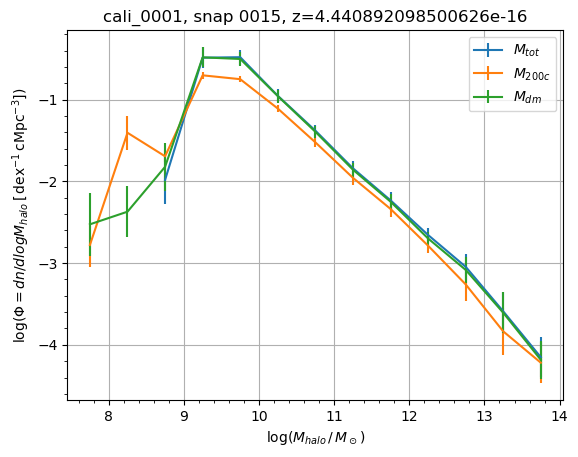

In [72]:
plt.clf()
plt.xlabel(r'$\log(M_{halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_{halo}\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

props = [halo_tot_masses, halo_vir_masses, halo_dm_masses]
prop_names = [r'$M_{tot}$', r'$M_{200c}$', r'$M_{dm}$']

for prop, prop_name in zip(props, prop_names):
    print(prop_name)
    logM_ax, logPhi, logPhi_total_lo_err, logPhi_total_hi_err, logPhi_total_err, logPhi_total_err_v2 = gen.mass_function_with_error(
        prop, halo_pos_Mpc, boxsize, Vcom, dlogM=0.5, min_logM=6, max_logM=14, calc_min_logM=False, calc_max_logM=True, minN=10)
    
    plt.errorbar(logM_ax, logPhi, yerr=logPhi_total_err, ls='-', label=prop_name)
    
    
plt.legend()
plt.show()

## Galaxy Stellar Mass Function (GSMF)

In [38]:
## IGNORE

# Double Schechter function fit (DOESN'T WORK)

# def log_schechter_fn(logM, params):
def log_schechter_fn(logM, log_Mstar, log_phi1, log_phi2, alpha1, alpha2):
#     log_Mstar = params[0]  # [Msun h70^-2]
#     log_phi1 = params[1]  # [Mpc^-3 h70^3]
#     log_phi2 = params[2]  # [Mpc^-3 h70^3]
#     alpha1 = params[3]
#     alpha2 = params[4]
#     log_rhostar = params[5]  # [Msun Mpc^-3 h70]
            
    Delta = logM - log_Mstar
    
#     PhiM = np.exp(-10**(Delta)) * (
#         10**(log_phi1 + alpha1*Delta) + 10**(log_phi2 + alpha2*Delta)) * 10**(-log_Mstar)
    Phi = np.log(10) * np.exp(-10**Delta) * 10**Delta * (
        10**(log_phi1 + alpha1*Delta) + 10**(log_phi2 + alpha2*Delta))

    return np.log10(Phi)

def log_schechter_fn_with_errors(logM, params, param_errs):
    log_Mstar = params[0]  # [Msun h70^-2]
    log_phi1 = params[1]  # [Mpc^-3 h70^3]
    log_phi2 = params[2]  # [Mpc^-3 h70^3]
    alpha1 = params[3]
    alpha2 = params[4]
#     log_rhostar = params[5]  # [Msun Mpc^-3 h70]

    log_Mstar_err = param_errs[0]  # [Msun h70^-2]
    log_phi1_err = param_errs[1]  # [Mpc^-3 h70^3]
    log_phi2_err = param_errs[2]  # [Mpc^-3 h70^3]
    alpha1_err = param_errs[3]
    alpha2_err = param_errs[4]
            
    Delta = logM - log_Mstar
    
    alpha1_Delta_err = alpha1*Delta*np.sqrt((alpha1_err/alpha1)**2 + (log_Mstar_err/log_Mstar)**2)
    alpha2_Delta_err = alpha2*Delta*np.sqrt((alpha2_err/alpha2)**2 + (log_Mstar_err/log_Mstar)**2)
    
#     PhiM = np.exp(-10**(Delta)) * (
#         10**(log_phi1 + alpha1*Delta) + 10**(log_phi2 + alpha2*Delta)) * 10**(-log_Mstar)
    Phi = np.log(10) * np.exp(-10**Delta) * 10**Delta * (
        10**(log_phi1 + alpha1*Delta) + 10**(log_phi2 + alpha2*Delta))
    logPhi = np.log10(Phi)
    
    logPhi_err = np.sqrt( ((np.log10(np.exp(1)) * np.log(10) * 10**Delta)**2 + 1) * log_Mstar_err**2 + 
                        ( (np.sqrt(log_phi1_err**2 + alpha1_Delta_err**2) + np.sqrt(log_phi2_err**2 + alpha2_Delta_err**2)  
                         * 10**(log_phi2 - log_phi1 + (alpha2-alpha1)*Delta)) / 
                        (1 + 10**(log_phi2 - log_phi1 + (alpha2-alpha1)*Delta)) )**2 )

    return logPhi, logPhi_err


popt, pcov = curve_fit(log_schechter_fn, logM_gal_ax, logPhi_gal)
perr = np.sqrt(np.abs(np.diag(pcov)))
# log_popt, log_pcov = curve_fit(log_Mbh_KH13_fit_fn, log_gal_stellar_masses_for_observable, 
#                                log_gal_bh_masses_for_observable)
# log_perr = np.sqrt(np.abs(np.diag(pcov)))
print(popt)
print(perr)

NameError: name 'logM_gal_ax' is not defined

simba_s50n512 (eddington biased)
[   0    0    0    0    0    0    0    0    0    0  158 1853 1847 1173
  846  693  578  533  416  317  232  165   95   43   21   14    5    1
    0    0    0    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0    0    0  158 1853 1847 1173
  846  693  578  533  416  317  232  165   95   43   21   14    5    1
    0    0    0    0    0    0    0    0    0    0    0    0]
[  0   0   0   0   0   0   0   0   0   0  13 187 188 109  81  61  42  41
  33  32  21  16   4   4   6   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0  14 151 165  91 102  58  39  53
  33  27  17  14   7   3   0   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0  25 300 296 197 129 120 103  91
  66  40  38  26  18   6   5   4   3   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0  30 384 417 258 178 154 15

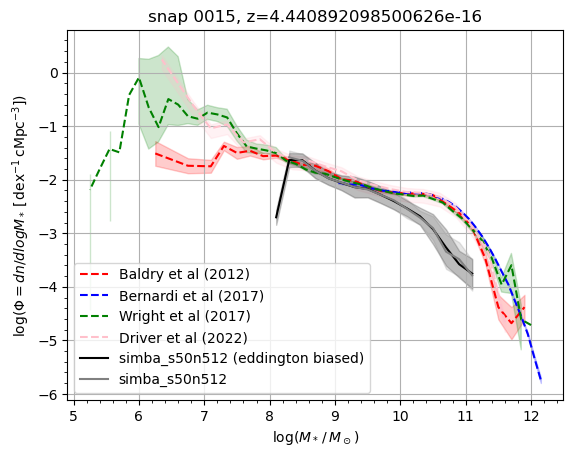

In [77]:
plt.clf()
plt.xlabel(r'$\log(M_*\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_*\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'snap %s, z=%s' % (snap_num, z))
plt.grid()
plt.minorticks_on()

observations_ = [observational_data['observations']['gsmf']['Baldry+12']['baldry12_gsmf_log_data.hdf5'],
                 observational_data['observations']['gsmf']['Bernardi+17']['bernardi17_gsmf_log_data.hdf5'],
                 observational_data['observations']['gsmf']['Wright+17']['wright17_z0_gsmf_log_data.hdf5'],
                 observational_data['observations']['gsmf']['Driver+22']['driver22_gsmf_log_data.hdf5'],
                ]
colours_ = ['red', 'blue', 'green', 'pink']
fmt_ = ['--', '--', '--', '--']

for ii in range(len(observations_)):
#     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
#                  xerr=observations_[ii].x_scatter.value, yerr=observations_[ii].y_scatter.value, 
#                  label=observations_[ii].citation, 
#                  fmt=fmt_[ii], color=colours_[ii])
    plt.plot(observations_[ii].x.value, observations_[ii].y.value, 
                 label=observations_[ii].citation, 
                 ls=fmt_[ii], color=colours_[ii])
    plt.fill_between(observations_[ii].x.value, 
                    observations_[ii].y.value - observations_[ii].y_scatter.value[0],
                    observations_[ii].y.value + observations_[ii].y_scatter.value[1],
                    color=colours_[ii], alpha=0.2)
#     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
#                  xerr=None, yerr=None, 
#                  label=observations_[ii].citation, 
#                  fmt=fmt_[ii], color=colours_[ii])
    
    
    
props = [gal_stellar_masses_eddington_biased, gal_stellar_masses]
# prop_names = ['%s (eddington biased)' % snap_prefix, snap_prefix]
plot_props = [{'label':'%s (eddington biased)' % snap_prefix,'color':'black', 'fmt':'-'}, 
              {'label':snap_prefix, 'color':'grey', 'fmt':'-'}
             ]

for prop, plot_prop in zip(props, plot_props):
    print(plot_prop['label'])
    logM_ax, logPhi, logPhi_total_lo_err, logPhi_total_hi_err, logPhi_total_err, logPhi_total_err_v2 = gen.mass_function_with_error(
        prop, gal_pos_Mpc, boxsize, Vcom, dlogM=0.2, min_logM=6, max_logM=14, calc_min_logM=False, calc_max_logM=False, minN=10)
    
#     isfinite = np.isfinite(logPhi)
#     logM_ax = logM_ax[isfinite]
#     logPhi = logPhi[isfinite]
#     logPhi_total_lo_err = logPhi_total_lo_err[isfinite]
#     logPhi_total_hi_err = logPhi_total_hi_err[isfinite]
#     logPhi_total_err = logPhi_total_err[isfinite]
    
#     plt.errorbar(logM_ax, logPhi, yerr=logPhi_total_err, 
#                  color=plot_prop['color'], fmt=plot_prop['fmt'], label=plot_prop['label'])
    plt.errorbar(logM_ax, logPhi, yerr=None, 
                 color=plot_prop['color'], fmt=plot_prop['fmt'], label=plot_prop['label'])
    plt.fill_between(logM_ax, logPhi-logPhi_total_err, logPhi+logPhi_total_err, color=plot_prop['color'], alpha=0.2)
#     plt.fill_between(logM_ax, logPhi-logPhi_total_lo_err, logPhi+logPhi_total_hi_err, color=plot_prop['color'], alpha=0.2)
    
    
plt.legend()
plt.show()

## Create Stellar Mass-Halo Mass Relation (SMHM)

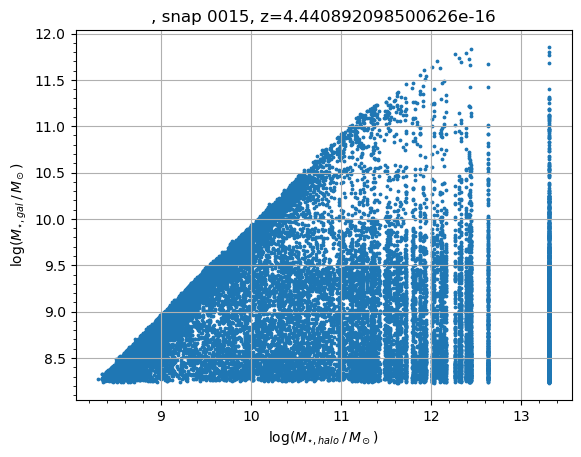

In [36]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{\star,halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{\star,gal}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

#plt.hist2d(log_halo_tot_masses, log_halo_stellar_masses, bins=(300,300), cmap=plt.cm.jet)
#plt.hist2d(halo_vir_masses, halo_stellar_masses, bins=(50,50), cmap=plt.cm.jet)
#plt.colorbar()

plt.scatter(log_parent_halo_stellar_masses, log_gal_stellar_masses, s=3)


# Calculate meian/mean


plt.show()

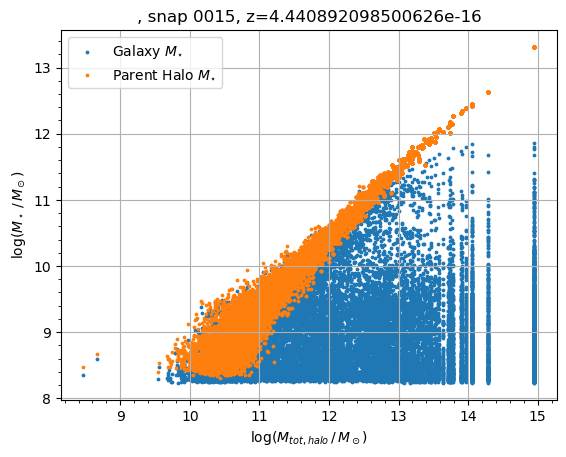

In [37]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{tot,halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

plt.scatter(log_parent_halo_tot_masses, log_gal_stellar_masses, s=3, label=r'Galaxy $M_{\star}$')
plt.scatter(log_parent_halo_tot_masses, log_parent_halo_stellar_masses, s=3, label=r'Parent Halo $M_{\star}$')

plt.legend()
plt.show()

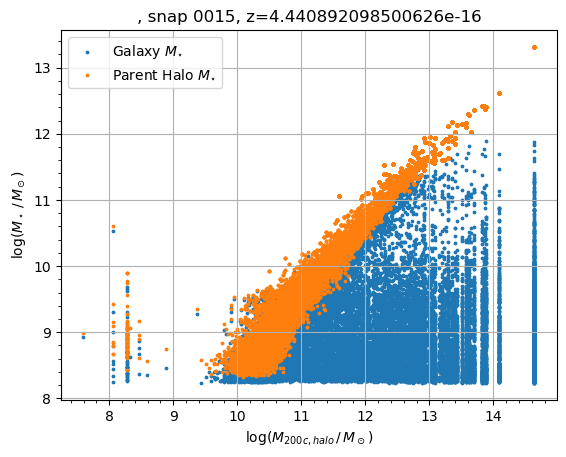

In [40]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{200c,halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

plt.scatter(log_parent_halo_vir_masses, log_gal_stellar_masses, s=3, label=r'Galaxy $M_{\star}$')
plt.scatter(log_parent_halo_vir_masses, log_parent_halo_stellar_masses, s=3, label=r'Parent Halo $M_{\star}$')

plt.legend()
plt.show()

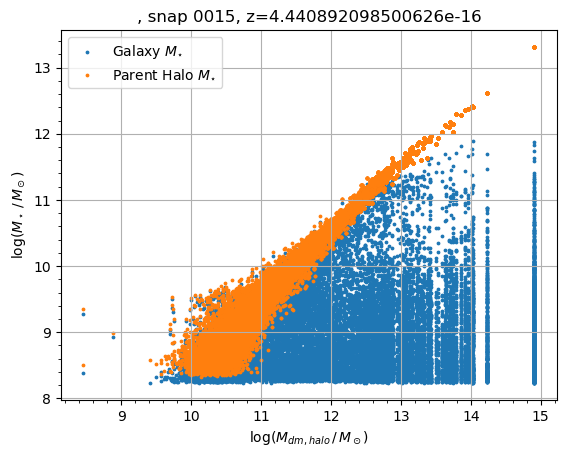

In [41]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{dm,halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

plt.scatter(log_parent_halo_dm_masses, log_gal_stellar_masses, s=3, label=r'Galaxy $M_{\star}$')
plt.scatter(log_parent_halo_dm_masses, log_parent_halo_stellar_masses, s=3, label=r'Parent Halo $M_{\star}$')

plt.legend()
plt.show()

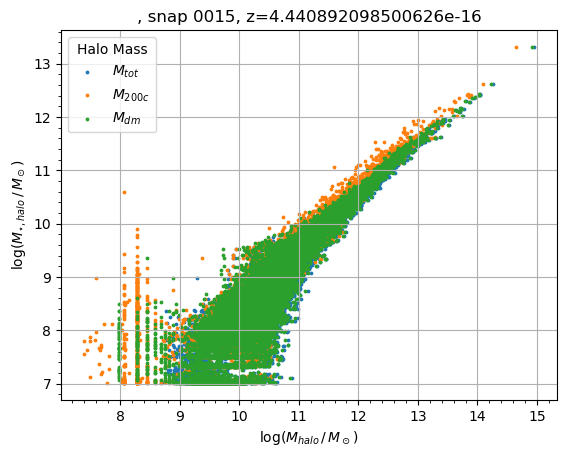

In [42]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{\star,halo}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

#plt.hist2d(log_halo_tot_masses, log_halo_stellar_masses, bins=(300,300), cmap=plt.cm.jet)
#plt.hist2d(halo_vir_masses, halo_stellar_masses, bins=(50,50), cmap=plt.cm.jet)
#plt.colorbar()

plt.scatter(log_halo_tot_masses, log_halo_stellar_masses, s=3, label=r'$M_{tot}$')
plt.scatter(log_halo_vir_masses, log_halo_stellar_masses, s=3, label=r'$M_{200c}$')
plt.scatter(log_halo_dm_masses, log_halo_stellar_masses, s=3, label=r'$M_{dm}$')

plt.legend(title='Halo Mass')
plt.show()

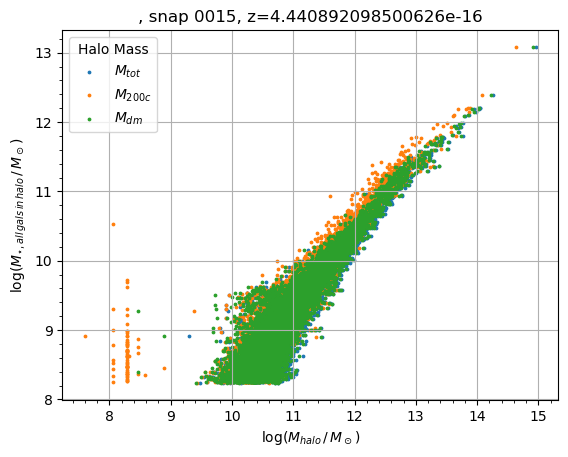

In [43]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{\star,all\, gals\, in\, halo}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

#plt.hist2d(log_halo_tot_masses, log_halo_stellar_masses, bins=(300,300), cmap=plt.cm.jet)
#plt.hist2d(halo_vir_masses, halo_stellar_masses, bins=(50,50), cmap=plt.cm.jet)
#plt.colorbar()

plt.scatter(log_halo_tot_masses, log_halo_gal_stellar_masses, s=3, label=r'$M_{tot}$')
plt.scatter(log_halo_vir_masses, log_halo_gal_stellar_masses, s=3, label=r'$M_{200c}$')
plt.scatter(log_halo_dm_masses, log_halo_gal_stellar_masses, s=3, label=r'$M_{dm}$')

plt.legend(title='Halo Mass')
plt.show()

# Create black hole functions/relations

## Black Hole Mass Function (BHMF)

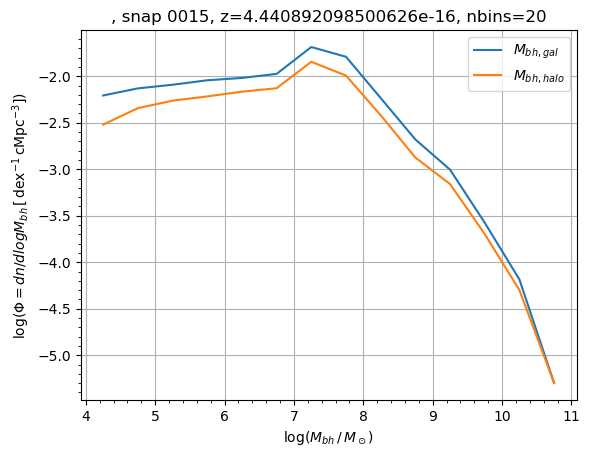

In [44]:
dlogM = 0.5                             #bin width in dex
bins = np.arange(2, 12, dlogM)
nbins = len(bins)

Phi_gal, edg_gal = np.histogram(log_gal_bh_masses, bins=bins) #Unnormalized histogram and bin edges
Phi_halo, edg_halo = np.histogram(log_halo_bh_masses, bins=bins)

logM_gal_ax   = edg_gal[0:-1] + dlogM/2.               #Mass axis
logM_halo_ax   = edg_halo[0:-1] + dlogM/2.

Phi_gal   = Phi_gal / Vcom / dlogM                 #Normalize to volume and bin size
Phi_halo   = Phi_halo / Vcom / dlogM

#fig, ax = plt.subplots()
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(M_{bh}\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_{bh}\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
plt.grid()
plt.minorticks_on()
plt.plot(logM_gal_ax, np.log10(Phi_gal), ls='-', label=r'$M_{bh,gal}$')
plt.plot(logM_halo_ax, np.log10(Phi_halo), ls='-', label=r'$M_{bh,halo}$')
plt.legend()
plt.show()

## Black Hole Mass-Halo Mass Relation (BHMHM)

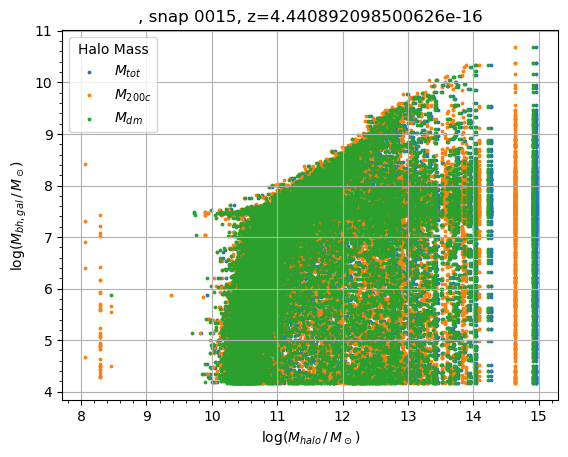

In [45]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{bh,gal}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

plt.scatter(log_parent_halo_tot_masses, log_gal_bh_masses, s=3, label=r'$M_{tot}$')
plt.scatter(log_parent_halo_vir_masses, log_gal_bh_masses, s=3, label=r'$M_{200c}$')
plt.scatter(log_parent_halo_dm_masses, log_gal_bh_masses, s=3, label=r'$M_{dm}$')

plt.legend(title='Halo Mass')
plt.show()

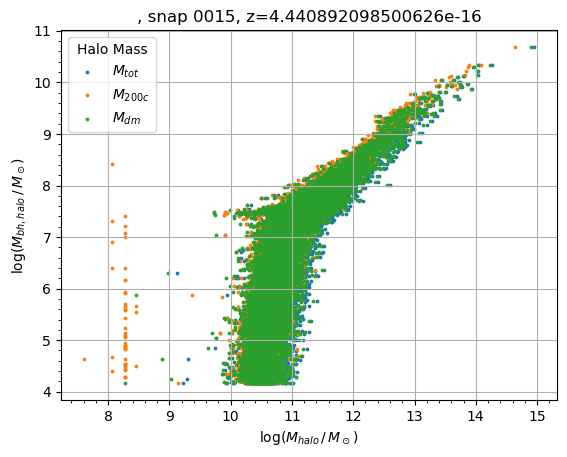

In [46]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{bh,halo}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

plt.scatter(log_halo_tot_masses, log_halo_bh_masses, s=3, label=r'$M_{tot}$')
plt.scatter(log_halo_vir_masses, log_halo_bh_masses, s=3, label=r'$M_{200c}$')
plt.scatter(log_halo_dm_masses, log_halo_bh_masses, s=3, label=r'$M_{dm}$')

plt.legend(title='Halo Mass')
plt.show()

## Black Hole Mass-Stellar Mass Relation (BHMSM)

In [82]:
min_log_gal_stellar_mass = 10
max_log_gal_stellar_mass = 13

In [83]:
gal_stellar_masses_no_zeros = gal_stellar_masses[gal_bh_masses > 0]
gal_bh_masses_no_zeros = gal_bh_masses[gal_bh_masses > 0]

log_gal_stellar_masses_no_zeros = np.log10(gal_stellar_masses_no_zeros)
log_gal_bh_masses_no_zeros = np.log10(gal_bh_masses_no_zeros)

gal_stellar_masses_for_observable = gal_stellar_masses_no_zeros[
    np.where(np.logical_and(
        gal_stellar_masses_no_zeros >= 10**min_log_gal_stellar_mass, 
        gal_stellar_masses_no_zeros <= 10**max_log_gal_stellar_mass))]
gal_bh_masses_for_observable = gal_bh_masses_no_zeros[
    np.where(np.logical_and(
        gal_stellar_masses_no_zeros >= 10**min_log_gal_stellar_mass, 
        gal_stellar_masses_no_zeros <= 10**max_log_gal_stellar_mass))]

log_gal_stellar_masses_for_observable = np.log10(gal_stellar_masses_for_observable)
log_gal_bh_masses_for_observable = np.log10(gal_bh_masses_for_observable)

In [84]:
save_data['bhmsm']['log_data'] = {'x':log_gal_stellar_masses * unyt.Solar_Mass,
                             'xerr':np.zeros(len(log_gal_stellar_masses)) * unyt.Solar_Mass,
                             'y':log_gal_bh_masses * unyt.Solar_Mass,
                             'yerr':np.zeros(len(log_gal_bh_masses)) * unyt.Solar_Mass, 
                             'x_label':'log(Mstar)', 
                             'y_label':'log(Mbh)'}

In [96]:
## Bin data and find means/medians in each bin
# x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
#     log_gal_stellar_masses_no_zeros, log_gal_bh_masses_no_zeros, 
#     dx=0.25, min_x=min_log_gal_stellar_mass, max_x=max_log_gal_stellar_mass, 
#     calc_min_x=True, calc_max_x=True, minN=10)

x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.regular_bin(
    log_gal_stellar_masses_no_zeros, log_gal_bh_masses_no_zeros, 
    dx=0.25, min_x=8, max_x=14, 
    calc_min_x=False, calc_max_x=False, minN=10)

save_data['bhmsm']['binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}
save_data['bhmsm']['binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo), np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}

[   2  165 1599 2615 2845 1893  968  612  359  237   94   38   12    3
    0    0    0    0    0    0    0    0    0    0]


In [86]:
## Variable binning such that there are EXACTLY X objects (cannot be set) in N bins (must be set)
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.exact_count_bin(
    log_gal_stellar_masses_no_zeros, log_gal_bh_masses_no_zeros,
    Nbins=30, min_x=min_log_gal_stellar_mass, max_x=max_log_gal_stellar_mass,
    calc_min_x=True, calc_max_x=True)

save_data['bhmsm']['exact_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}
save_data['bhmsm']['exact_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo), np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}

In [87]:
## Variable binning such that there are AT LEAST N objects in each bin
x_bin_centres, y_bin_means, y_bin_stds, y_bin_medians, y_bin_quantiles_lo, y_bin_quantiles_hi = gen.min_count_bin(
    log_gal_stellar_masses_no_zeros, log_gal_bh_masses_no_zeros,
    x_lo=min_log_gal_stellar_mass, x_hi=max_log_gal_stellar_mass, 
    calc_min_x=True, calc_max_x=True, 
    min_N_obj=3, min_bin_width=0.5, delta_x=0.02)

save_data['bhmsm']['min_count_binned_log_mean'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_means * unyt.Solar_Mass,
    'yerr':y_bin_stds * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}
save_data['bhmsm']['min_count_binned_log_median'] = {
    'x':x_bin_centres * unyt.Solar_Mass,
    'xerr':np.zeros(len(x_bin_centres)) * unyt.Solar_Mass,
    'y':y_bin_medians * unyt.Solar_Mass,
    'yerr':(np.abs(y_bin_medians - y_bin_quantiles_lo), np.abs(y_bin_medians - y_bin_quantiles_hi)) * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}

x_curr: 8.239025489320008  x_up: 8.739025489320008
bin width: 0.5
N_obj: 1647
Conditions achieved
Adding upper bin edge


x_curr: 8.739025489320008  x_up: 9.239025489320008
bin width: 0.5
N_obj: 5446
Conditions achieved
Adding upper bin edge


x_curr: 9.239025489320008  x_up: 9.739025489320008
bin width: 0.5
N_obj: 2964
Conditions achieved
Adding upper bin edge


x_curr: 9.739025489320008  x_up: 10.239025489320008
bin width: 0.5
N_obj: 995
Conditions achieved
Adding upper bin edge


x_curr: 10.239025489320008  x_up: 10.739025489320008
bin width: 0.5
N_obj: 334
Conditions achieved
Adding upper bin edge


x_curr: 10.739025489320008  x_up: 11.239025489320008
bin width: 0.5
N_obj: 52
Conditions achieved
Adding upper bin edge


x_curr: 11.239025489320008  x_up: 11.739025489320008
bin width: 0.5
N_obj: 3
Conditions achieved
x_curr over x_hi
Adding last upper bin edge


Done
x bins:
[8.239025489320008, 8.739025489320008, 9.239025489320008, 9.739025489320008, 10.239025489320008, 10.73902548932

In [88]:
## Fit from KH13 (pg. 57, eqn 10)
## They use a symmetric, least-squares ﬁt
log_x_arr = np.linspace(min(log_gal_stellar_masses), max(log_gal_stellar_masses), 10)

log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
    log_x_arr, log_gal_stellar_masses_for_observable, log_gal_bh_masses_for_observable, 
    func=None, paper='kh13', determine_func=True)
# log_x_arr, log_y, log_y_err = gen.log_fit_fn_with_errors_for_fitting(
#     log_x_arr, log_gal_stellar_masses_no_zeros, log_gal_bh_masses_no_zeros, 
#     func=None, paper='kh13', determine_func=True)

save_data['bhmsm']['log_fit'] = {
    'x':log_x_arr * unyt.Solar_Mass,
    'xerr':np.zeros(len(log_x_arr)) * unyt.Solar_Mass,
    'y':log_y * unyt.Solar_Mass,
    'yerr':log_y_err * unyt.Solar_Mass, 
    'x_label':'log(Mstar)', 
    'y_label':'log(Mbh)'
}

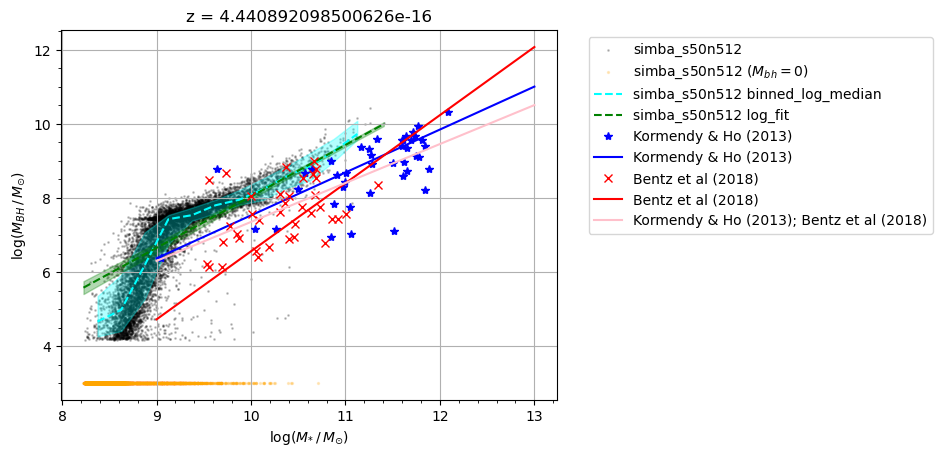

In [97]:
# Plot

plt.clf()
plt.xlabel(r'$\log(M_{*}\,/\,M_{\odot})$')
plt.ylabel(r'$\log(M_{BH}\,/\,M_{\odot})$')
plt.title('z = %s' % z)

## Data
# plt.errorbar(save_data['bhmsm']['log_data']['x'], 
#              save_data['bhmsm']['log_data']['y'], 
#              xerr=save_data['bhmsm']['log_data']['xerr'], 
#              yerr=save_data['bhmsm']['log_data']['yerr'], 
#              fmt='o', zorder=0, color='k', label=snap_prefix)
plt.scatter(save_data['bhmsm']['log_data']['x'], 
             save_data['bhmsm']['log_data']['y'],
             color='black', alpha=0.2, s=1, label=snap_prefix)
# plt.scatter(log_gal_stellar_masses_no_zeros, 
#              log_gal_bh_masses_no_zeros,
#              color='k', s=1, label=snap_prefix)

plt.scatter(save_data['bhmsm']['log_data']['x'][~np.isfinite(save_data['bhmsm']['log_data']['y'])], 
            [3]*len(save_data['bhmsm']['log_data']['y'][~np.isfinite(save_data['bhmsm']['log_data']['y'])]), 
            s=2, color='orange', alpha=0.2, label=r'%s ($M_{bh}=0$)' % snap_prefix)
# plt.scatter(log_gal_stellar_masses[gal_bh_masses==0], 
#             [3]*len(log_gal_bh_masses[gal_bh_masses==0]), 
#             s=1, label=r'%s ($M_{bh}=0$)' % snap_prefix)


## Binned means and medians
# plt.plot(save_data['bhmsm']['binned_log_mean']['x'], 
#          save_data['bhmsm']['binned_log_mean']['y'], 
#          ls='--', color='green', label='%s binned_log_mean' % (snap_prefix))
# plt.fill_between(save_data['bhmsm']['binned_log_mean']['x'], 
#                  save_data['bhmsm']['binned_log_mean']['y'] - save_data['bhmsm']['binned_log_mean']['yerr'], 
#                  save_data['bhmsm']['binned_log_mean']['y'] + save_data['bhmsm']['binned_log_mean']['yerr'],
#                  color='green', alpha=0.3)

plt.plot(save_data['bhmsm']['binned_log_median']['x'], 
         save_data['bhmsm']['binned_log_median']['y'], 
         ls='--', color='cyan', label='%s binned_log_median' % (snap_prefix))
plt.fill_between(save_data['bhmsm']['binned_log_median']['x'], 
                 save_data['bhmsm']['binned_log_median']['y'] - save_data['bhmsm']['binned_log_median']['yerr'][0], 
                 save_data['bhmsm']['binned_log_median']['y'] + save_data['bhmsm']['binned_log_median']['yerr'][1],
                 color='cyan', alpha=0.3)


## Exact count binned means and medians
# plt.plot(save_data['bhmsm']['exact_count_binned_log_mean']['x'], 
#          save_data['bhmsm']['exact_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s exact_count_binned_log_mean' % (snap_prefix))
# plt.fill_between(save_data['bhmsm']['exact_count_binned_log_mean']['x'], 
#                  save_data['bhmsm']['exact_count_binned_log_mean']['y'] - save_data['bhmsm']['exact_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm']['exact_count_binned_log_mean']['y'] + save_data['bhmsm']['exact_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm']['exact_count_binned_log_median']['x'], 
#          save_data['bhmsm']['exact_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s exact_count_binned_log_median' % (snap_prefix))
# plt.fill_between(save_data['bhmsm']['exact_count_binned_log_median']['x'], 
#                  save_data['bhmsm']['exact_count_binned_log_median']['y'] - save_data['bhmsm']['exact_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm']['exact_count_binned_log_median']['y'] + save_data['bhmsm']['exact_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Min count binned means and medians
# plt.plot(save_data['bhmsm']['min_count_binned_log_mean']['x'], 
#          save_data['bhmsm']['min_count_binned_log_mean']['y'], 
#          ls='--', color='green', label='%s min_count_binned_log_mean' % (snap_prefix))
# plt.fill_between(save_data['bhmsm']['min_count_binned_log_mean']['x'], 
#                  save_data['bhmsm']['min_count_binned_log_mean']['y'] - save_data['bhmsm']['min_count_binned_log_mean']['yerr'], 
#                  save_data['bhmsm']['min_count_binned_log_mean']['y'] + save_data['bhmsm']['min_count_binned_log_mean']['yerr'],
#                  color='green', alpha=0.2)

# plt.plot(save_data['bhmsm']['min_count_binned_log_median']['x'], 
#          save_data['bhmsm']['min_count_binned_log_median']['y'], 
#          ls='--', color='blue', label='%s min_count_binned_log_median' % (snap_prefix))
# plt.fill_between(save_data['bhmsm']['min_count_binned_log_median']['x'], 
#                  save_data['bhmsm']['min_count_binned_log_median']['y'] - save_data['bhmsm']['min_count_binned_log_median']['yerr'][0], 
#                  save_data['bhmsm']['min_count_binned_log_median']['y'] + save_data['bhmsm']['min_count_binned_log_median']['yerr'][1],
#                  color='blue', alpha=0.2)


## Fit
plt.plot(save_data['bhmsm']['log_fit']['x'], 
         save_data['bhmsm']['log_fit']['y'], 
         ls='--', color='green', label='%s log_fit' % (snap_prefix))
plt.fill_between(save_data['bhmsm']['log_fit']['x'], 
                 save_data['bhmsm']['log_fit']['y'] - save_data['bhmsm']['log_fit']['yerr'], 
                 save_data['bhmsm']['log_fit']['y'] + save_data['bhmsm']['log_fit']['yerr'],
                 color='green', alpha=0.3)





# Plot observational data
observations_ = [
    observational_data['observations']['bhmsm']['KormendyHo2013']['kh13_bhmsm_log_data.hdf5'],
                 observational_data['observations']['bhmsm']['KormendyHo2013']['kh13_bhmsm_log_fit_og.hdf5'],
                 observational_data['observations']['bhmsm']['Bentz18']['bentz18_bhmsm_log_data.hdf5'],
                 observational_data['observations']['bhmsm']['Bentz18']['bentz18_bhmsm_log_fit_og.hdf5'],
                 observational_data['observations']['bhmsm']['KH13+Bentz18']['kh13+bentz18_bhmsm_log_fit.hdf5']]
colours_ = ['blue', 'blue', 'red', 'red', 'pink']
fmt_ = ['*', '-', 'x', '-', '-']
# fmt_ = ['*', 'x', '-']
# ls_ = [None, '-', None, '-']

for ii in range(len(observations_)):
#     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
#                  xerr=observations_[ii].x_scatter.value, yerr=observations_[ii].y_scatter.value, 
#                  label=observations_[ii].citation,  
#                  color=colours_[ii], fmt=fmt_[ii])
    plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
                 xerr=None, yerr=None, 
                 label=observations_[ii].citation,  
                 color=colours_[ii], fmt=fmt_[ii])





# plt.ylim(np.log10(5e5), np.log10(5e10))
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.minorticks_on()
plt.show()

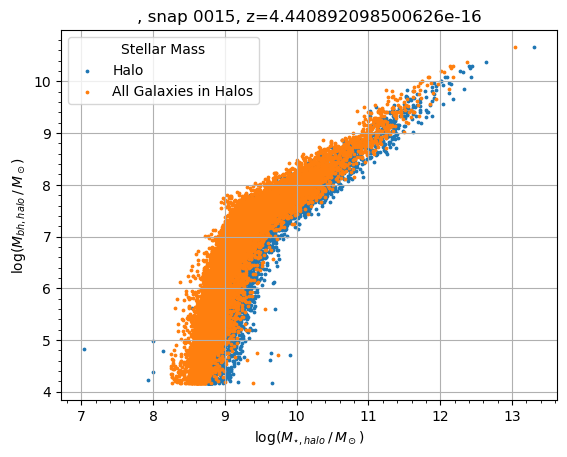

In [46]:
plt.clf()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\log(M_{\star,halo}\,/\,M_\odot)$')
plt.ylabel(r'$\log(M_{bh,halo}\,/\,M_\odot)$')
plt.title(r'%s, snap %s, z=%s' % (cali_num, snap_num, z))
plt.grid()
plt.minorticks_on()

# plt.errorbar(log_Mbulge_kh13, log_Mbh_kh13, xerr=log_Mbulge_err_kh13, yerr=(log_Mbh_lo_err_kh13, log_Mbh_hi_err_kh13), 
#              fmt='o', zorder=100, color='k', markersize=4)

plt.scatter(log_halo_stellar_masses, log_halo_bh_masses, s=3, label=r'Halo')
plt.scatter(log_halo_gal_stellar_masses, log_halo_bh_masses, s=3, label=r'All Galaxies in Halos')
#print(len(halo_gal_stellar_masses))

plt.legend(title='Stellar Mass')
plt.show()

# Observables over redshift/time

In [148]:
# dynamically deallocate read-in snapshots?

redshifts = []
# volumes_com = []
# boxsizes = []
# gal_positions_Mpc = []
# halo_positions_Mpc = []
box_info = {'Vcom':{}, 'boxsize':{}, 'gal_pos_Mpc':{}, 'halo_pos_Mpc':{}}

log_sfrd = {'gal_inst':[], 'gal_100':[], 'halo_inst':[], 'halo_100':[]}  # Msun/yr/Mpc^3
log_mean_ssfr = {'gal_inst':[], 'gal_100':[], 'halo_inst':[], 'halo_100':[]}  # Gyr^-1
log_smd = {'gal':[], 'halo':[]}  # Msun/Mpc^3

halo_mass_function = {}
stellar_mass_function = {}
sfr_function = {}

log_gal_masses = {'stellar':{}, 'stellar_eddington_biased':{}, 
                  'central_stellar':{}, 'central_stellar_v2':{}, 'satellite_stellar':{}, 
                  'parent_halo_stellar':{}, 'parent_halo_tot':{},
                 'parent_halo_vir':{}, 'parent_halo_dm':{}, 'bh':{}}  # Msun
log_halo_masses = {'stellar':{}, 'central_stellar':{}, 'gal_stellar':{}, 'tot':{}, 'vir':{}, 'dm':{}, 'bh':{}}  # Msun
log_sfr = {'gal_inst':{}, 'gal_central_inst':{}, 'gal_sat_inst':{}, 'gal_100':{}, 'halo_inst':{}, 'halo_100':{}}  # Msun/yr
log_ssfr = {'gal_inst':{}, 'gal_central_inst':{}, 'gal_sat_inst':{}, 'gal_100':{}, 'halo_inst':{}, 'halo_100':{}}  # Gyr^-1

num_snaps = 16
#cali_list = ["cali_%s" % str(i).zfill(4) for i in range(num_calis)]
# num_snap_list = np.array([15])
snap_num_list = ["%04d" % i for i in range(num_snaps)]
# snap_num_list = ["%04d" % i for i in num_snap_list]
print(snap_num_list)

for snapnum in snap_num_list:
    # Load snapshot into yt
    snap_ = os.path.join(snap_dir, cali_num, snap_prefix+'_'+snapnum+'.hdf5')
    ds_ = load(snap_)
    
    Vcom_ = ds_.domain_width.in_units("Mpccm").prod()
    print("Comoving Volume=%s" % Vcom_)
    
    # Load in Caesar file
    infile_ = os.path.join(snap_dir, cali_num, snap_prefix+'_caesar_'+snapnum+'.hdf5')
    obj_ = caesar.load(infile_)
    
    z_ = obj_.simulation.redshift
    h_ = obj_.simulation.hubble_constant
    boxsize_ = obj_.simulation.boxsize.in_units("Mpccm")

    print('z=%s' % (z_))
    print('h=%s' % (h_))
    
    gal_pos_Mpc_ = np.array([gal.pos.in_units('Mpccm') for gal in obj_.galaxies])
    halo_pos_Mpc_ = np.array([halo.pos.in_units('Mpccm') for halo in obj_.halos])
    
    redshifts.append(z_)
    box_info['Vcom'][str(z_)] = Vcom_
    box_info['boxsize'][str(z_)] = boxsize_
    box_info['gal_pos_Mpc'][str(z_)] = gal_pos_Mpc_
    box_info['halo_pos_Mpc'][str(z_)] = halo_pos_Mpc_
#     volumes_com.append(Vcom_)
#     boxsizes.append(boxsize_)
#     gal_positions_Mpc.append(gal_pos_Mpc_)
#     halo_positions_Mpc.append(halo_pos_Mpc_)
    
    
    
    
    # Calculate galaxy/halo properties
    log_sfrd['gal_inst'].append(np.log10(sum([gal.sfr for gal in obj_.galaxies])/Vcom_))
    log_sfrd['gal_100'].append(np.log10(sum([gal.sfr_100 for gal in obj_.galaxies])/Vcom_))
    log_sfrd['halo_inst'].append(np.log10(sum([halo.sfr for halo in obj_.halos])/Vcom_))
    log_sfrd['halo_100'].append(np.log10(sum([halo.sfr_100 for halo in obj_.halos])/Vcom_))
    
    log_mean_ssfr['gal_inst'].append(np.log10(np.mean([gal.sfr.to('Msun/Gyr')/gal.masses['stellar'] for gal in obj_.galaxies])))
    log_mean_ssfr['gal_100'].append(np.log10(np.mean([gal.sfr_100.to('Msun/Gyr')/gal.masses['stellar'] for gal in obj_.galaxies])))
    log_mean_ssfr['halo_inst'].append(np.log10(np.mean([halo.sfr.to('Msun/Gyr')/halo.masses['stellar'] for halo in obj_.halos])))
    log_mean_ssfr['halo_100'].append(np.log10(np.mean([halo.sfr_100.to('Msun/Gyr')/halo.masses['stellar'] for halo in obj_.halos])))
    
    log_smd['gal'].append(np.log10(sum([gal.masses['stellar'] for gal in obj_.galaxies])/Vcom_))
    log_smd['halo'].append(np.log10(sum([halo.masses['stellar'] for halo in obj_.halos])/Vcom_))
    
    
    log_gal_masses['stellar'][str(z_)] = np.log10(np.array([gal.masses['stellar'] for gal in obj_.galaxies]))
#     log_gal_masses['central_stellar'][str(z_)] = np.log10(np.array([gal.masses['stellar'] for gal in obj_.galaxies if gal.central]))
#     log_gal_masses['central_stellar_v2'][str(z_)] = np.log10(np.array([gal.masses['stellar'] for gal in obj_.galaxies if gal.central<=1]))
#     log_gal_masses['satellite_stellar'][str(z_)] = np.log10(np.array([gal.masses['stellar'] for gal in obj_.galaxies if gal.central!=1]))
#     log_gal_masses['parent_halo_stellar'][str(z_)] = np.log10(np.array([gal.halo.masses['stellar'] for gal in obj_.galaxies]))
#     log_gal_masses['parent_halo_tot'][str(z_)] = np.log10(np.array([gal.halo.masses['total'] for gal in obj_.galaxies]))
#     log_gal_masses['parent_halo_vir'][str(z_)] = np.log10(np.array([gal.halo.virial_quantities['m200c'] for gal in obj_.galaxies]))
#     log_gal_masses['parent_halo_dm'][str(z_)] = np.log10(np.array([gal.halo.masses['dm'] for gal in obj_.galaxies]))
    log_gal_masses['bh'][str(z_)] = np.log10(np.array([gal.masses['bh'] for gal in obj_.galaxies]))
    
#     log_halo_masses['stellar'][str(z_)] = np.log10(np.array([halo.masses['stellar'] for halo in obj_.halos]))
#     log_halo_masses['central_stellar'][str(z_)] = np.log10(np.array([halo.central_galaxy.masses['stellar'] for halo in obj_.halos if halo.central_galaxy is not None]))
#     log_halo_masses['gal_stellar'][str(z_)] = np.log10(np.array([sum(gal.masses['stellar'] for gal in halo.galaxies) for halo in obj_.halos]))
#     log_halo_masses['tot'][str(z_)] = np.log10(np.array([halo.masses['total'] for halo in obj_.halos]))
#     log_halo_masses['vir'][str(z_)] = np.log10(np.array([halo.virial_quantities['m200c'] for halo in obj_.halos]))
#     log_halo_masses['dm'][str(z_)] = np.log10(np.array([halo.masses['dm'] for halo in obj_.halos]))
#     log_halo_masses['bh'][str(z_)] = np.log10(np.array([halo.masses['bh'] for halo in obj_.halos]))
    
    log_sfr['gal_inst'][str(z_)] = np.log10(np.array([gal.sfr for gal in obj_.galaxies]))
#     log_sfr['gal_central_inst'][str(z_)] = np.log10(np.array([gal.sfr for gal in obj_.galaxies if gal.central]))
#     log_sfr['gal_sat_inst'][str(z_)] = np.log10(np.array([gal.sfr for gal in obj_.galaxies if gal.central!=1]))
#     log_sfr['gal_100'][str(z_)] = np.log10(np.array([gal.sfr_100 for gal in obj_.galaxies]))
#     log_sfr['halo_inst'][str(z_)] = np.log10(np.array([halo.sfr for halo in obj_.halos]))
#     log_sfr['halo_100'][str(z_)] = np.log10(np.array([halo.sfr_100 for halo in obj_.halos]))
    
    log_ssfr['gal_inst'][str(z_)] = np.log10(np.array([gal.sfr.to('Msun/Gyr')/gal.masses['stellar'].to('Msun') for gal in obj_.galaxies]))
#     log_ssfr['gal_central_inst'][str(z_)] = np.log10(np.array([gal.sfr.to('Msun/Gyr')/gal.masses['stellar'].to('Msun') for gal in obj_.galaxies if gal.central]))
#     log_ssfr['gal_sat_inst'][str(z_)] = np.log10(np.array([gal.sfr.to('Msun/Gyr')/gal.masses['stellar'].to('Msun') for gal in obj_.galaxies if gal.central!=1]))
#     log_ssfr['gal_100'][str(z_)] = np.log10(np.array([gal.sfr_100.to('Msun/Gyr')/gal.masses['stellar'].to('Msun') for gal in obj_.galaxies]))
#     log_ssfr['halo_inst'][str(z_)] = np.log10(np.array([halo.sfr.to('Msun/Gyr')/halo.masses['stellar'].to('Msun') for halo in obj_.halos]))
#     log_ssfr['halo_100'][str(z_)] = np.log10(np.array([halo.sfr_100.to('Msun/Gyr')/halo.masses['stellar'].to('Msun') for halo in obj_.halos]))




    # Add eddington bias to calculated/measured/observed stellar masses (for GSMF only?)
    # See Kugel+23 (FLAMINGO: Calibrating large cosmological hydrodynamical simulations with machine learning)
    # Section 3.1.1 eqn 11

    rng_ = np.random.default_rng()
    mu_eddington_ = 0
    sigma_eddington_ = min(0.070+0.071*z_, 0.3) # dex
    # print(sigma_eddington)
    # eddington_bias = rng.lognormal(mean=mu_eddington, sigma=sigma_eddington)#, size=1)
    eddington_bias_ = rng_.normal(loc=mu_eddington_, scale=sigma_eddington_, size=len(log_gal_masses['stellar'][str(z_)]))
#     len(eddington_bias)

    # print([rng.normal(loc=mu_eddington, scale=sigma_eddington) for i in range(5)])

    log_gal_stellar_masses_eddington_biased_ = log_gal_masses['stellar'][str(z_)] + eddington_bias_
    # print(log_gal_stellar_masses)
    # print(log_gal_stellar_masses_for_gsmf)
#     gal_stellar_masses_eddington_biased_ = 10**log_gal_stellar_masses_eddington_biased_

    log_gal_masses['stellar_eddington_biased'][str(z_)] = log_gal_stellar_masses_eddington_biased_
    
    
    
    
    
#     halo_vir_masses_ = np.array([halo.virial_quantities['m200c'] for halo in obj_.halos])
#     log_halo_vir_masses_ = np.log10(halo_vir_masses_)
#     dlogM_ = 0.5
# #     bins_ = np.arange(5, 15+dlogM_, dlogM_)
#     logM_halo_vir_ax_, logPhi_halo_vir_, logPhi_halo_vir_total_lo_err_, logPhi_halo_vir_total_hi_err_, logPhi_halo_vir_total_err_, logPhi_halo_vir_total_err_v2_ = gen.mass_function_with_error(
#     halo_vir_masses_, halo_pos_Mpc_, boxsize_, Vcom_, dlogM=dlogM_, min_logM=6, max_logM=14, calc_min_logM=False, calc_max_logM=True)

# #     isfinite_ = np.isfinite(logPhi_halo_vir_)
# #     logM_halo_vir_ax_ = logM_halo_vir_ax_[isfinite_]
# #     logPhi_halo_vir_ = logPhi_halo_vir_[isfinite_]
# #     logPhi_halo_vir_total_lo_err_ = logPhi_halo_vir_total_lo_err_[isfinite_]
# #     logPhi_halo_vir_total_hi_err_ = logPhi_halo_vir_total_hi_err_[isfinite_]
# #     logPhi_halo_vir_total_err_ = logPhi_halo_vir_total_err_[isfinite_]
    
# #     Phi_, edg_ = np.histogram(log_halo_vir_masses_, bins=bins_)
# #     logM_ax_   = edg_[0:-1] + dlogM_/2.
# #     log_Phi_ = np.log10(Phi_ / Vcom_ / dlogM_)
#     halo_mass_function[str(z_)] = {
#         'x':logM_halo_vir_ax_, 
#         'y':logPhi_halo_vir_, 
#         'yerr':logPhi_halo_vir_total_err_
#     }

    
    
    
    
#     gal_stellar_masses_ = np.array([gal.masses['stellar'] for gal in obj_.galaxies])
#     log_gal_stellar_masses_ = np.log10(gal_stellar_masses_)
    
#     # Add eddington bias to calculated/measured/observed stellar masses (for GSMF only?)
#     # See Kugel+23 (FLAMINGO: Calibrating large cosmological hydrodynamical simulations with machine learning)
#     # Section 3.1.1 eqn 11

#     rng_ = np.random.default_rng()
#     mu_eddington_ = 0
#     sigma_eddington_ = min(0.070+0.071*z_, 0.3) # dex
#     # print(sigma_eddington)
#     # eddington_bias = rng.lognormal(mean=mu_eddington, sigma=sigma_eddington)#, size=1)
#     eddington_bias_ = rng_.normal(loc=mu_eddington_, scale=sigma_eddington_, size=len(log_gal_stellar_masses_))
# #     len(eddington_bias)

#     # print([rng.normal(loc=mu_eddington, scale=sigma_eddington) for i in range(5)])

#     log_gal_stellar_masses_eddington_biased_ = log_gal_stellar_masses_ + eddington_bias_
#     # print(log_gal_stellar_masses)
#     # print(log_gal_stellar_masses_for_gsmf)
#     gal_stellar_masses_eddington_biased_ = 10**log_gal_stellar_masses_eddington_biased_
    
#     dlogM_ = 0.5
# #     bins_ = np.arange(5, 15+dlogM_, dlogM_)
#     logM_gal_ax_, logPhi_gal_, logPhi_gal_total_lo_err_, logPhi_gal_total_hi_err_, logPhi_gal_total_err_, logPhi_gal_total_err_v2_ = gen.mass_function_with_error(
#         gal_stellar_masses_eddington_biased_, gal_pos_Mpc_, boxsize_, Vcom_, 
#         dlogM=dlogM_, min_logM=6, max_logM=14, calc_min_logM=False, calc_max_logM=False)

# #     isfinite_ = np.isfinite(logPhi_gal)
# #     logM_gal_ax = logM_gal_ax[isfinite_]
# #     logPhi_gal = logPhi_gal[isfinite_]
# #     logPhi_gal_total_lo_err = logPhi_gal_total_lo_err[isfinite_]
# #     logPhi_gal_total_hi_err = logPhi_gal_total_hi_err[isfinite_]
# #     logPhi_gal_total_err = logPhi_gal_total_err[isfinite_]
    
# #     Phi_, edg_ = np.histogram(log_gal_stellar_masses_, bins=bins_)
# #     logM_ax_   = edg_[0:-1] + dlogM_/2.
# #     log_Phi_ = np.log10(Phi_ / Vcom_ / dlogM_)
#     stellar_mass_function[str(z_)] = {
#         'x':logM_gal_ax_, 
#         'y':logPhi_gal_, 
#         'yerr':logPhi_gal_total_err_
#     }

    
    
#     gal_sfrs_ = np.array([gal.sfr for gal in obj_.galaxies])
#     log_gal_sfrs_ = np.log10(gal_sfrs_)
#     dlogSFR_ = 0.5
# #     bins_ = np.arange(-5, 5+dlogSFR_, dlogSFR_)
#     logSFR_gal_ax_, logPhi_gal_, logPhi_gal_total_lo_err_, logPhi_gal_total_hi_err_, logPhi_gal_total_err_, logPhi_gal_total_err_v2_ = gen.mass_function_with_error(
#     gal_sfrs_, gal_pos_Mpc_, boxsize_, Vcom_, dlogM=dlogSFR_, min_logM=-5, max_logM=5, calc_min_logM=False, calc_max_logM=True)

# #     isfinite_ = np.isfinite(logPhi_gal)
# #     logSFR_gal_ax = logSFR_gal_ax[isfinite_]
# #     logPhi_gal = logPhi_gal[isfinite_]
# #     logPhi_gal_total_lo_err = logPhi_gal_total_lo_err[isfinite_]
# #     logPhi_gal_total_hi_err = logPhi_gal_total_hi_err[isfinite_]
# #     logPhi_gal_total_err = logPhi_gal_total_err[isfinite_]
    
# #     Phi_, edg_ = np.histogram(log_gal_sfrs_, bins=bins_)
# #     logSFR_ax_   = edg_[0:-1] + dlogSFR_/2.
# #     log_Phi_ = np.log10(Phi_ / Vcom_ / dlogSFR_)
#     sfr_function[str(z_)] = {
#         'x':logSFR_gal_ax_,
#         'y':logPhi_gal_, 
#         'yerr':logPhi_gal_total_err_
#     }
# #     sfr_function[str(z_)]['x'] = logSFR_ax_
# #     sfr_function[str(z_)]['y'] = log_Phi_


    del ds_
    del obj_

yt : [INFO     ] 2023-11-01 16:10:22,424 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:10:22,434 Calculating time from 7.905e-04 to be 2.439e+16 seconds


['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015']


yt : [INFO     ] 2023-11-01 16:10:22,456 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:10:22,511 Parameters: current_time              = 2.439079033482242e+16 s
yt : [INFO     ] 2023-11-01 16:10:22,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:10:22,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:10:22,516 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:10:22,516 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:10:22,517 Parameters: current_redshift          = 6.999999999999995
yt : [INFO     ] 2023-11-01 16:10:22,518 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:10:22,518 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2023-11-01 16:10:22,519 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-01 16:10:22,519 Parameters: hubble_constan

Comoving Volume=397542.39684679086 Mpccm**3


yt : [INFO     ] 2023-11-01 16:10:22,865 Found 140504 halos
yt : [INFO     ] 2023-11-01 16:10:22,877 Found 221 galaxies


z=6.999999999999995
h=0.68


/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/unyt/array.py:1906: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/tmp/ipykernel_203635/1176863242.py:91: RuntimeWarning: divide by zero encountered in log10
  log_gal_masses['bh'][str(z_)] = np.log10(np.array([gal.masses['bh'] for gal in obj_.galaxies]))
yt : [INFO     ] 2023-11-01 16:10:36,842 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:10:36,852 Calculating time from 9.654e-04 to be 2.979e+16 seconds
yt : [INFO     ] 2023-11-01 16:10:36,872 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:10:36,929 Parameters: current_time              = 2.978868272828722e+16 s
yt : [INFO     ] 2023-11-01 16:10:36,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-0

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:10:37,391 Found 182619 halos
yt : [INFO     ] 2023-11-01 16:10:37,402 Found 615 galaxies


z=6.000007000006998
h=0.68


yt : [INFO     ] 2023-11-01 16:10:55,658 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:10:55,667 Calculating time from 1.216e-03 to be 3.751e+16 seconds
yt : [INFO     ] 2023-11-01 16:10:55,687 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:10:55,745 Parameters: current_time              = 3.751334469462407e+16 s
yt : [INFO     ] 2023-11-01 16:10:55,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:10:55,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:10:55,749 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:10:55,750 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:10:55,751 Parameters: current_redshift          = 4.999988000023999
yt : [INFO     ] 2023-11-01 16:10:55,751 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:10:55,752 Parameters: omega_matter              = 0.3


Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:10:56,200 Found 209043 halos
yt : [INFO     ] 2023-11-01 16:10:56,243 Found 1341 galaxies


z=4.999988000023999
h=0.68


/tmp/ipykernel_203635/1176863242.py:101: RuntimeWarning: divide by zero encountered in log10
  log_sfr['gal_inst'][str(z_)] = np.log10(np.array([gal.sfr for gal in obj_.galaxies]))
/tmp/ipykernel_203635/1176863242.py:108: RuntimeWarning: divide by zero encountered in log10
  log_ssfr['gal_inst'][str(z_)] = np.log10(np.array([gal.sfr.to('Msun/Gyr')/gal.masses['stellar'].to('Msun') for gal in obj_.galaxies]))
yt : [INFO     ] 2023-11-01 16:11:39,303 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:11:39,313 Calculating time from 1.596e-03 to be 4.925e+16 seconds
yt : [INFO     ] 2023-11-01 16:11:39,333 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:11:39,390 Parameters: current_time              = 4.924852382533563e+16 s
yt : [INFO     ] 2023-11-01 16:11:39,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:11:39,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:11:39,395 Parameters: domain_

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:11:39,929 Found 221899 halos
yt : [INFO     ] 2023-11-01 16:11:39,941 Found 2698 galaxies


z=4.0
h=0.68


yt : [INFO     ] 2023-11-01 16:12:02,620 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:12:02,629 Calculating time from 2.224e-03 to be 6.863e+16 seconds
yt : [INFO     ] 2023-11-01 16:12:02,649 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:12:02,706 Parameters: current_time              = 6.862713661669071e+16 s
yt : [INFO     ] 2023-11-01 16:12:02,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:12:02,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:12:02,709 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:12:02,709 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:12:02,709 Parameters: current_redshift          = 2.9999999999999982
yt : [INFO     ] 2023-11-01 16:12:02,710 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:12:02,710 Parameters: omega_matter              = 0.3

Comoving Volume=397542.39684679103 Mpccm**3


yt : [INFO     ] 2023-11-01 16:12:03,513 Found 219495 halos
yt : [INFO     ] 2023-11-01 16:12:03,524 Found 4512 galaxies


z=2.9999999999999982
h=0.68


yt : [INFO     ] 2023-11-01 16:12:26,318 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:12:26,327 Calculating time from 3.397e-03 to be 1.048e+17 seconds
yt : [INFO     ] 2023-11-01 16:12:26,347 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:12:26,400 Parameters: current_time              = 1.0481941251085472e+17 s
yt : [INFO     ] 2023-11-01 16:12:26,402 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:12:26,404 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:12:26,405 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:12:26,406 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:12:26,406 Parameters: current_redshift          = 2.0000030000030002
yt : [INFO     ] 2023-11-01 16:12:26,407 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:12:26,408 Parameters: omega_matter              = 0.

Comoving Volume=397542.39684679045 Mpccm**3


yt : [INFO     ] 2023-11-01 16:12:26,991 Found 208546 halos
yt : [INFO     ] 2023-11-01 16:12:27,030 Found 6954 galaxies


z=2.0000030000030002
h=0.68


yt : [INFO     ] 2023-11-01 16:12:48,983 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:12:48,993 Calculating time from 6.055e-03 to be 1.868e+17 seconds
yt : [INFO     ] 2023-11-01 16:12:49,013 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:12:49,070 Parameters: current_time              = 1.8684685625371706e+17 s
yt : [INFO     ] 2023-11-01 16:12:49,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:12:49,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:12:49,075 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:12:49,076 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:12:49,076 Parameters: current_redshift          = 0.9999999999999991
yt : [INFO     ] 2023-11-01 16:12:49,077 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:12:49,078 Parameters: omega_matter              = 0.

Comoving Volume=397542.39684679103 Mpccm**3


yt : [INFO     ] 2023-11-01 16:12:49,542 Found 194877 halos
yt : [INFO     ] 2023-11-01 16:12:49,553 Found 9254 galaxies


z=0.9999999999999991
h=0.68


yt : [INFO     ] 2023-11-01 16:13:38,861 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:13:38,872 Calculating time from 6.990e-03 to be 2.157e+17 seconds
yt : [INFO     ] 2023-11-01 16:13:38,891 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:13:38,947 Parameters: current_time              = 2.1568737595469437e+17 s
yt : [INFO     ] 2023-11-01 16:13:38,949 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:13:38,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:13:38,952 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:13:38,953 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:13:38,953 Parameters: current_redshift          = 0.7999985600011521
yt : [INFO     ] 2023-11-01 16:13:38,954 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:13:38,955 Parameters: omega_matter              = 0.

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:13:39,325 Found 190057 halos
yt : [INFO     ] 2023-11-01 16:13:39,367 Found 9432 galaxies


z=0.7999985600011521
h=0.68


yt : [INFO     ] 2023-11-01 16:13:59,929 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:13:59,940 Calculating time from 7.543e-03 to be 2.328e+17 seconds
yt : [INFO     ] 2023-11-01 16:13:59,960 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:14:00,018 Parameters: current_time              = 2.3276807586249974e+17 s
yt : [INFO     ] 2023-11-01 16:14:00,020 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:14:00,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:14:00,023 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:14:00,024 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:14:00,024 Parameters: current_redshift          = 0.7000008500004251
yt : [INFO     ] 2023-11-01 16:14:00,025 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:14:00,026 Parameters: omega_matter              = 0.

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:14:00,397 Found 187401 halos
yt : [INFO     ] 2023-11-01 16:14:00,410 Found 9462 galaxies


z=0.7000008500004251
h=0.68


yt : [INFO     ] 2023-11-01 16:14:20,789 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:14:20,798 Calculating time from 8.167e-03 to be 2.520e+17 seconds
yt : [INFO     ] 2023-11-01 16:14:20,818 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:14:20,874 Parameters: current_time              = 2.5200175026302893e+17 s
yt : [INFO     ] 2023-11-01 16:14:20,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:14:20,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:14:20,878 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:14:20,879 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:14:20,880 Parameters: current_redshift          = 0.5999999999999994
yt : [INFO     ] 2023-11-01 16:14:20,880 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:14:20,881 Parameters: omega_matter              = 0.

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:14:21,448 Found 185160 halos
yt : [INFO     ] 2023-11-01 16:14:21,461 Found 9504 galaxies


z=0.5999999999999994
h=0.68


yt : [INFO     ] 2023-11-01 16:14:43,539 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:14:43,549 Calculating time from 8.871e-03 to be 2.737e+17 seconds
yt : [INFO     ] 2023-11-01 16:14:43,570 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:14:43,626 Parameters: current_time              = 2.7373675091993053e+17 s
yt : [INFO     ] 2023-11-01 16:14:43,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:14:43,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:14:43,631 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:14:43,631 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:14:43,632 Parameters: current_redshift          = 0.4999992500003754
yt : [INFO     ] 2023-11-01 16:14:43,633 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:14:43,633 Parameters: omega_matter              = 0.

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:14:44,198 Found 182484 halos
yt : [INFO     ] 2023-11-01 16:14:44,209 Found 9682 galaxies


z=0.4999992500003754
h=0.68


yt : [INFO     ] 2023-11-01 16:15:06,112 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:15:06,124 Calculating time from 9.670e-03 to be 2.984e+17 seconds
yt : [INFO     ] 2023-11-01 16:15:06,144 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:15:06,201 Parameters: current_time              = 2.9838586100830125e+17 s
yt : [INFO     ] 2023-11-01 16:15:06,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:15:06,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:15:06,206 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:15:06,207 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:15:06,207 Parameters: current_redshift          = 0.399999440000224
yt : [INFO     ] 2023-11-01 16:15:06,208 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:15:06,209 Parameters: omega_matter              = 0.3

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:15:06,669 Found 180175 halos
yt : [INFO     ] 2023-11-01 16:15:06,680 Found 10068 galaxies


z=0.399999440000224
h=0.68


yt : [INFO     ] 2023-11-01 16:15:26,244 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:15:26,256 Calculating time from 1.058e-02 to be 3.264e+17 seconds
yt : [INFO     ] 2023-11-01 16:15:26,276 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:15:26,333 Parameters: current_time              = 3.264393199116677e+17 s
yt : [INFO     ] 2023-11-01 16:15:26,335 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:15:26,336 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:15:26,338 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:15:26,338 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:15:26,339 Parameters: current_redshift          = 0.2999996100001172
yt : [INFO     ] 2023-11-01 16:15:26,340 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:15:26,340 Parameters: omega_matter              = 0.3

Comoving Volume=397542.39684679103 Mpccm**3


yt : [INFO     ] 2023-11-01 16:15:26,690 Found 176927 halos
yt : [INFO     ] 2023-11-01 16:15:26,708 Found 10469 galaxies


z=0.2999996100001172
h=0.68


yt : [INFO     ] 2023-11-01 16:16:20,618 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:16:20,629 Calculating time from 1.162e-02 to be 3.585e+17 seconds
yt : [INFO     ] 2023-11-01 16:16:20,649 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:16:20,707 Parameters: current_time              = 3.584807681568498e+17 s
yt : [INFO     ] 2023-11-01 16:16:20,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:16:20,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:16:20,711 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:16:20,712 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:16:20,713 Parameters: current_redshift          = 0.20000048000019177
yt : [INFO     ] 2023-11-01 16:16:20,713 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:16:20,714 Parameters: omega_matter              = 0.

Comoving Volume=397542.3968467906 Mpccm**3


yt : [INFO     ] 2023-11-01 16:16:21,126 Found 173029 halos
yt : [INFO     ] 2023-11-01 16:16:21,139 Found 10896 galaxies


z=0.20000048000019177
h=0.68


yt : [INFO     ] 2023-11-01 16:16:39,898 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:16:39,908 Calculating time from 1.281e-02 to be 3.952e+17 seconds
yt : [INFO     ] 2023-11-01 16:16:39,928 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:16:39,983 Parameters: current_time              = 3.9521203292979405e+17 s
yt : [INFO     ] 2023-11-01 16:16:39,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:16:39,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:16:39,988 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:16:39,988 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:16:39,989 Parameters: current_redshift          = 0.09999989000001142
yt : [INFO     ] 2023-11-01 16:16:39,990 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:16:39,990 Parameters: omega_matter              = 0

Comoving Volume=397542.39684679103 Mpccm**3


yt : [INFO     ] 2023-11-01 16:16:40,576 Found 169457 halos
yt : [INFO     ] 2023-11-01 16:16:40,684 Found 11406 galaxies


z=0.09999989000001142
h=0.68


yt : [INFO     ] 2023-11-01 16:16:59,082 SwiftDataset!
yt : [INFO     ] 2023-11-01 16:16:59,094 Calculating time from 1.418e-02 to be 4.375e+17 seconds
yt : [INFO     ] 2023-11-01 16:16:59,113 Assuming length units are in comoving centimetres
yt : [INFO     ] 2023-11-01 16:16:59,159 Parameters: current_time              = 4.3748565942961094e+17 s
yt : [INFO     ] 2023-11-01 16:16:59,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-01 16:16:59,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-01 16:16:59,163 Parameters: domain_right_edge         = [73.52942177 73.52942177 73.52942177]
yt : [INFO     ] 2023-11-01 16:16:59,164 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-01 16:16:59,165 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-01 16:16:59,165 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2023-11-01 16:16:59,166 Parameters: omega_matter              =

Comoving Volume=397542.39684679045 Mpccm**3
z=4.440892098500626e-16
h=0.68


In [80]:
log_mean_ssfr['halo_inst']

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

## Cosmic Star Formation Rate Density (SFRD)

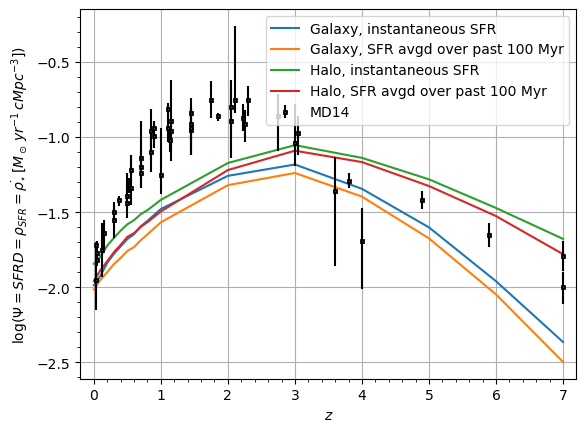

In [16]:
## WRONG

# #fig, ax = plt.subplots()
# plt.clf()
# #plt.xscale('log')
# plt.xlabel(r'$z$')
# plt.xlim(-0.2, 7.2)
# plt.ylabel(r'$\log(\Psi=SFRD=\rho_{SFR}=\dot{\rho_{\star}}\, [M_\odot\, yr^{-1}\, cMpc^{-3}])$')
# plt.title(r'%s' % (cali_num))
# plt.grid()
# plt.minorticks_on()
# plt.plot((redshifts), log_sfrd['gal_inst'], ls='-', label=r'Galaxy, instantaneous SFR')
# plt.plot((redshifts), log_sfrd['gal_100'], ls='-', label=r'Galaxy, SFR avgd over past 100 Myr')
# plt.plot((redshifts), log_sfrd['halo_inst'], ls='-', label=r'Halo, instantaneous SFR')
# plt.plot((redshifts), log_sfrd['halo_100'], ls='-', label=r'Halo, SFR avgd over past 100 Myr')

# plt.errorbar(z_md14, log_sfrd_md14, yerr=(siglo_md14, sighi_md14), label='MD14',
#              marker='s', ms=2, mec='black', mew=2, ecolor='black', ls='')

# plt.legend()
# plt.show()

## Mean Cosmic Specific Star Formation Rate (sSFR = SFR/M*)

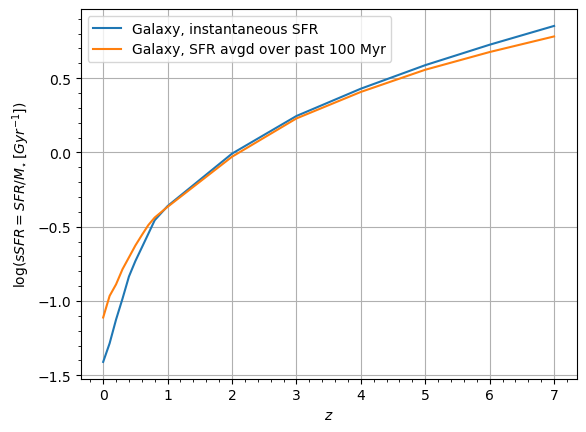

In [58]:
#fig, ax = plt.subplots()
plt.clf()
#plt.xscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$\log(sSFR=SFR/M_{\star}\, [Gyr^{-1}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()
plt.plot((redshifts), log_mean_ssfr['gal_inst'], ls='-', label=r'Galaxy, instantaneous SFR')
plt.plot((redshifts), log_mean_ssfr['gal_100'], ls='-', label=r'Galaxy, SFR avgd over past 100 Myr')
#plt.plot((redshifts), log_mean_ssfr['halo_inst'], ls='-', label=r'Halo, instantaneous SFR')
#plt.plot((redshifts), log_mean_ssfr['halo_100'], ls='-', label=r'Halo, SFR avgd over past 100 Myr')
plt.legend()
plt.show()

## Cosmic Stellar Mass Density (SMD)

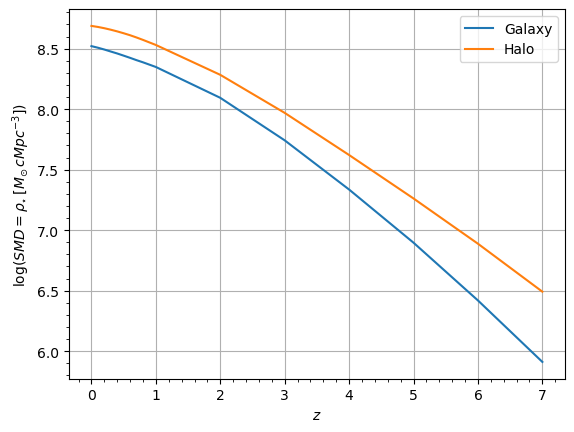

In [59]:
#fig, ax = plt.subplots()
plt.clf()
#plt.xscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$\log(SMD=\rho_{\star}\, [M_{\odot}\, cMpc^{-3}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()
plt.plot((redshifts), log_smd['gal'], ls='-', label=r'Galaxy')
plt.plot((redshifts), log_smd['halo'], ls='-', label=r'Halo')
plt.legend()
plt.show()

## Halo Mass Function (HMF) evolution

KeyError: '6.999999999999995'

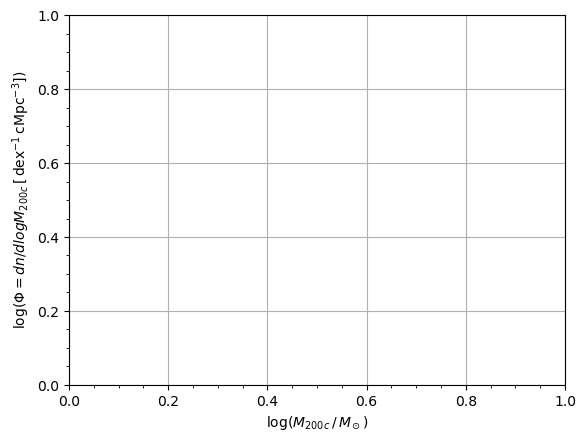

In [60]:
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(M_{200c}\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_{200c}\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()

for redshift in redshifts:
    plt.plot(halo_mass_function[str(redshift)]['x'], halo_mass_function[str(redshift)]['y'], ls='-',
             label=r'$z=%1f$' % redshift)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Galaxy Stellar Mass Function (GSMF) evolution

KeyError: '6.999999999999995'

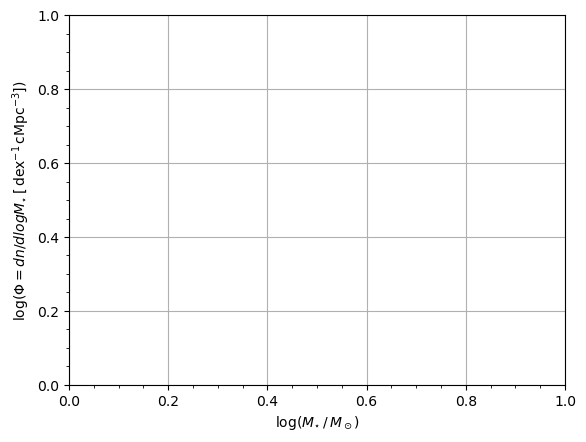

In [61]:
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(M_{\star}\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_{\star}\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()

for redshift in redshifts:
    plt.plot(stellar_mass_function[str(redshift)]['x'], stellar_mass_function[str(redshift)]['y'], ls='-', 
             label=r'$z=%f$' % redshift)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

6.999999999999995
simba_s50n512 (eddington biased)


/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:165: RuntimeWarning: invalid value encountered in subtract
  logPhi_lo_err = np.abs(np.log10(Phi) - np.log10(Phi - Phi_err))
/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:166: RuntimeWarning: invalid value encountered in subtract
  logPhi_hi_err = np.abs(np.log10(Phi) - np.log10(Phi + Phi_err))
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(


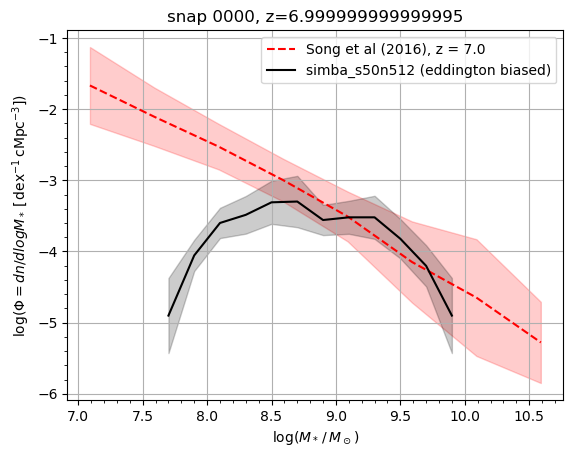

6.000007000006998
simba_s50n512 (eddington biased)


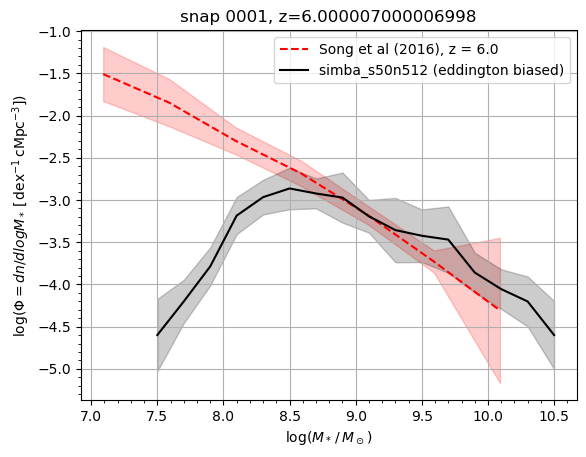

4.999988000023999
simba_s50n512 (eddington biased)


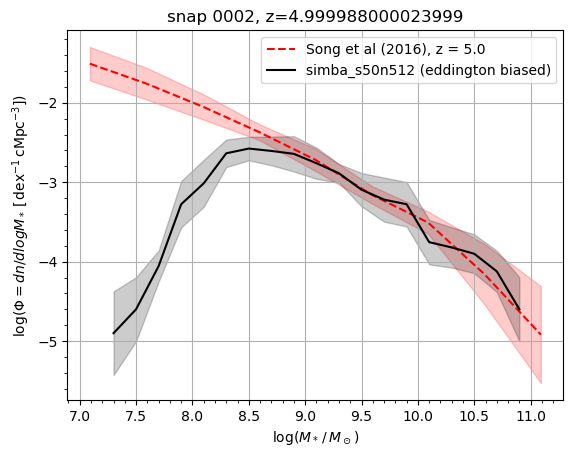

4.0
simba_s50n512 (eddington biased)


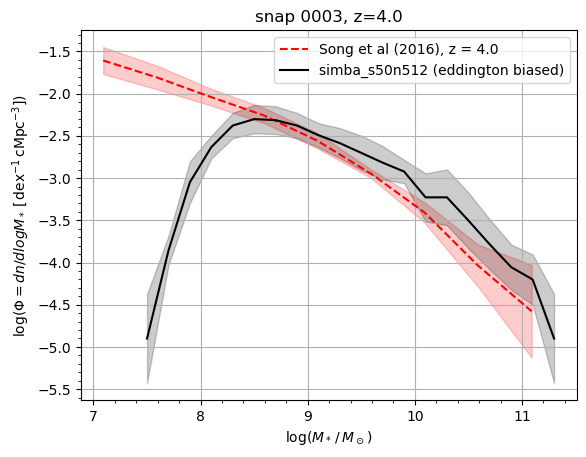

2.9999999999999982
simba_s50n512 (eddington biased)


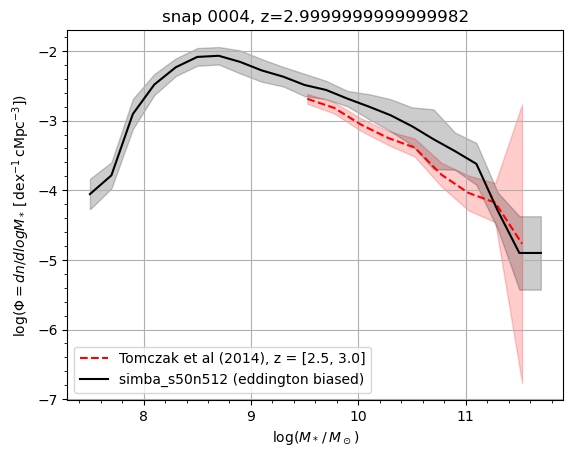

2.0000030000030002
simba_s50n512 (eddington biased)


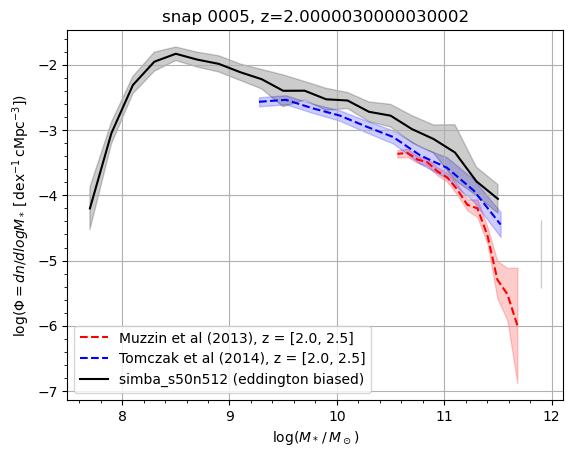

0.9999999999999991
simba_s50n512 (eddington biased)


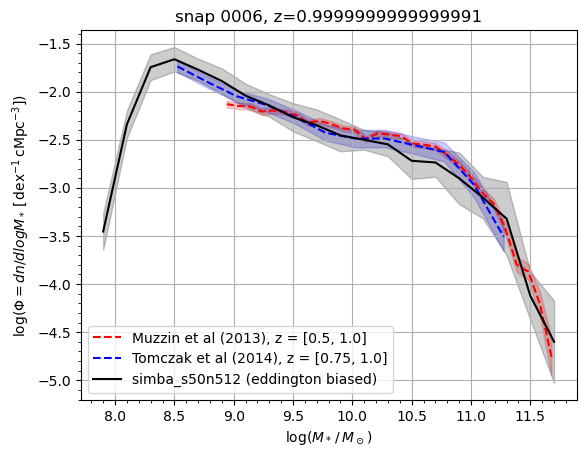

0.7999985600011521
simba_s50n512 (eddington biased)


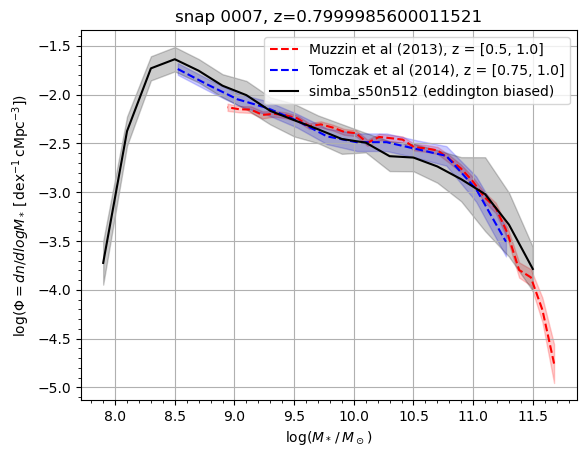

0.7000008500004251
simba_s50n512 (eddington biased)


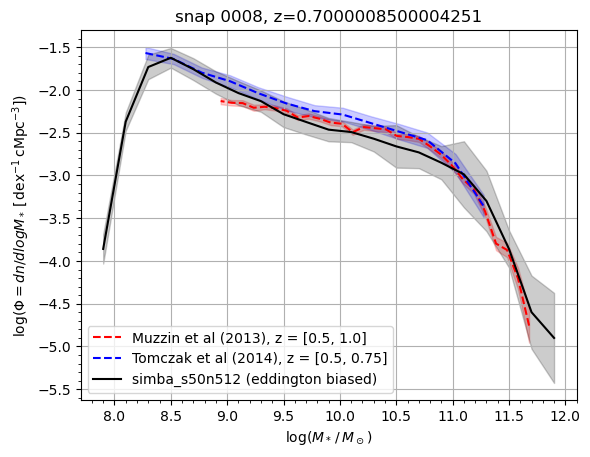

0.5999999999999994
simba_s50n512 (eddington biased)


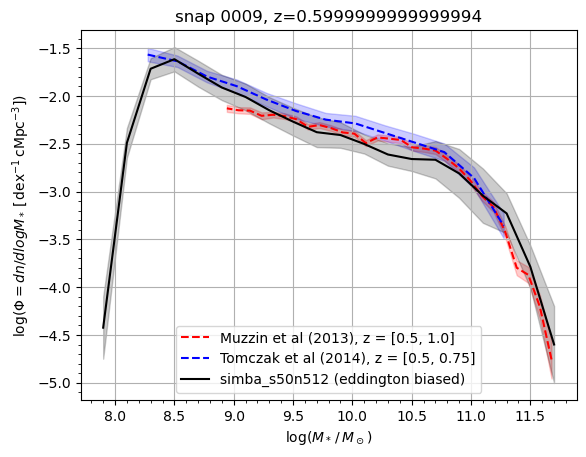

0.4999992500003754
simba_s50n512 (eddington biased)


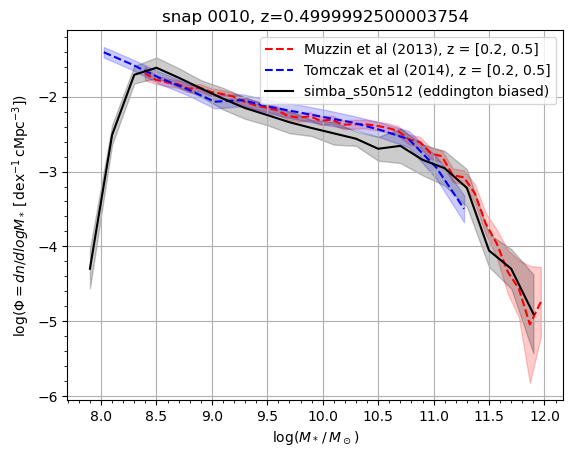

0.399999440000224
simba_s50n512 (eddington biased)


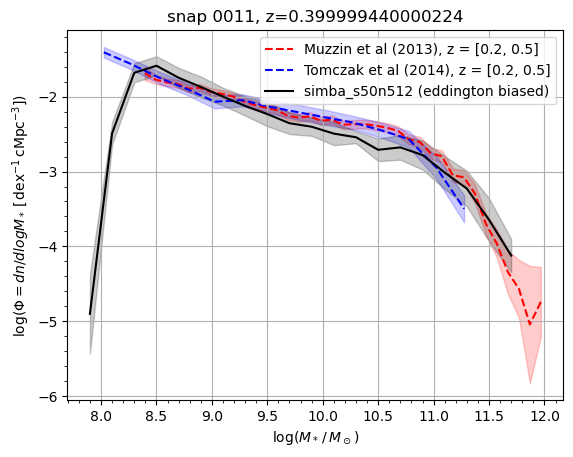

0.2999996100001172
simba_s50n512 (eddington biased)


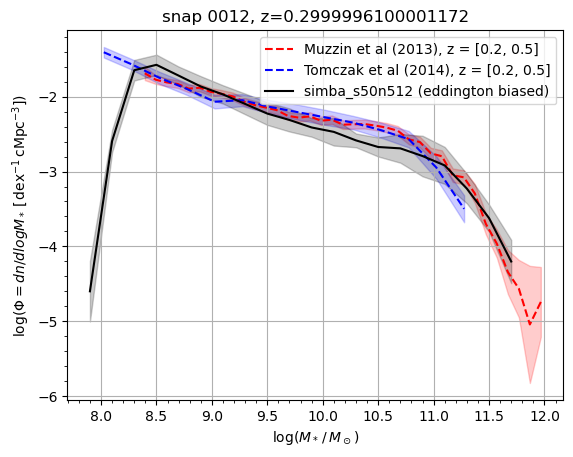

0.20000048000019177
simba_s50n512 (eddington biased)


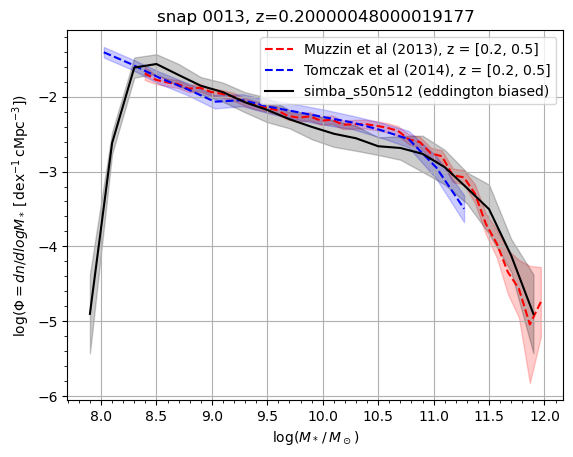

0.09999989000001142
simba_s50n512 (eddington biased)


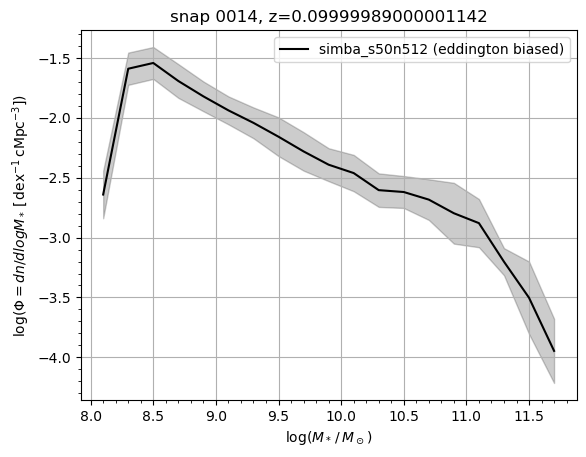

4.440892098500626e-16
simba_s50n512 (eddington biased)


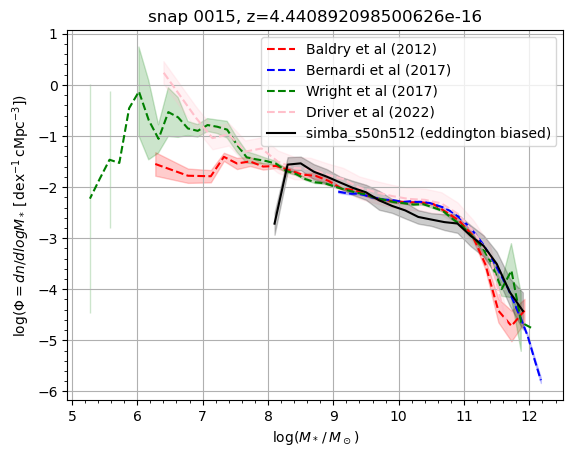

In [149]:
colours_ = ['red', 'blue', 'green', 'pink']
fmt_ = ['--', '--', '--', '--']

for z_, snap_ in zip(redshifts, snap_num_list):
    print(float(z_))

    plt.clf()
    plt.xlabel(r'$\log(M_*\,/\,M_\odot)$')
    plt.ylabel(r'$\log(\Phi=dn/dlogM_*\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    plt.title(r'snap %s, z=%s' % (snap_, z_))
    plt.grid()
    plt.minorticks_on()
    
    
    observations_ = []
    if z_ <= 0.05:
        observations_.append(observational_data['observations']['gsmf']['Baldry+12']['baldry12_gsmf_log_data_corrected.hdf5'])
        observations_.append(observational_data['observations']['gsmf']['Bernardi+17']['bernardi17_z0_gsmf_log_data_corrected.hdf5'])
        observations_.append(observational_data['observations']['gsmf']['Wright+17']['wright17_z0_gsmf_log_data_corrected.hdf5'])
        observations_.append(observational_data['observations']['gsmf']['Driver+22']['driver22_z0_gsmf_log_data_corrected.hdf5'])
    if z_ >= 0.2 and z_ <= 0.5:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[0.2, 0.5]_gsmf_log_data_corrected.hdf5'])
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[0.2, 0.5]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 0.5 and z_ <= 1.0:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[0.5, 1.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.0 and z_ <= 1.5:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[1.0, 1.5]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.5 and z_ <= 2.0:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[1.5, 2.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 2.0 and z_ <= 2.5:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[2.0, 2.5]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.5 and z_ <= 2.0:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[2.5, 3.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.5 and z_ <= 2.0:
        observations_.append(observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z[3.0, 4.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 0.5 and z_ <= 0.75:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[0.5, 0.75]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 0.75 and z_ <= 1.0:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[0.75, 1.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.0 and z_ <= 1.25:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[1.0, 1.25]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.25 and z_ <= 1.5:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[1.25, 1.5]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 1.5 and z_ <= 2.0:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[1.5, 2.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 2.0 and z_ <= 2.5:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[2.0, 2.5]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 2.5 and z_ <= 3.0:
        observations_.append(observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z[2.5, 3.0]_gsmf_log_data_corrected.hdf5'])
    if z_ >= 3.5 and z_ <= 4.5:
        observations_.append(observational_data['observations']['gsmf']['Song+16']['song16_z4.0_gsmf_log_data_corrected.hdf5'])
    if z_ >= 4.5 and z_ <= 5.5:
        observations_.append(observational_data['observations']['gsmf']['Song+16']['song16_z5.0_gsmf_log_data_corrected.hdf5'])
    if z_ >= 5.5 and z_ <= 6.5:
        observations_.append(observational_data['observations']['gsmf']['Song+16']['song16_z6.0_gsmf_log_data_corrected.hdf5'])
    if z_ >= 6.5 and z_ <= 7.5:
        observations_.append(observational_data['observations']['gsmf']['Song+16']['song16_z7.0_gsmf_log_data_corrected.hdf5'])
    if z_ >= 7.5 and z_ <= 8.5:
        observations_.append(observational_data['observations']['gsmf']['Song+16']['song16_z8.0_gsmf_log_data_corrected.hdf5'])
    
    
    
#     elif z_ > 0.15 and z_ <= 0.25:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.2_gsmf_log_data.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z0.35_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 0.25 and z_ <= 0.35:
#         observations_ = [observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z0.35_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.35_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 0.35 and z_ <= 0.55:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.35_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.625_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z0.35_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z0.75_gsmf_log_data.hdf5'],
#                         ]
#     elif z_ > 0.55 and z_ <= 0.95:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.625_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.875_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z0.75_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 0.95 and z_ <= 1.5:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.625_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z0.875_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z1.125_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z1.25_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 1.5 and z_ <= 2.5:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z2.0_gsmf_log_data.hdf5'],
#                          observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z2.5_gsmf_log_data.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z1.75_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z2.25_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 2.5 and z_ <= 3.5:
#         observations_ = [observational_data['observations']['gsmf']['Tomczak+14']['tomczak14_z3.0_gsmf_log_data.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z2.75_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z3.5_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 3.5 and z_ <= 4.5:
#         observations_ = [observational_data['observations']['gsmf']['Muzzin+13']['muzzin13_z3.5_gsmf_log_data_corrected.hdf5'],
#                          observational_data['observations']['gsmf']['Song+16']['song16_z4.0_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 4.5 and z_ <= 5.5:
#         observations_ = [observational_data['observations']['gsmf']['Song+16']['song16_z5.0_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 5.5 and z_ <= 6.5:
#         observations_ = [observational_data['observations']['gsmf']['Song+16']['song16_z6.0_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 6.5 and z_<= 7.5:
#         observations_ = [observational_data['observations']['gsmf']['Song+16']['song16_z7.0_gsmf_log_data_corrected.hdf5'],
#                         ]
#     elif z_ > 7.5 and z_<= 8.5:
#         observations_ = [observational_data['observations']['gsmf']['Song+16']['song16_z8.0_gsmf_log_data_corrected.hdf5'],
#                         ]
    
    

    for ii in range(len(observations_)):
#         print('hi')
#         plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
#                      xerr=observations_[ii].x_scatter.value, yerr=observations_[ii].y_scatter.value, 
#                      label=observations_[ii].citation, 
#                      fmt=fmt_[ii], color=colours_[ii])
    #     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
    #                  xerr=None, yerr=None, 
    #                  label=observations_[ii].citation, 
    #                  fmt=fmt_[ii], color=colours_[ii])
    
        plt.plot(observations_[ii].x.value, observations_[ii].y.value, 
                 label=observations_[ii].citation, 
                 ls=fmt_[ii], color=colours_[ii])
        plt.fill_between(observations_[ii].x.value, 
                         observations_[ii].y.value - observations_[ii].y_scatter.value[0],
                         observations_[ii].y.value + observations_[ii].y_scatter.value[0],
                         color=colours_[ii], alpha=0.2)
    
    
    
    
    
#     smf = obs.SMF(z_)
#     if smf.cond: plt.errorbar(smf.x, smf.y, yerr=smf.yerr, label='%s (z=%s)' % (smf.name, smf))
    
    
    
    
    # Add eddington bias to calculated/measured/observed stellar masses (for GSMF only?)
    # See Kugel+23 (FLAMINGO: Calibrating large cosmological hydrodynamical simulations with machine learning)
    # Section 3.1.1 eqn 11

    rng_ = np.random.default_rng()
    mu_eddington_ = 0
    sigma_eddington_ = min(0.070+0.071*z_, 0.3) # dex
    # print(sigma_eddington)
    # eddington_bias = rng.lognormal(mean=mu_eddington, sigma=sigma_eddington)#, size=1)
    eddington_bias_ = rng_.normal(loc=mu_eddington_, scale=sigma_eddington_, size=len(log_gal_masses['stellar'][str(z_)]))
#     len(eddington_bias)

    # print([rng.normal(loc=mu_eddington, scale=sigma_eddington) for i in range(5)])

    log_gal_stellar_masses_eddington_biased_ = log_gal_masses['stellar'][str(z_)] + eddington_bias_
    # print(log_gal_stellar_masses)
    # print(log_gal_stellar_masses_for_gsmf)
    gal_stellar_masses_eddington_biased_ = 10**log_gal_stellar_masses_eddington_biased_
    



    props = [gal_stellar_masses_eddington_biased_]#, gal_stellar_masses]
    # prop_names = ['%s (eddington biased)' % snap_prefix, snap_prefix]
    plot_props = [{'label':'%s (eddington biased)' % snap_prefix,'color':'black', 'fmt':'-'}, 
    #               {'label':snap_prefix, 'color':'grey', 'fmt':'-'}
                 ]

    for prop, plot_prop in zip(props, plot_props):
        print(plot_prop['label'])
        logM_ax, logPhi, logPhi_total_lo_err, logPhi_total_hi_err, logPhi_total_err, logPhi_total_err_v2 = gen.mass_function_with_error(
            prop, box_info['gal_pos_Mpc'][str(z_)], box_info['boxsize'][str(z_)], box_info['Vcom'][str(z_)], 
            dlogM=0.2, min_logM=6, max_logM=14, calc_min_logM=False, calc_max_logM=False)

    #     isfinite = np.isfinite(logPhi)
    #     logM_ax = logM_ax[isfinite]
    #     logPhi = logPhi[isfinite]
    #     logPhi_total_lo_err = logPhi_total_lo_err[isfinite]
    #     logPhi_total_hi_err = logPhi_total_hi_err[isfinite]
    #     logPhi_total_err = logPhi_total_err[isfinite]

    #     plt.errorbar(logM_ax, logPhi, yerr=logPhi_total_err, 
    #                  color=plot_prop['color'], fmt=plot_prop['fmt'], label=plot_prop['label'])
        plt.errorbar(logM_ax, logPhi, yerr=None, 
                     color=plot_prop['color'], fmt=plot_prop['fmt'], label=plot_prop['label'])
        plt.fill_between(logM_ax, logPhi-logPhi_total_err, logPhi+logPhi_total_err, color=plot_prop['color'], alpha=0.2)
    #     plt.fill_between(logM_ax, logPhi-logPhi_total_lo_err, logPhi+logPhi_total_hi_err, color=plot_prop['color'], alpha=0.2)


    plt.legend()
    plt.show()

## Galaxy Star Formation Rate Function (SFRF) evolution

KeyError: '6.999999999999995'

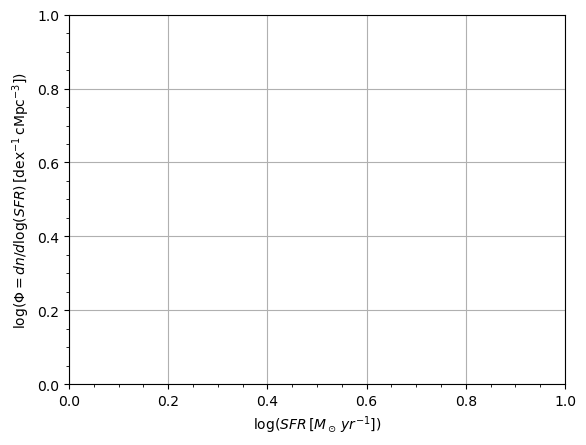

In [76]:
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(SFR\,[M_\odot\, yr^{-1}])$')
plt.ylabel(r'$\log(\Phi=dn/d\log(SFR)\,[\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()

for redshift in redshifts:
    plt.plot(sfr_function[str(redshift)]['x'], sfr_function[str(redshift)]['y'], ls='-', 
             label=r'$z=%f$' % redshift)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Stellar mass-BH mass relation (SMBHM)

In [ ]:
# plt.clf()

# for redshift in redshifts:

## sSFR histograms and Quenched Fractions

z = 6.999999999999995 :



/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:229: RuntimeWarning: invalid value encountered in divide
  frac = counts/len(log_ssfr_curr)
/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:231: RuntimeWarning: invalid value encountered in divide
  poisson_err /= len(log_ssfr_curr)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


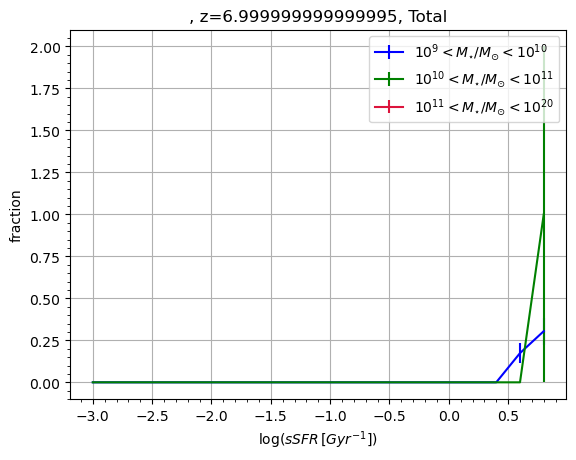

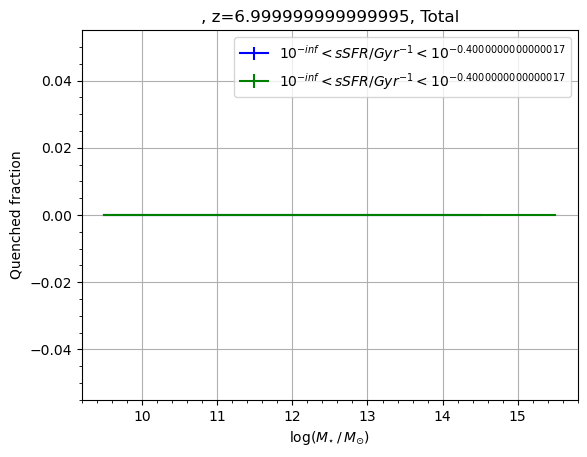

z = 6.000007000006998 :



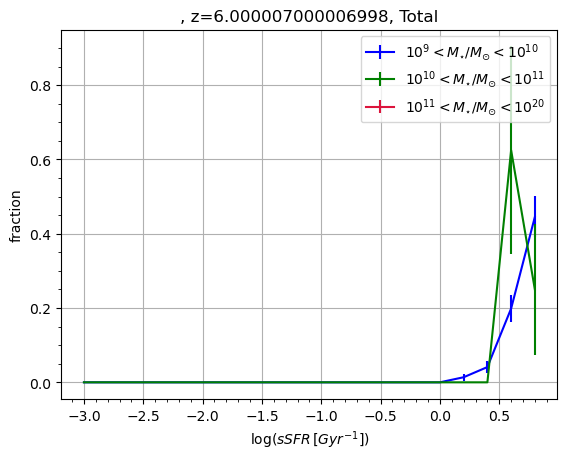

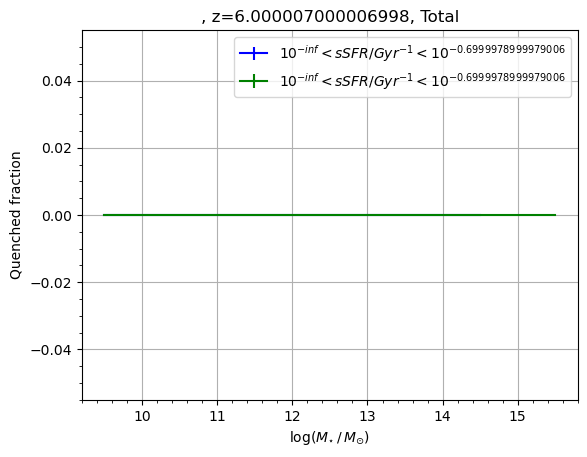

z = 4.999988000023999 :



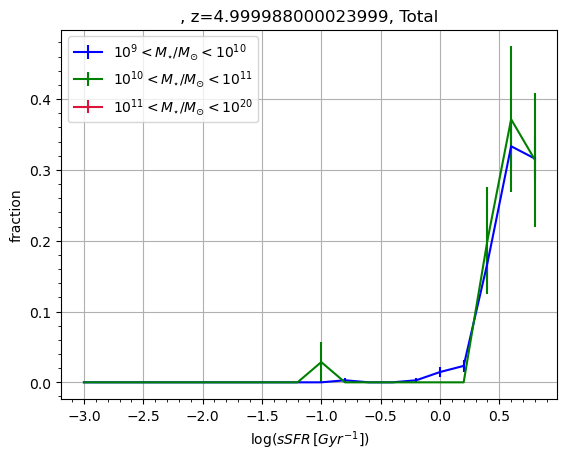

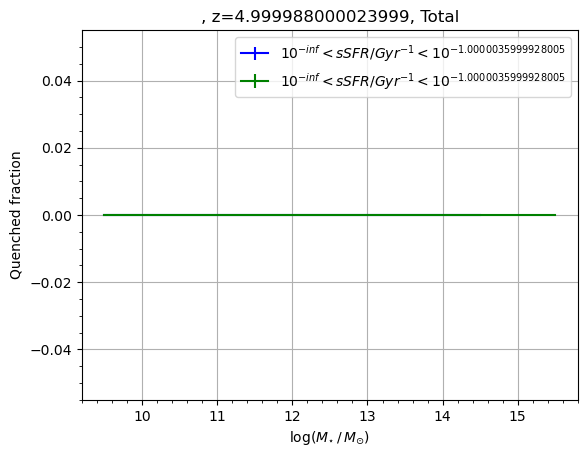

z = 4.0 :



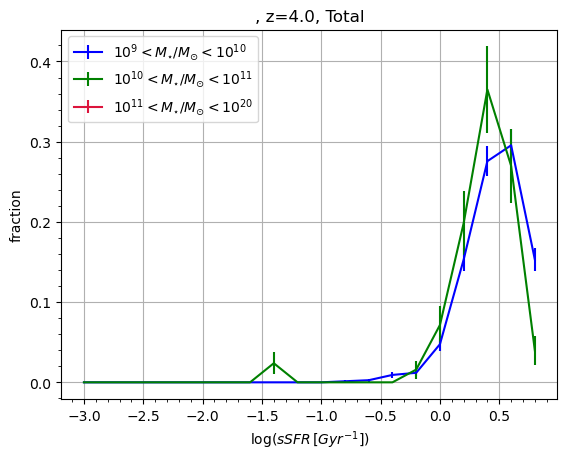

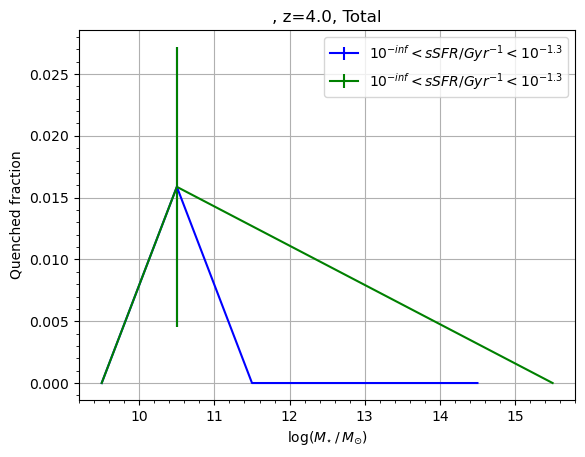

z = 2.9999999999999982 :



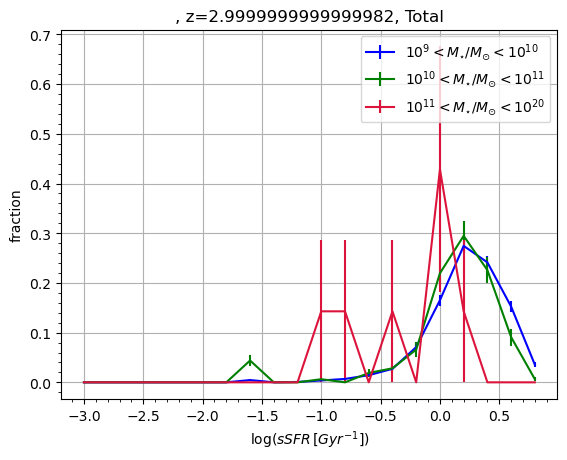

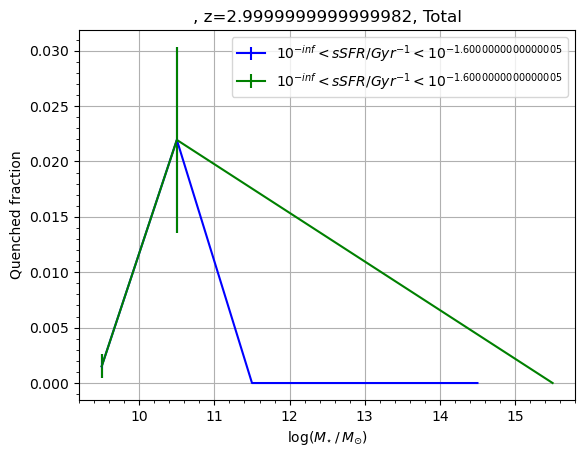

z = 2.0000030000030002 :



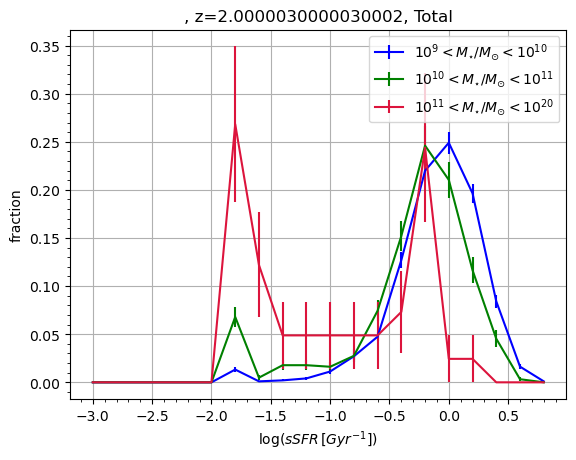

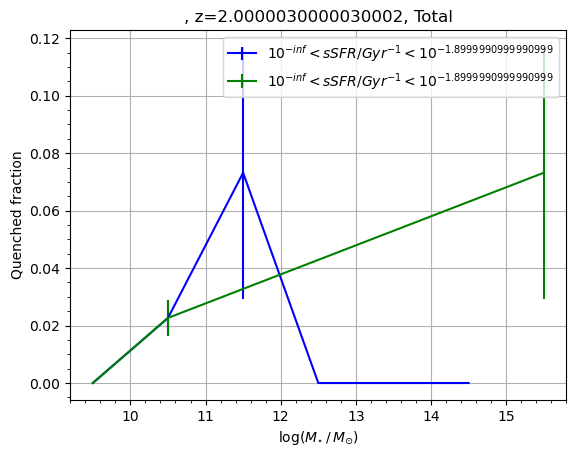

z = 0.9999999999999991 :



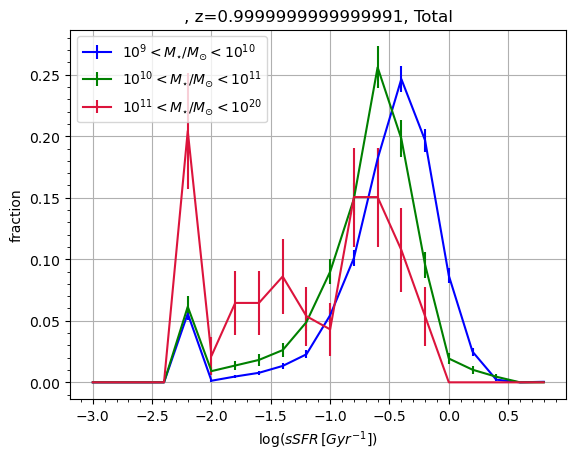

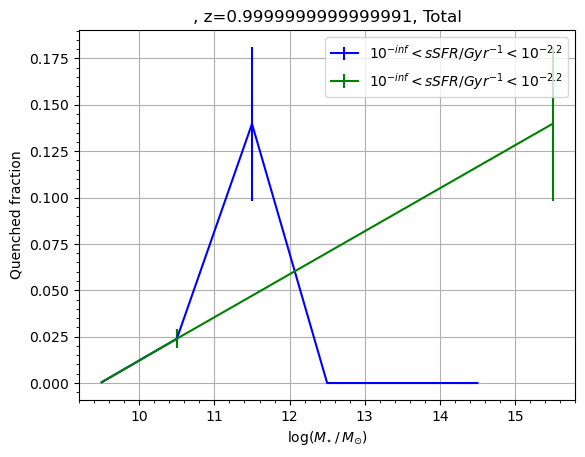

z = 0.7999985600011521 :



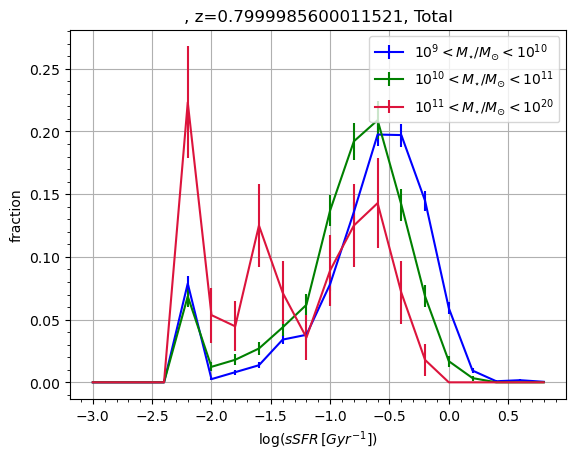

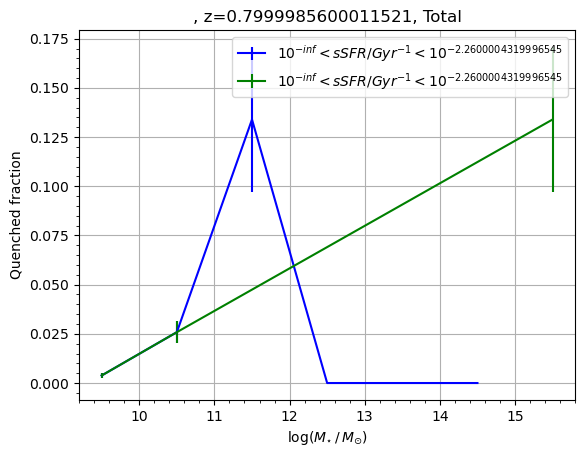

z = 0.7000008500004251 :



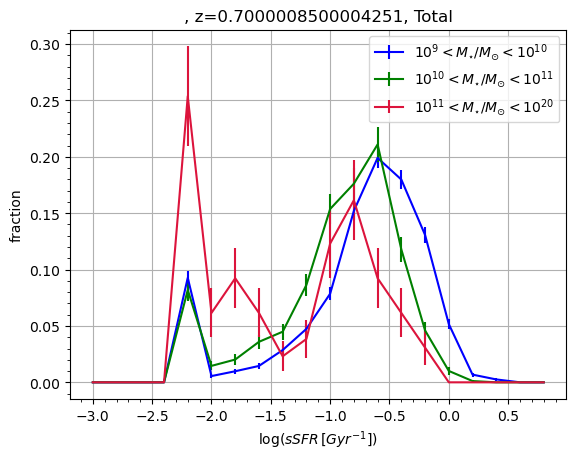

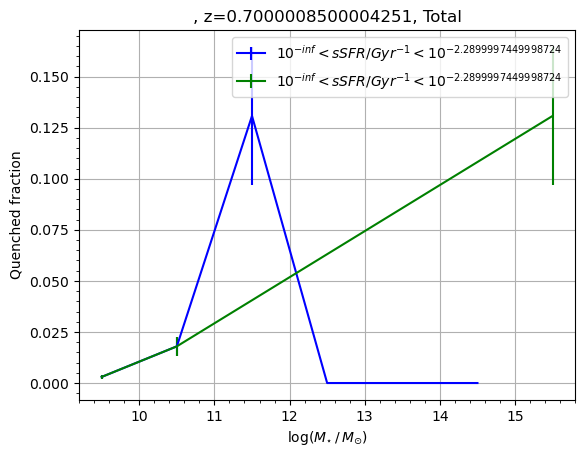

z = 0.5999999999999994 :



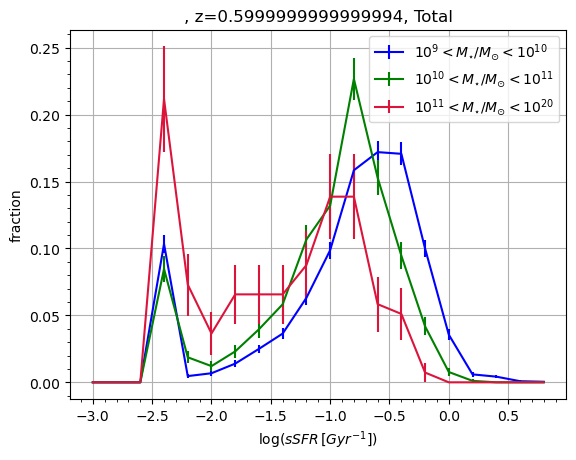

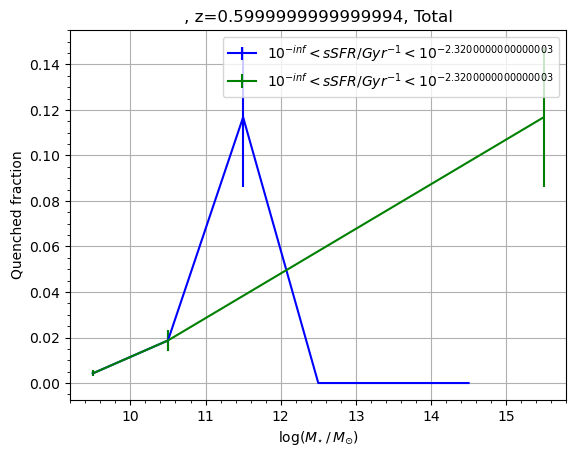

z = 0.4999992500003754 :



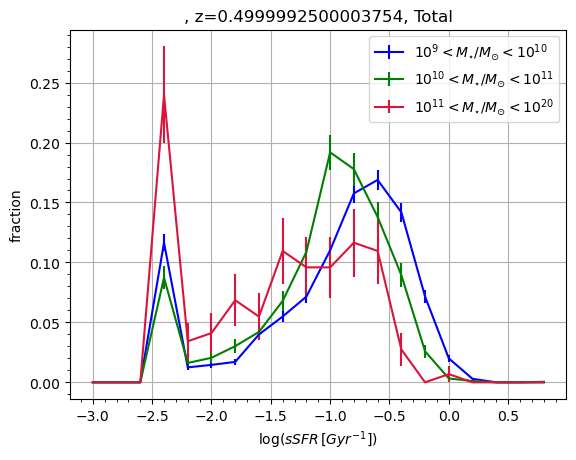

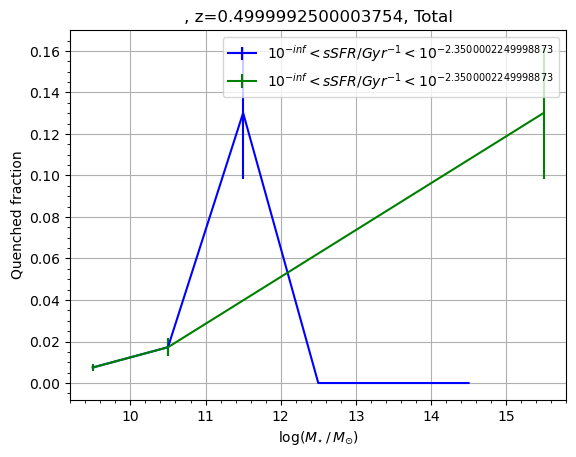

z = 0.399999440000224 :



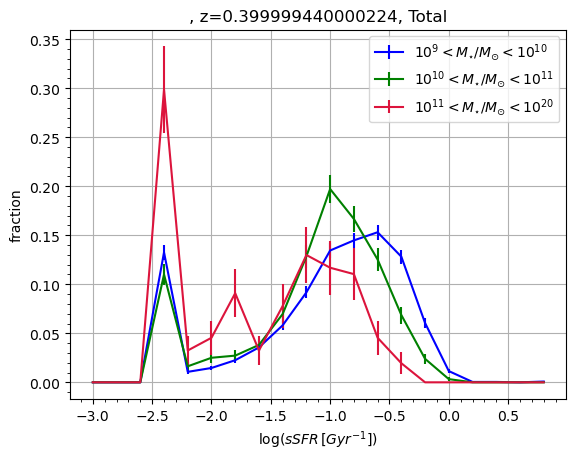

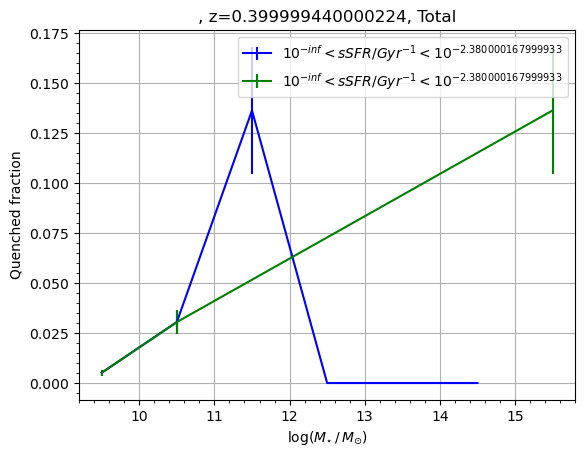

z = 0.2999996100001172 :



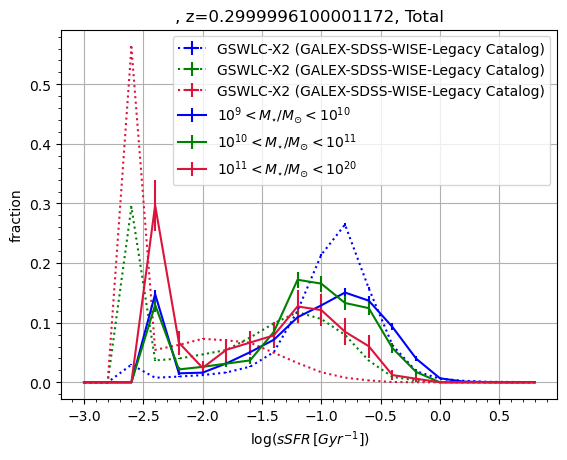

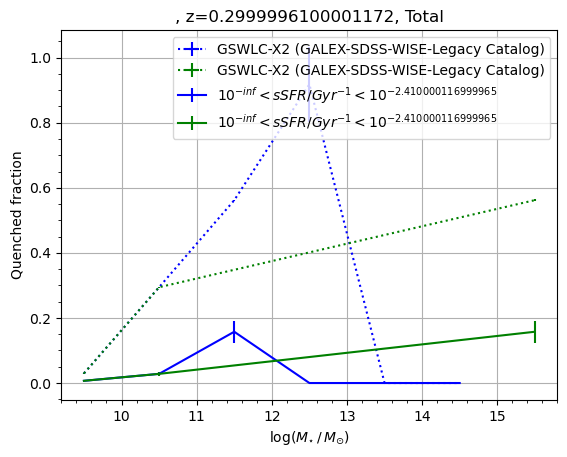

z = 0.20000048000019177 :



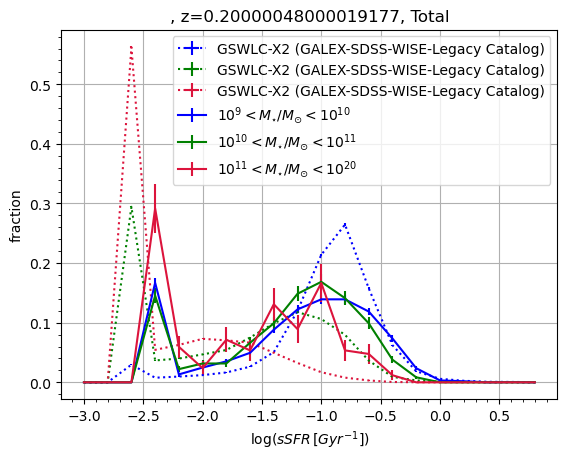

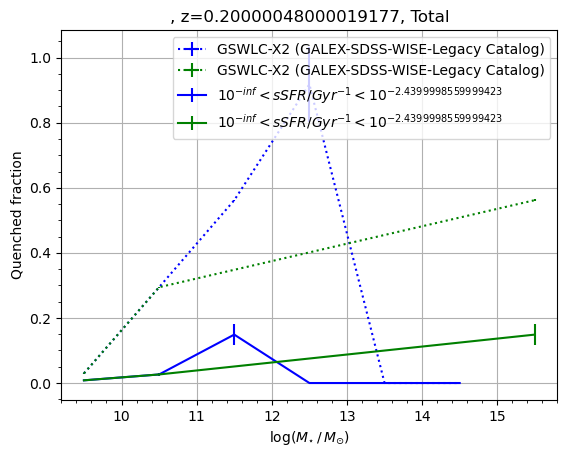

z = 0.09999989000001142 :



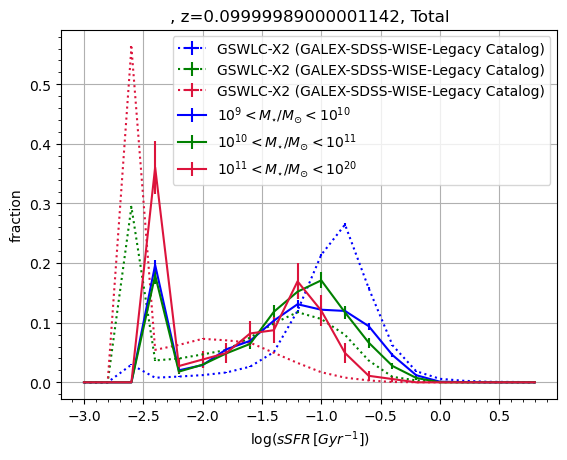

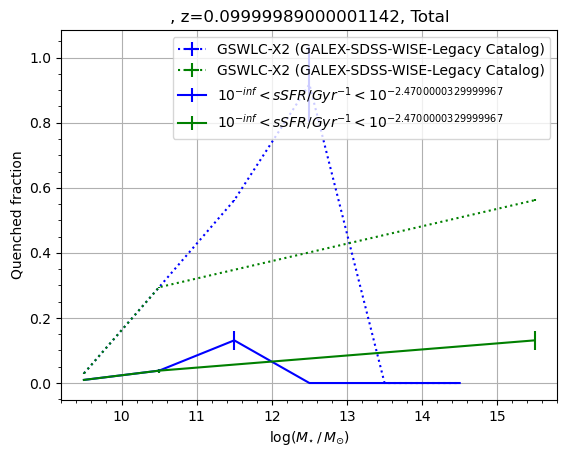

z = 4.440892098500626e-16 :



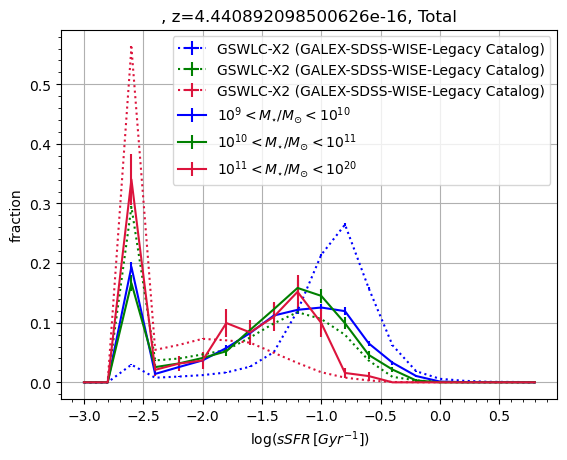

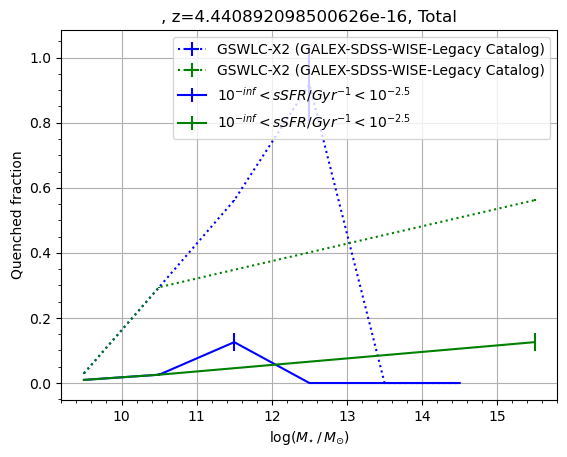

In [150]:
# How to deal with non-finite ssfrs? include in denominator of fraction?
# For poisson error, should I incorporate the poisson error in the total count (ie the denominator in the fraction)?

# N_bins_ssfr_hist_sf = 16
# plt.clf()

# x_units = unyt.Gyr**(-1)
# y_units = unyt.dimensionless

# x_label = r'$\log(sSFR\,[Gyr^{-1}])$'
# y_label = r'fraction'

colors = ['b', 'g', 'crimson', 'm', 'r', 'y', 'k']
fmt = ['-', '-', '-', '-', '-']

obs_colours_ = ['blue', 'green', 'crimson', 'red', 'pink']
obs_fmt_ = [':', ':', ':', ':']

# logM_bins_ssfr_hist = np.array([9, 10, 11, 20])
# # log_ssfr_bins = np.arange(-3, 1, 0.2)
# log_ssfr_bins_ssfr_hist = np.arange(-3.1, 1, 0.2)

# for redshift_, Vcom, boxsize, gal_pos_Mpc in (redshift_s, volumes_com, boxsizes, gal_positions_Mpc):
for redshift_ in redshifts:
    print('z =', redshift_, ':')
    print()
    
    
    
    if redshift_ >= 0 and redshift_ <= 0.3:
        observations_ssfr_hist_ = [observational_data['observations']['ssfr']['gswlc-x2']['gswlc-x2_ssfr_ssfr_hist_bin_0.hdf5'],
                         observational_data['observations']['ssfr']['gswlc-x2']['gswlc-x2_ssfr_ssfr_hist_bin_1.hdf5'],
                         observational_data['observations']['ssfr']['gswlc-x2']['gswlc-x2_ssfr_ssfr_hist_bin_2.hdf5'],
                        ]
        
        observations_quenched_frac_ = [observational_data['observations']['ssfr']['gswlc-x2']['gswlc-x2_ssfr_quenched_fraction.hdf5'],
                         observational_data['observations']['ssfr']['gswlc-x2']['gswlc-x2_ssfr_quenched_fraction_v2.hdf5'],
                        ]
    else:
        observations_ssfr_hist_ = []
        observations_quenched_frac_ = []
    
    
    
    
    
    log_ssfr_lim_ = -2.5 + 0.3*redshift_
    
    
    log_Mstar_ = log_gal_masses['stellar'][str(redshift_)]
#     log_Mstar_central_ = log_gal_masses['central_stellar'][str(redshift_)]
#     log_Mstar_sat_ = log_gal_masses['satellite_stellar'][str(redshift_)]
    
    log_ssfr_ = log_ssfr['gal_inst'][str(redshift_)]
#     log_ssfr_central_ = log_ssfr['gal_central_inst'][str(redshift_)]
#     log_ssfr_sat_ = log_ssfr['gal_sat_inst'][str(redshift_)]


    
    
    # sSFR Histograms
    logM_bins_ = np.array([9, 10, 11, 20])
#     # log_ssfr_bins_ = np.arange(-3, 1, 0.2)
    log_ssfr_bins_ = np.arange(-3.1, 1, 0.2)
# #     print(log_ssfr_bins_)
    log_ssfr_lim_ = -2.5 + 0.3*redshift_
    
    log_ssfr_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_, log_ssfr_, log_ssfr_lim=log_ssfr_lim_)
#     log_ssfr_central_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_central_, log_ssfr_central_, log_ssfr_lim=log_ssfr_lim_)
#     log_ssfr_sat_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_sat_, log_ssfr_sat_, log_ssfr_lim=log_ssfr_lim_)
    
    
    plt.clf()
    plt.xlabel(r'$\log(sSFR\,[Gyr^{-1}])$')
    plt.ylabel(r'fraction')
    plt.title(r'%s, z=%s, Total' % (cali_num, redshift_))
    plt.grid()
    plt.minorticks_on()
    
    for ii in range(len(observations_ssfr_hist_)):
        plt.errorbar(observations_ssfr_hist_[ii].x.value, observations_ssfr_hist_[ii].y.value, 
                     xerr=observations_ssfr_hist_[ii].x_scatter.value, yerr=observations_ssfr_hist_[ii].y_scatter.value, 
                     label=observations_ssfr_hist_[ii].citation, 
                     fmt=obs_fmt_[ii], color=obs_colours_[ii])
    #     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
    #                  xerr=None, yerr=None, 
    #                  label=observations_[ii].citation, 
    #                  fmt=fmt_[ii], color=colours_[ii])
    
    
    for ii in range(len(log_ssfr_hists_)):
        plt.errorbar(log_ssfr_hists_[ii][0], log_ssfr_hists_[ii][1], 
                     yerr=log_ssfr_hists_[ii][2], fmt=fmt[ii], color=colors[ii],
                     label=r'$10^{%s} < M_{\star}/M_{\odot} < 10^{%s}$' % (logM_bins_[ii], logM_bins_[ii+1]))
    plt.legend()
    plt.show()
    
    
    
    
    
    # Quenched fraction plotted as a function of stellar mass
    # log_ssfr_bins_ = np.array([-np.inf, -2.5, np.inf])
    log_ssfr_bins_ = np.array([-np.inf, log_ssfr_lim_])
    logM_bins_ = np.array([9, 10, 11, 20])
    
    quenched_fraction_ = gen.ssfr_fraction_func(log_Mstar_, log_ssfr_, log_ssfr_bins_, dlogM=1, 
                                                min_logM=9, max_logM=15, calc_min_logM=False, calc_max_logM=False)
#     quenched_fraction_central_ = gen.ssfr_fraction_func(log_Mstar_central_, log_ssfr_central_, log_ssfr_bins_, dlogM=0.5, 
#                                                 min_logM=9, max_logM=13, calc_min_logM=False, calc_max_logM=False)
#     quenched_fraction_sat_ = gen.ssfr_fraction_func(log_Mstar_sat_, log_ssfr_sat_, log_ssfr_bins_, dlogM=0.5, 
#                                                 min_logM=9, max_logM=13, calc_min_logM=False, calc_max_logM=False)
    
    quenched_fraction_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_, log_ssfr_, logM_bins_, log_ssfr_bins_)
#     quenched_fraction_central_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_central_, log_ssfr_central_, logM_bins_, log_ssfr_bins_)
#     quenched_fraction_sat_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_sat_, log_ssfr_sat_, logM_bins_, log_ssfr_bins_)
    
    
    plt.clf()
    plt.xlabel(r'$\log(M_{\star}\,/\,M_{\odot})$')
    plt.ylabel(r'Quenched fraction')
    plt.title(r'%s, z=%s, Total' % (cali_num, redshift_))
    plt.grid()
    plt.minorticks_on()
    
    
    for ii in range(len(observations_quenched_frac_)):
        plt.errorbar(observations_quenched_frac_[ii].x.value, observations_quenched_frac_[ii].y.value, 
                     xerr=observations_quenched_frac_[ii].x_scatter.value, yerr=observations_quenched_frac_[ii].y_scatter.value, 
                     label=observations_quenched_frac_[ii].citation, 
                     fmt=obs_fmt_[ii], color=obs_colours_[ii])
    #     plt.errorbar(observations_[ii].x.value, observations_[ii].y.value, 
    #                  xerr=None, yerr=None, 
    #                  label=observations_[ii].citation, 
    #                  fmt=fmt_[ii], color=colours_[ii])
    
    
    for ii in range(len(quenched_fraction_)):
        plt.errorbar(quenched_fraction_[ii][0], quenched_fraction_[ii][1], 
                     yerr=quenched_fraction_[ii][2], fmt=fmt[ii], color='blue',
                     label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
        
    for ii in range(len(quenched_fraction_v2_)):
        plt.errorbar(quenched_fraction_v2_[ii][0], quenched_fraction_v2_[ii][1], 
                     yerr=quenched_fraction_v2_[ii][2], fmt=fmt[ii], color='green',
                     label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
    
    plt.legend()
    plt.show()

z = 6.999999999999995 :



/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:314: RuntimeWarning: invalid value encountered in divide
  frac = counts/len(log_ssfr_curr)
/gpfs/fs1/home/b/babul/aspadawe/scripts/gen_sim_data.py:316: RuntimeWarning: invalid value encountered in divide
  poisson_err /= len(log_ssfr_curr)
/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


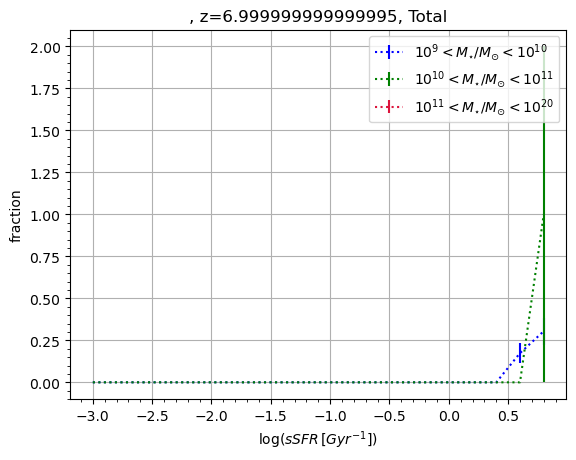

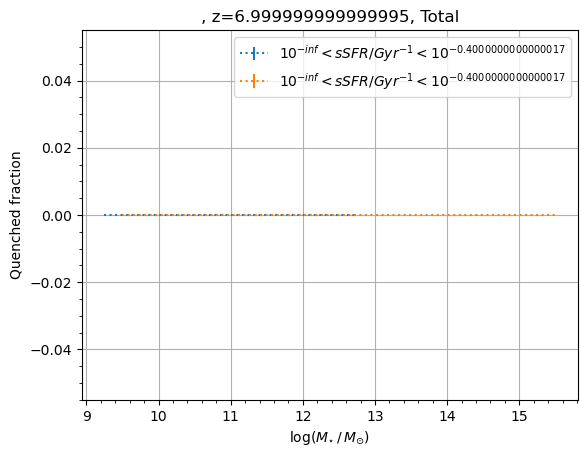

z = 6.000007000006998 :



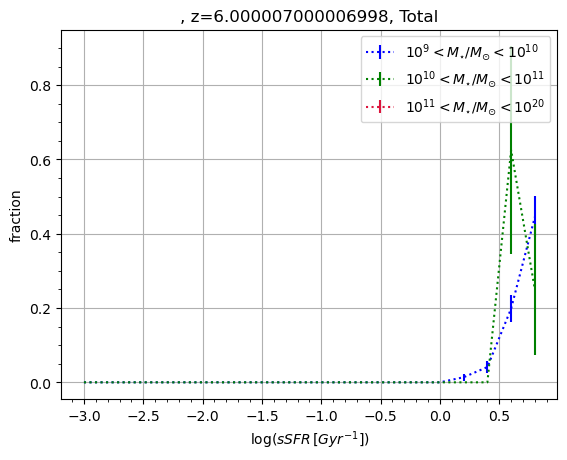

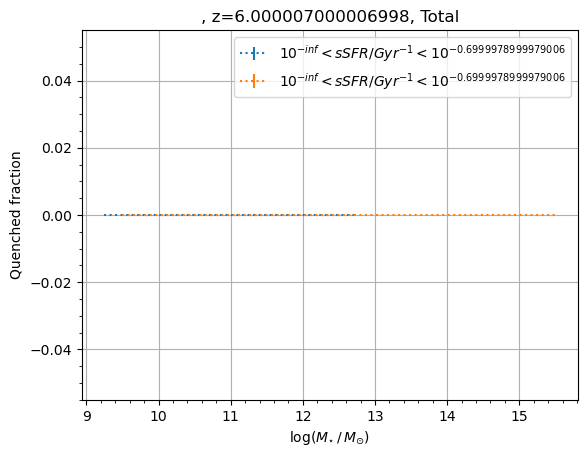

z = 4.999988000023999 :



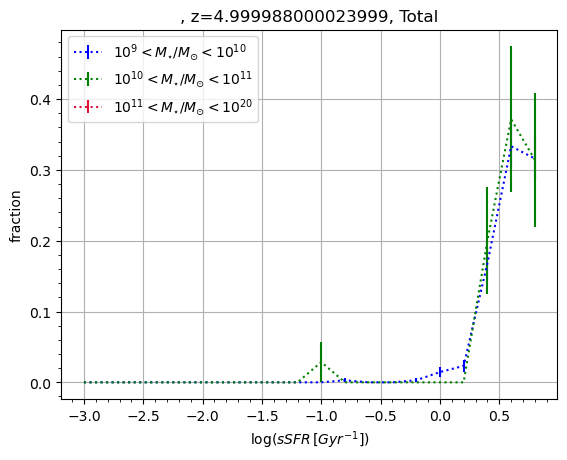

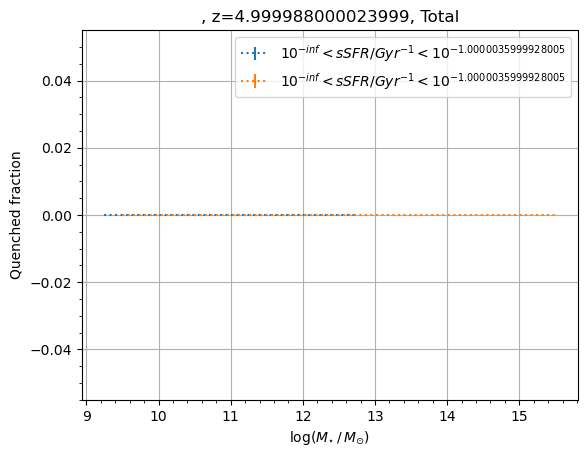

z = 4.0 :



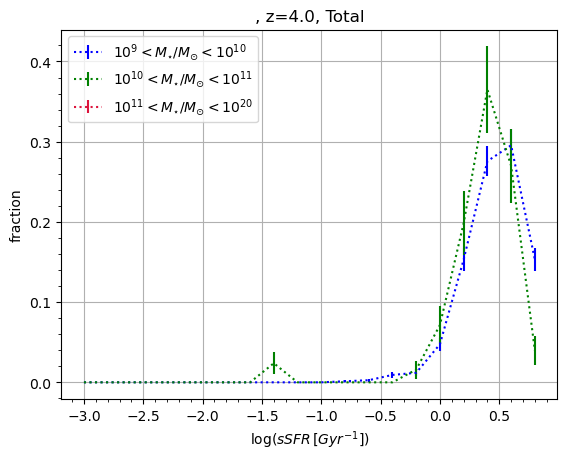

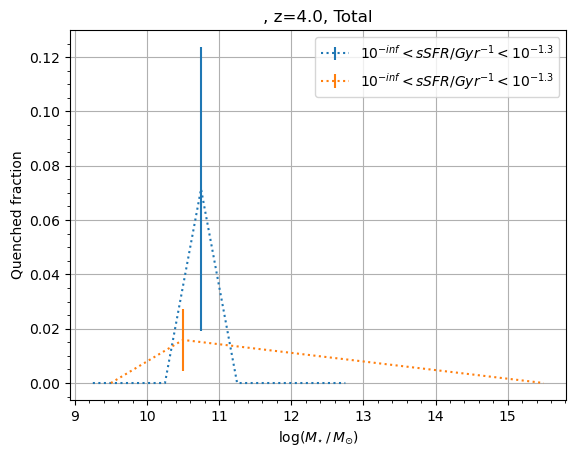

z = 2.9999999999999982 :



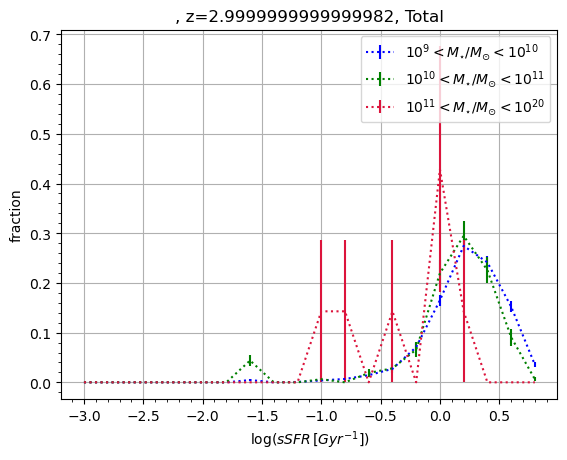

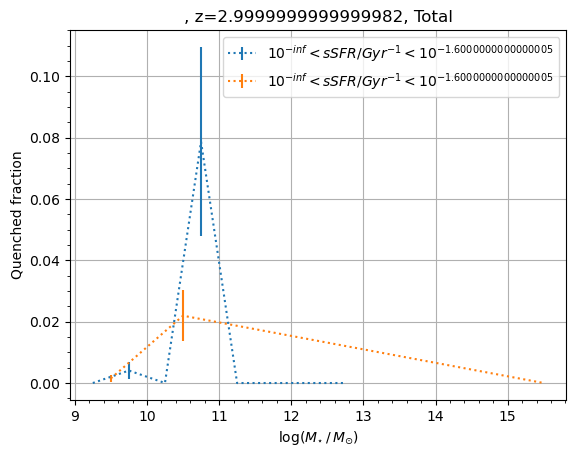

z = 2.0000030000030002 :



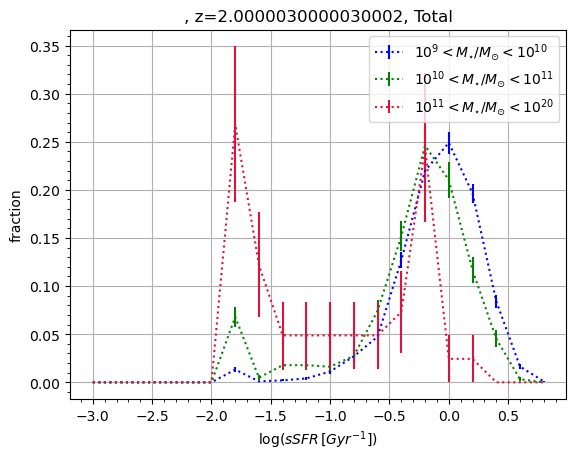

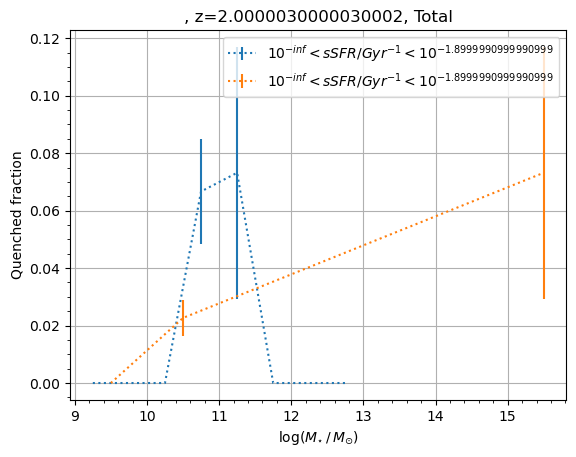

z = 0.9999999999999991 :



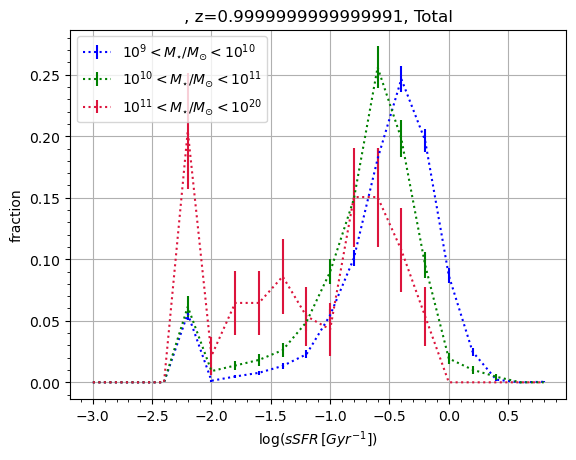

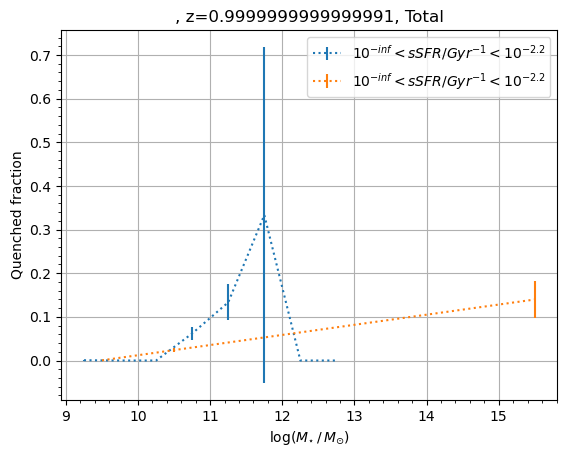

z = 0.7999985600011521 :



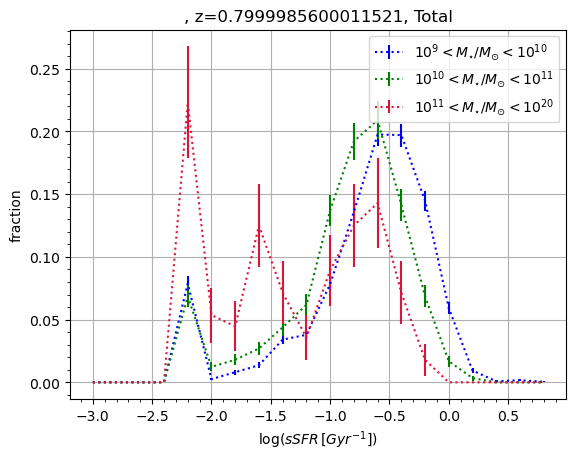

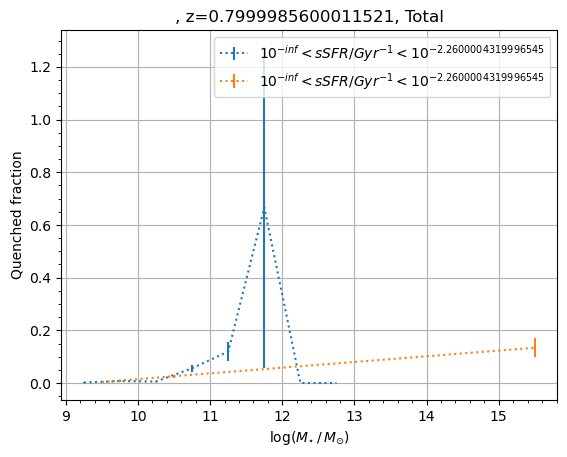

z = 0.7000008500004251 :



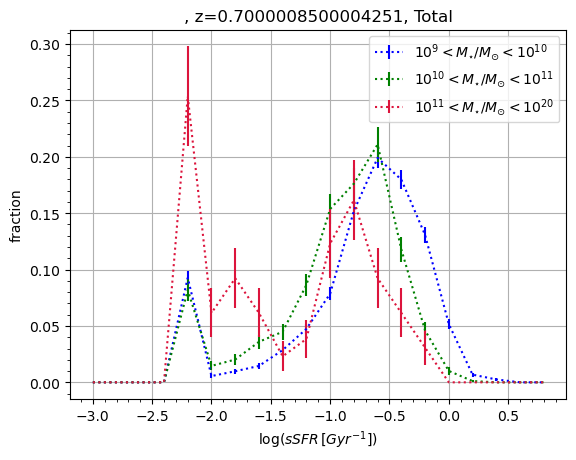

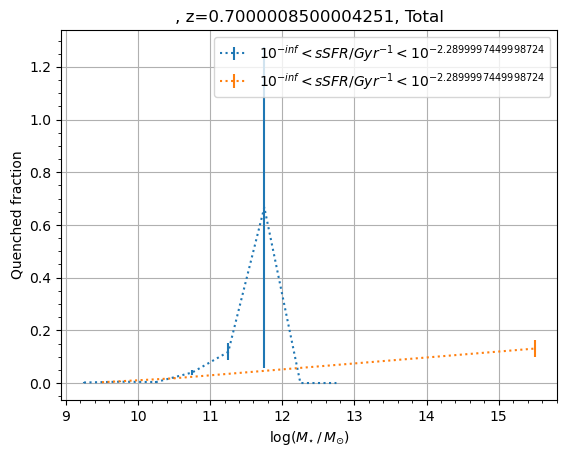

z = 0.5999999999999994 :



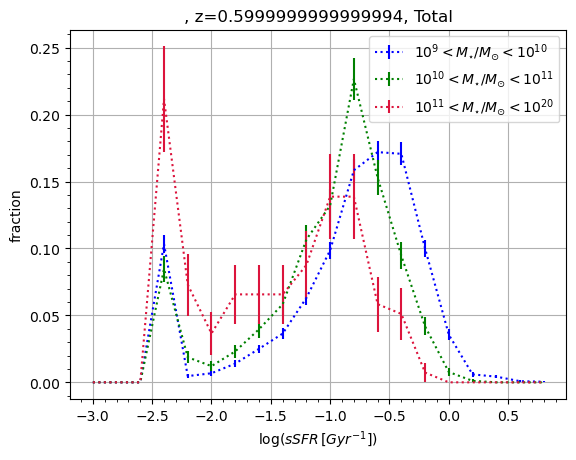

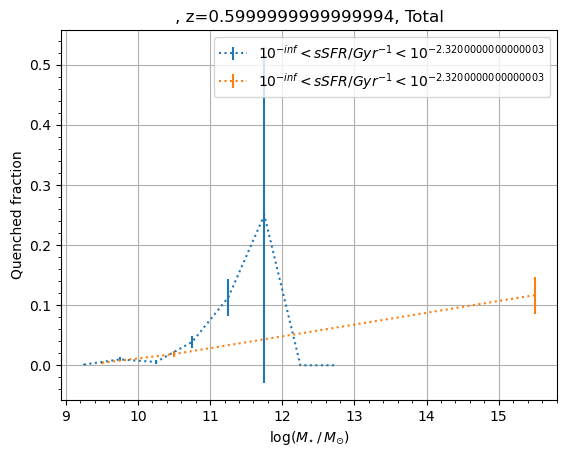

z = 0.4999992500003754 :



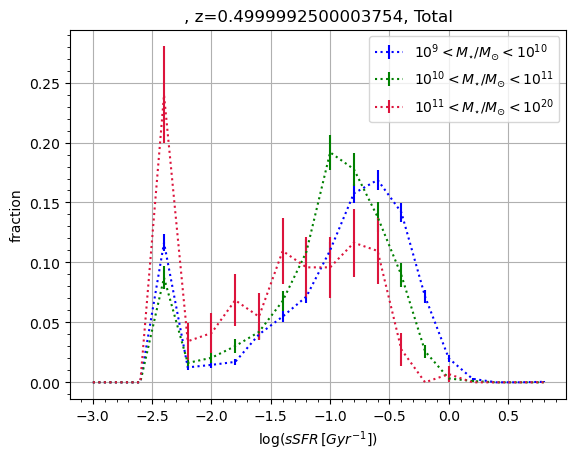

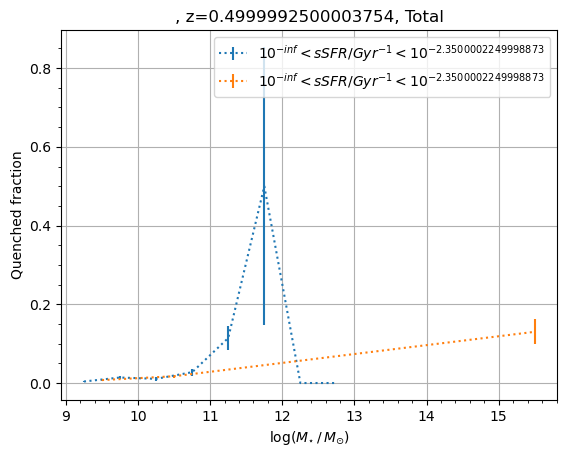

z = 0.399999440000224 :



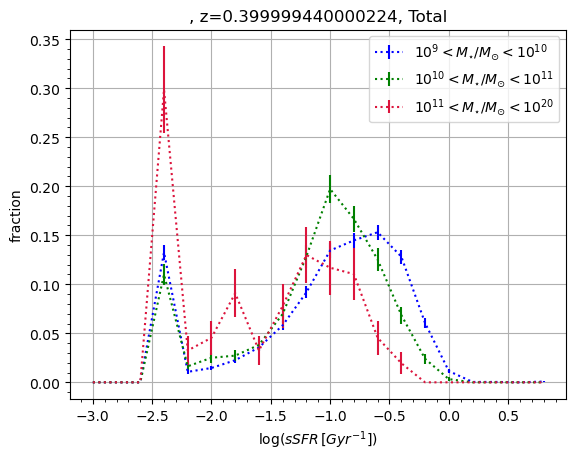

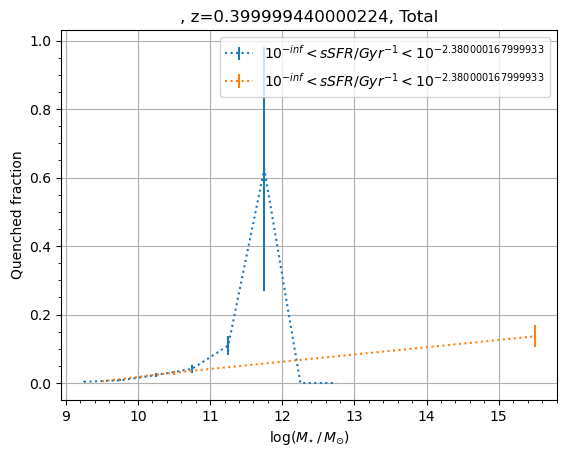

z = 0.2999996100001172 :



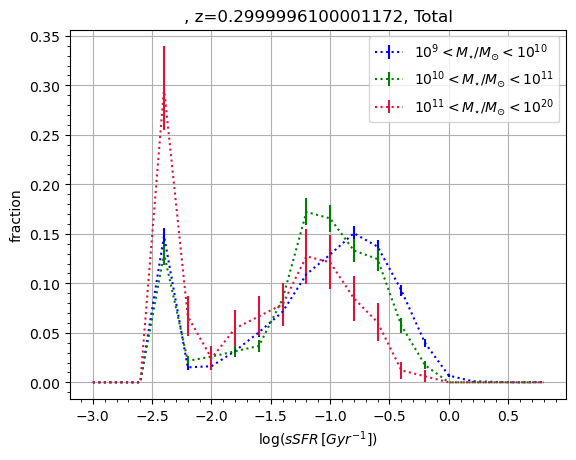

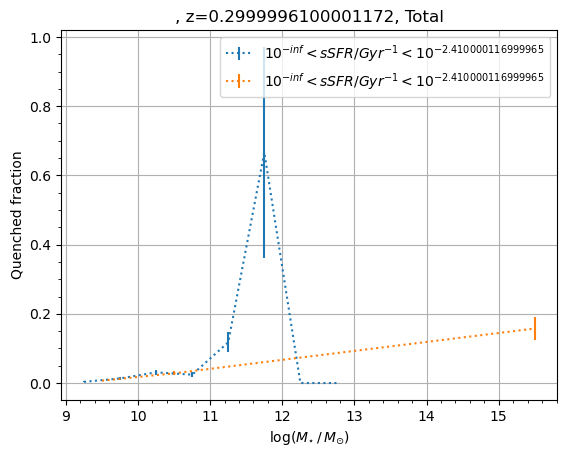

z = 0.20000048000019177 :



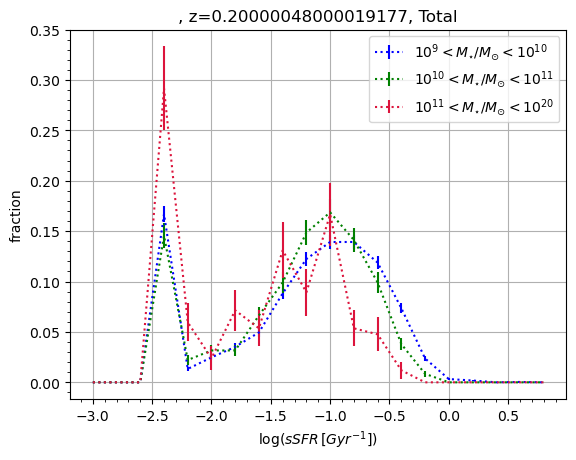

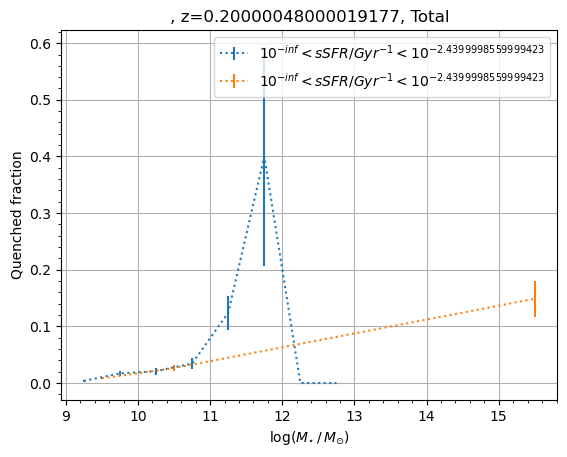

z = 0.09999989000001142 :



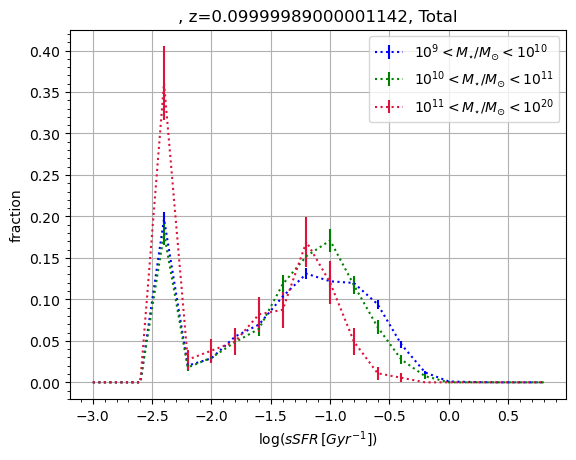

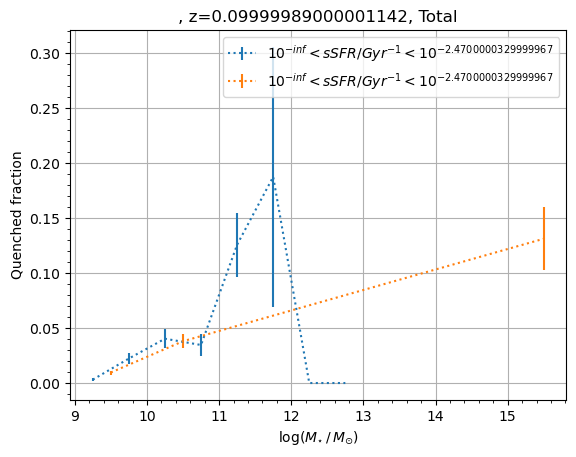

z = 4.440892098500626e-16 :



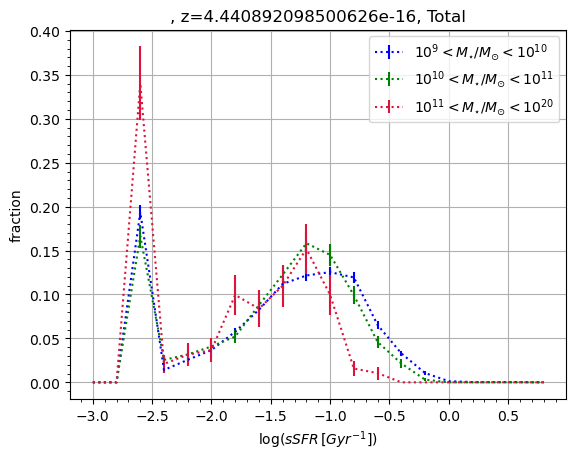

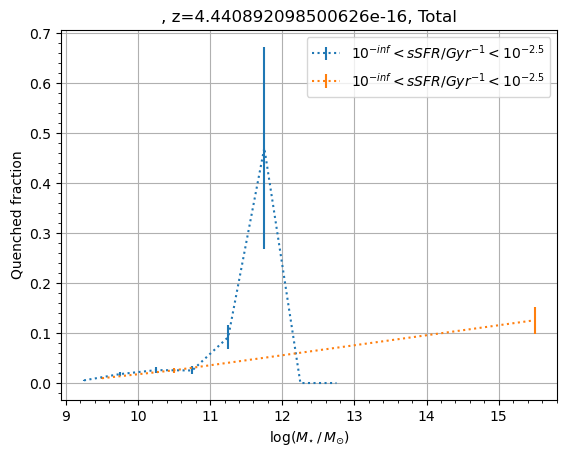

In [20]:
## IGNORE

# How to deal with non-finite ssfrs? include in denominator of fraction?
# For poisson error, should I incorporate the poisson error in the total count (ie the denominator in the fraction)?

# N_bins_ssfr_hist_sf = 16
# plt.clf()

colors = ['b', 'g', 'crimson', 'm', 'r', 'y', 'k']

# for redshift_, Vcom, boxsize, gal_pos_Mpc in (redshift_s, volumes_com, boxsizes, gal_positions_Mpc):
for redshift_ in redshifts:
    print('z =', redshift_, ':')
#     print(log_sfr['gal_inst'][str(redshift_)])
#     print(log_gal_masses['stellar'][str(redshift_)])
    print()
    
    
    log_Mstar_ = log_gal_masses['stellar'][str(redshift_)]
#     log_Mstar_central_ = log_gal_masses['central_stellar'][str(redshift_)]
#     log_Mstar_sat_ = log_gal_masses['satellite_stellar'][str(redshift_)]
    
    log_ssfr_ = log_ssfr['gal_inst'][str(redshift_)]
#     log_ssfr_central_ = log_ssfr['gal_central_inst'][str(redshift_)]
#     log_ssfr_sat_ = log_ssfr['gal_sat_inst'][str(redshift_)]
    
    
    
    # sSFR Histograms
    logM_bins_ = np.array([9, 10, 11, 20])
    # log_ssfr_bins_ = np.arange(-3, 1, 0.2)
    log_ssfr_bins_ = np.arange(-3.1, 1, 0.2)
#     print(log_ssfr_bins_)
    log_ssfr_lim_ = -2.5 + 0.3*redshift_
    
    log_ssfr_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_, log_ssfr_, log_ssfr_lim=log_ssfr_lim_)
#     log_ssfr_central_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_central_, log_ssfr_central_, log_ssfr_lim=log_ssfr_lim_)
#     log_ssfr_sat_hists_ = gen.log_ssfr_hist_func(logM_bins_, log_ssfr_bins_, log_Mstar_sat_, log_ssfr_sat_, log_ssfr_lim=log_ssfr_lim_)
    
    
    
    plt.clf()
    plt.xlabel(r'$\log(sSFR\,[Gyr^{-1}])$')
    plt.ylabel(r'fraction')
    plt.title(r'%s, z=%s, Total' % (cali_num, redshift_))
    plt.grid()
    plt.minorticks_on()
    for ii in range(len(log_ssfr_hists_)):
        plt.errorbar(log_ssfr_hists_[ii][0], log_ssfr_hists_[ii][1], 
                     yerr=log_ssfr_hists_[ii][2], ls=':', color=colors[ii],
                     label=r'$10^{%s} < M_{\star}/M_{\odot} < 10^{%s}$' % (logM_bins_[ii], logM_bins_[ii+1]))
    plt.legend()
    plt.show()
        
#     plt.clf()
#     plt.xlabel(r'$\log(sSFR\,[Gyr^{-1}])$')
#     plt.ylabel(r'fraction')
#     plt.title(r'%s, z=%s, Centrals' % (cali_num, redshift_))
#     plt.grid()
#     plt.minorticks_on()
#     for ii in range(len(log_ssfr_central_hists_)):
#         plt.errorbar(log_ssfr_central_hists_[ii][0], log_ssfr_central_hists_[ii][1], 
#                      yerr=log_ssfr_central_hists_[ii][2], ls=':', color=colors[ii],
#                      label=r'$10^{%s} < M_{\star}/M_{\odot} < 10^{%s}$' % (logM_bins_[ii], logM_bins_[ii+1]))
#     plt.legend()
#     plt.show()
    
#     plt.clf()
#     plt.xlabel(r'$\log(sSFR\,[Gyr^{-1}])$')
#     plt.ylabel(r'fraction')
#     plt.title(r'%s, z=%s, Satellites' % (cali_num, redshift_))
#     plt.grid()
#     plt.minorticks_on()
#     for ii in range(len(log_ssfr_sat_hists_)):
#         plt.errorbar(log_ssfr_sat_hists_[ii][0], log_ssfr_sat_hists_[ii][1], 
#                      yerr=log_ssfr_sat_hists_[ii][2], ls=':', color=colors[ii],
#                      label=r'$10^{%s} < M_{\star}/M_{\odot} < 10^{%s}$' % (logM_bins_[ii], logM_bins_[ii+1]))
#     plt.legend()
#     plt.show()
    
    
    
    
    
    # Quenched fraction plotted as a function of stellar mass
    # log_ssfr_bins_ = np.array([-np.inf, -2.5, np.inf])
    log_ssfr_bins_ = np.array([-np.inf, log_ssfr_lim_])
    logM_bins_ = np.array([9, 10, 11, 20])
    
    quenched_fraction_ = gen.ssfr_fraction_func(log_Mstar_, log_ssfr_, log_ssfr_bins_, dlogM=0.5, 
                                                min_logM=9, max_logM=13, calc_min_logM=False, calc_max_logM=False)
#     quenched_fraction_central_ = gen.ssfr_fraction_func(log_Mstar_central_, log_ssfr_central_, log_ssfr_bins_, dlogM=0.5, 
#                                                 min_logM=9, max_logM=13, calc_min_logM=False, calc_max_logM=False)
#     quenched_fraction_sat_ = gen.ssfr_fraction_func(log_Mstar_sat_, log_ssfr_sat_, log_ssfr_bins_, dlogM=0.5, 
#                                                 min_logM=9, max_logM=13, calc_min_logM=False, calc_max_logM=False)
    
    quenched_fraction_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_, log_ssfr_, logM_bins_, log_ssfr_bins_)
#     quenched_fraction_central_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_central_, log_ssfr_central_, logM_bins_, log_ssfr_bins_)
#     quenched_fraction_sat_v2_ = gen.ssfr_fraction_func_v2(log_Mstar_sat_, log_ssfr_sat_, logM_bins_, log_ssfr_bins_)
    
    
    plt.clf()
    plt.xlabel(r'$\log(M_{\star}\,/\,M_{\odot})$')
    plt.ylabel(r'Quenched fraction')
    plt.title(r'%s, z=%s, Total' % (cali_num, redshift_))
    plt.grid()
    plt.minorticks_on()
    for ii in range(len(quenched_fraction_)):
        plt.errorbar(quenched_fraction_[ii][0], quenched_fraction_[ii][1], 
                     yerr=quenched_fraction_[ii][2], ls=':',# color=colors[ii],
                     label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
        
    for ii in range(len(quenched_fraction_v2_)):
        plt.errorbar(quenched_fraction_v2_[ii][0], quenched_fraction_v2_[ii][1], 
                     yerr=quenched_fraction_v2_[ii][2], ls=':',# color=colors[ii],
                     label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
    
    plt.legend()
    plt.show()
    
#     plt.clf()
#     plt.xlabel(r'$\log(M_{\star}\,/\,M_{\odot})$')
#     plt.ylabel(r'Quenched fraction')
#     plt.title(r'%s, z=%s, Centrals' % (cali_num, redshift_))
#     plt.grid()
#     plt.minorticks_on()
#     for ii in range(len(quenched_fraction_central_)):
#         plt.errorbar(quenched_fraction_central_[ii][0], quenched_fraction_central_[ii][1], 
#                      yerr=quenched_fraction_central_[ii][2], ls=':',# color=colors[ii],
#                      label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
        
#     for ii in range(len(quenched_fraction_central_v2_)):
#         plt.errorbar(quenched_fraction_central_v2_[ii][0], quenched_fraction_central_v2_[ii][1], 
#                      yerr=quenched_fraction_central_v2_[ii][2], ls=':',# color=colors[ii],
#                      label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
    
#     plt.legend()
#     plt.show()
    
#     plt.clf()
#     plt.xlabel(r'$\log(M_{\star}\,/\,M_{\odot})$')
#     plt.ylabel(r'Quenched fraction')
#     plt.title(r'%s, z=%s, Satellites' % (cali_num, redshift_))
#     plt.grid()
#     plt.minorticks_on()
#     for ii in range(len(quenched_fraction_sat_)):
#         plt.errorbar(quenched_fraction_sat_[ii][0], quenched_fraction_sat_[ii][1], 
#                      yerr=quenched_fraction_sat_[ii][2], ls=':',# color=colors[ii],
#                      label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
    
#     for ii in range(len(quenched_fraction_sat_v2_)):
#         plt.errorbar(quenched_fraction_sat_v2_[ii][0], quenched_fraction_sat_v2_[ii][1], 
#                      yerr=quenched_fraction_sat_v2_[ii][2], ls=':',# color=colors[ii],
#                      label=r'$10^{%s} < sSFR/Gyr^{-1} < 10^{%s}$' % (log_ssfr_bins_[ii], log_ssfr_bins_[ii+1]))
    
#     plt.legend()
#     plt.show()

## Cosmic Star Formation Rate Density (from SFR.txt file)

In [151]:
sfr_output_units = unyt.msun / (unyt.year * unyt.Mpc ** 3)

def load_sfr_data(simulation, preloaded=None):
    filename = f"{simulation}/SFR.txt"
    data = np.genfromtxt(filename).T

    print(filename)
    if preloaded is None:
        preloaded = {}
#         preloaded['snapshot'] = f"{simulation}/simba_s12.5n128_0000.hdf5"
        preloaded['snapshot'] = "%s/%s_0000.hdf5" % (simulation, snap_prefix)
        preloaded['initial_snapshot'] = swiftsimio.load(preloaded['snapshot'])
        preloaded['units'] = preloaded['initial_snapshot'].units
        preloaded['boxsize'] = preloaded['initial_snapshot'].metadata.boxsize
        preloaded['box_volume'] = preloaded['boxsize'][0] * preloaded['boxsize'][1] * preloaded['boxsize'][2]

        preloaded['sfr_units'] = preloaded['initial_snapshot'].gas.star_formation_rates.units

    # a, Redshift, SFR
    return data[2], data[3], (data[7] * preloaded['sfr_units'] / preloaded['box_volume']).to(sfr_output_units)

simulations_ = {"%s" % snap_dir: r"%s" % snap_prefix}#

sim_keys = [k for k in simulations_.keys()]
snapshot = "%s/%s_0000.hdf5" % (sim_keys[0], snap_prefix)
preloaded = {}
preloaded['initial_snapshot'] = swiftsimio.load(snapshot)
preloaded['units'] = preloaded['initial_snapshot'].units
preloaded['boxsize'] = preloaded['initial_snapshot'].metadata.boxsize
preloaded['box_volume'] = preloaded['boxsize'][0] * preloaded['boxsize'][1] * preloaded['boxsize'][2]

preloaded['sfr_units'] = preloaded['initial_snapshot'].gas.star_formation_rates.units

preloaded = None
csfh_simulation_data = {k: load_sfr_data(k, preloaded=preloaded) for k in simulations_.keys()}

/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020_calibration6_mpi/SFR.txt


In [152]:
csfh_simulation_data

{'/scratch/b/babul/aspadawe/swift_tests/s50n512_simba_ps2020_calibration6_mpi': (array([0.004    , 0.0040216, 0.0040434, ..., 0.9999947, 0.9999974,
         1.       ]),
  array([2.49000000e+02, 2.47655615e+02, 2.46318459e+02, ...,
         5.30000000e-06, 2.60000000e-06, 0.00000000e+00]),
  unyt_array([0.        , 0.        , 0.        , ..., 0.0143308 ,
              0.0143308 , 0.01432512], 'Msun/(Mpc**3*yr)'))}

In [52]:
csfh_observational_data = read_obs_data(path='/home/b/babul/aspadawe/scripts/rennehan/plotting/star_formation_history/observational_data')

In [53]:
csfh_observational_data

Karim et al. (2011) [radio]
Rodighiero et al. (2010) [24 $\mu$m]
Cucciati et al. (2012) [fuv]
Gruppioni et al. (2013) [IR]


ValueError: 'yerr' must not contain negative values

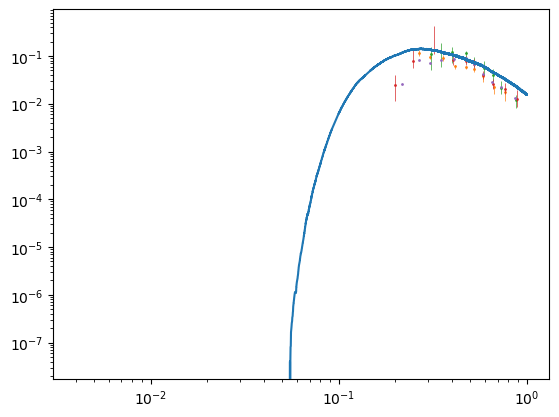

In [35]:
# Simulation data plotting

try:
    plt.style.use("mnras_durham")
except:
    pass

fig, ax = plt.subplots()
ax.loglog()


simulation_lines = []
simulation_labels = []

for simulation in csfh_simulation_data.keys():
    scale_factor, redshift, sfr = csfh_simulation_data[simulation]
    name = simulations_[simulation]

    # High z-order as we always want these to be on top of the observations
    simulation_lines.append(
        ax.plot(scale_factor, sfr.value, label=name, zorder=10000)[0]
    )
    simulation_labels.append(name)
    
    

    
    
# Observational data plotting

observation_lines = []
observation_labels = []

for index, observation in enumerate(csfh_observational_data):
    print(observation.description)
    if observation.fitting_formula:
        if observation.description == "EAGLE NoAGN":
            observation_lines.append(
                ax.plot(
                    observation.scale_factor,
                    observation.sfr,
                    label=observation.description,
                    color="aquamarine",
                    zorder=-10000,
                    linewidth=1,
                    alpha=0.5,
                )[0]
            )
        else:
            observation_lines.append(
                ax.plot(
                    observation.scale_factor,
                    observation.sfr,
                    label=observation.description,
                    color="grey",
                    linewidth=1,
                    zorder=-1000,
                )[0]
            )
    else:
        observation_lines.append(
            ax.errorbar(
                observation.scale_factor,
                observation.sfr,
                observation.error,
                label=observation.description,
                linestyle="none",
                marker="o",
                elinewidth=0.5,
                markeredgecolor="none",
                markersize=2,
                zorder=index,  # Required to have line and blob at same zodrer
            )
        )
    observation_labels.append(observation.description)
    
    
    
ax.set_xlabel("Redshift $z$")
ax.set_ylabel(r"SFR Density $\dot{\rho}_*$ [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$]")


redshift_ticks = np.array([0.0, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0])
redshift_labels = [
    "$0$",
    "$0.2$",
    "$0.5$",
    "$1$",
    "$2$",
    "$3$",
    "$5$",
    "$10$",
    "$20$",
    "$50$",
    "$100$",
]
a_ticks = 1.0 / (redshift_ticks + 1.0)

ax.set_xticks(a_ticks)
ax.set_xticklabels(redshift_labels)
ax.tick_params(axis="x", which="minor", bottom=False)

ax.set_xlim(1.02, 0.07)
ax.set_ylim(1.8e-4, 1.7)


simulation_legend = ax.legend(
    simulation_lines, simulation_labels, markerfirst=False, loc=1, fontsize=6
)
observation_legend = ax.legend(
    observation_lines, observation_labels, markerfirst=True, loc=3, fontsize=6, ncol=2
)
ax.add_artist(simulation_legend)

fig.tight_layout()

plt.show()

In [153]:
data_SFRtxt = np.genfromtxt(os.path.join(snap_dir, 'SFR.txt'))

In [154]:
time_SFRtxt = data_SFRtxt[:,1] * 9.778131e+05  # Myr
z_SFRtxt = data_SFRtxt[:,3]
total_Mstar_SFRtxt = data_SFRtxt[:,4] * 1.000000e+10  # Msun
SFR_active_SFRtxt = data_SFRtxt[:,5] * 1.022690e-02  # Msun/yr
SFRdt_active_SFRtxt = data_SFRtxt[:,6] * 1.000000e+10  # Msun
SFR_total_SFRtxt = data_SFRtxt[:,7] * 1.022690e-02  # Msun/yr

In [155]:
SFRD_active_SFRtxt = SFR_active_SFRtxt/Vcom
SFRD_total_SFRtxt = SFR_total_SFRtxt/Vcom

In [156]:
len(SFRD_total_SFRtxt[::1])

815954

/tmp/ipykernel_203635/215243476.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(1+redshift_), np.log10(sfr_.value), label=name_, zorder=10000)[0]


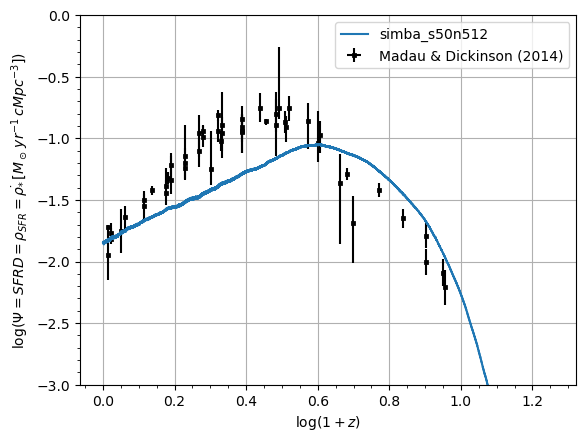

In [157]:
#fig, ax = plt.subplots()
plt.clf()
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0, 3)
#plt.ylim(-2.2, -0.5)
# plt.xlim(0, 8)
# plt.ylim(-2.5, -0.5)



# for simulation in simulation_data.keys():
#     scale_factor_, redshift_, sfr_ = simulation_data[simulation]
#     name_ = simulations_[simulation]
#     plt.plot(redshift_, sfr_.value, label=name_, zorder=10000)



# plt.xlabel(r'$z$')
plt.xlabel(r'$\log(1+z)$')
plt.ylabel(r'$\log(\Psi=SFRD=\rho_{SFR}=\dot{\rho_{*}}\, [M_\odot\, yr^{-1}\, cMpc^{-3}])$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()
#plt.plot(z_SFRtxt, np.log10(SFRD_active_SFRtxt), ls='-', label=r'Active')
# plt.plot(z_SFRtxt[::1], SFRD_total_SFRtxt[::1], ls='-', label=r'Total')

plt.ylim(-3,0)

for simulation in csfh_simulation_data.keys():
    scale_factor_, redshift_, sfr_ = csfh_simulation_data[simulation]
    name_ = simulations_[simulation]

    # High z-order as we always want these to be on top of the observations
    plt.plot(np.log10(1+redshift_), np.log10(sfr_.value), label=name_, zorder=10000)[0]
    
#     simulation_lines.append(
#         ax.plot(scale_factor, sfr.value, label=name, zorder=10000)[0]
#     )
#     simulation_labels.append(name)

# for key, item in csfh_simulation_data.items():
#     plt


observations_ = observational_data['observations']['csfh']['MD14']['md14_csfh_log_data.hdf5']
plt.errorbar(observations_.x.value, observations_.y.value,
            xerr=observations_.x_scatter.value, yerr=observations_.y_scatter.value,
            label=observations_.citation,
            marker='s', ms=2, mec='black', color='black', mew=2, ls='')


# plt.errorbar(z_md14, log_sfrd_md14, yerr=(siglo_md14, sighi_md14), label='MD14',
#              marker='s', ms=2, mec='black', mew=2, ecolor='black', ls='')
# plt.errorbar(z_md14, sfrd_md14, yerr=(sfrd_err_lo_md14, sfrd_err_hi_md14), label='MD14',
#              marker='s', ms=2, mec='black', mew=2, ecolor='black', ls='')
# plt.errorbar(z_md14, sfrd_md14, yerr=(sfrd_err_lo_md14_v2, sfrd_err_hi_md14_v2), label='MD14 v2',
#              marker='s', ms=2, mec='black', mew=2, ls='')
# plt.errorbar(z_md14, sfrd_md14, yerr=(sfrd_err_lo_md14_v3, sfrd_err_hi_md14_v3), label='MD14 v3',
#              marker='s', ms=2, mec='black', mew=2, ls='')
plt.legend()
plt.show()

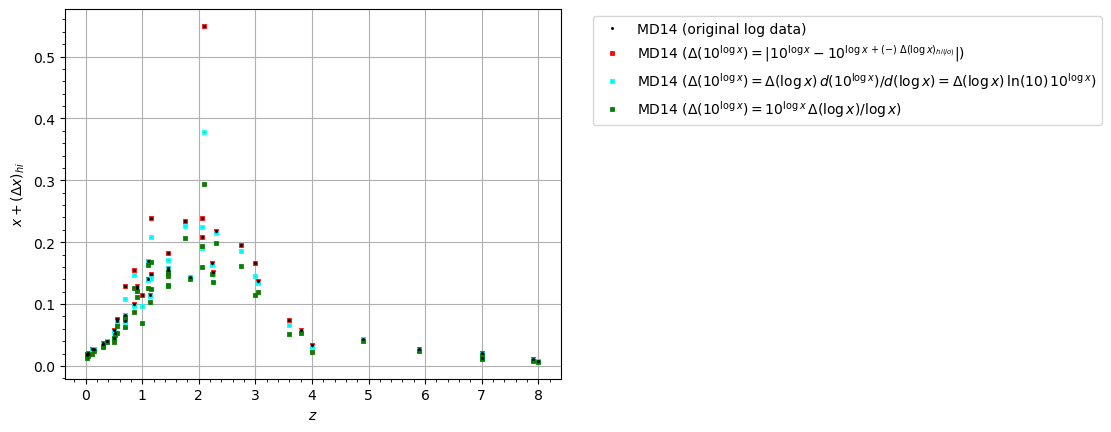

In [140]:
#fig, ax = plt.subplots()
plt.clf()
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0, 3)
#plt.ylim(-2.2, -0.5)
# plt.xlim(0, 8)
# plt.ylim(-2.5, -0.5)



# for simulation in simulation_data.keys():
#     scale_factor_, redshift_, sfr_ = simulation_data[simulation]
#     name_ = simulations_[simulation]
#     plt.plot(redshift_, sfr_.value, label=name_, zorder=10000)



plt.xlabel(r'$z$')
# plt.ylabel(r'$\log(\Psi=SFRD=\rho_{SFR}=\dot{\rho_{*}}\, [M_\odot\, yr^{-1}\, cMpc^{-3}])$')
# plt.ylabel(r'relative error (lo)')
plt.ylabel(r'$x + (\Delta x)_{hi}$')
plt.title(r'%s' % (cali_num))
plt.grid()
plt.minorticks_on()

# plt.plot(z_md14, np.abs((log_sfrd_err_lo_md14)/log_sfrd_md14), label='MD14 (original log data)',
#              marker='s', ms=1, mec='black', mew=1, ls='', zorder=1000)

# plt.plot(z_md14, np.abs((sfrd_err_lo_md14)/sfrd_md14), label=r'MD14 ($\Delta(10^{\log x}) = |10^{\log x} - 10^{\log x \, +(-) \,\, \Delta(\log{x})_{hi(lo)}}|$)',
#              marker='s', ms=2, mec='red', mew=2, ls='')
# plt.plot(z_md14, np.abs((sfrd_err_lo_md14_v2)/sfrd_md14), label='MD14 ($\Delta(10^{\log x}) = \Delta(\log{x}) \, d(10^{\log x})/d(\log x) = \Delta(\log{x}) \, \ln(10) \, 10^{\log x}$)',
#              marker='s', ms=2, mec='cyan', mew=2, ls='')
# plt.plot(z_md14, np.abs((sfrd_err_lo_md14_v3)/sfrd_md14), label='MD14 ($\Delta(10^{\log x}) = 10^{\log x} \, \Delta(\log{x})/\log x$)',
#              marker='s', ms=2, mec='green', mew=2, ls='')


plt.plot(z_md14, 10**(log_sfrd_md14 + log_sfrd_err_hi_md14), label='MD14 (original log data)',
             marker='s', ms=1, mec='black', mew=1, ls='', zorder=1000)

plt.plot(z_md14, sfrd_md14 + sfrd_err_hi_md14, label=r'MD14 ($\Delta(10^{\log x}) = |10^{\log x} - 10^{\log x \, +(-) \,\, \Delta(\log{x})_{hi(lo)}}|$)',
             marker='s', ms=2, mec='red', mew=2, ls='')
plt.plot(z_md14, sfrd_md14 + sfrd_err_hi_md14_v2, label='MD14 ($\Delta(10^{\log x}) = \Delta(\log{x}) \, d(10^{\log x})/d(\log x) = \Delta(\log{x}) \, \ln(10) \, 10^{\log x}$)',
             marker='s', ms=2, mec='cyan', mew=2, ls='')
plt.plot(z_md14, sfrd_md14 + sfrd_err_hi_md14_v3, label='MD14 ($\Delta(10^{\log x}) = 10^{\log x} \, \Delta(\log{x})/\log x$)',
             marker='s', ms=2, mec='green', mew=2, ls='')


# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()